---
# **Classification of Biomedical Texts with Deep Learning: LSTM, GRU, and Soft-Attention**

---

In biomedical text classification, datasets are often highly imbalanced, with some categories (e.g., rare diseases or specific biomedical events) severely underrepresented compared to others. This imbalance can lead to biased model performance, where deep learning models tend to favor the majority class, overlooking critical but rare information.

To overcome this challenge during the selection phase of our pipeline, we explore a range of resampling techniques aimed at improving the robustness and fairness of our models: **SMOTE** (Synthetic Minority Over-sampling Technique),
**Borderline-SMOTE** and **Class Weights**.

These techniques are applied across our deep learning architectures — LSTM, GRU, and GRU with Bahdanau Self-Attention — to evaluate their impact on key classification metrics such as F1 Score, Balanced Accuracy, Recall, and Precision.

By tackling class imbalance head-on, we aim to build models that are not only accurate but also equitable, especially in critical biomedical applications where every class — no matter how small — matters.

In [1]:
import random
import re
import time
from collections import defaultdict, Counter
import numpy as np
import torch
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix,
                             classification_report, balanced_accuracy_score,
                             precision_score, recall_score, ConfusionMatrixDisplay)
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data.dataset import ConcatDataset
import torch.nn as nn
import torch.optim as optim
import wandb

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# To ensure reproducibility of the results
SEED = 200
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data = pd.read_csv('/content/drive/MyDrive/diseases_dataset.csv')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38652 entries, 0 to 38651
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   PMID                38652 non-null  int64 
 1   Title               38652 non-null  object
 2   Abstract            38652 non-null  object
 3   Keywords            38652 non-null  object
 4   PublicationYear     38652 non-null  int64 
 5   MeSH_Terms          38652 non-null  object
 6   Cleaned_Abstract    38652 non-null  object
 7   Disease             38652 non-null  object
 8   Top_Relevant_Words  38652 non-null  object
 9   Label               38652 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 2.9+ MB


Let's determining the number of samples of each class.

In [ ]:
print("Original class distribution:")
print(Counter(data['Label']))

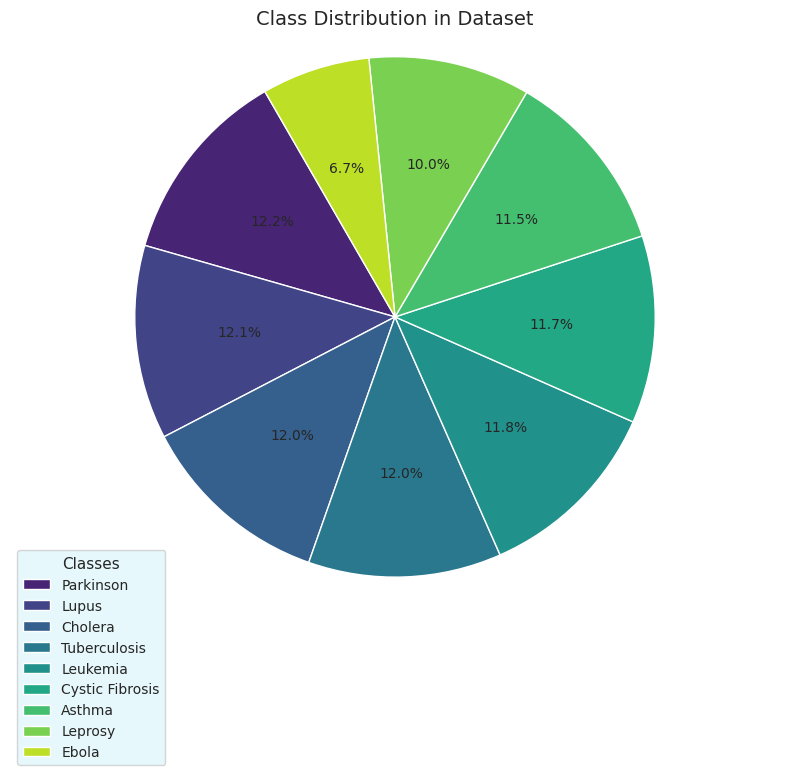

In [7]:
class_names_dict = {
    0: 'Tuberculosis',
    1: 'Cholera',
    2: 'Leprosy',
    3: 'Ebola',
    4: 'Leukemia',
    5: 'Asthma',
    6: 'Parkinson',
    7: 'Lupus',
    8: 'Cystic Fibrosis'
}

label_counts = Counter(data['Label'])
label_counts_named = {class_names_dict.get(k, k): v for k, v in label_counts.items()}
label_df = pd.DataFrame.from_dict(label_counts_named, orient='index').reset_index()
label_df.columns = ['Label', 'Count']
label_df = label_df.sort_values(by='Count', ascending=False)

sns.set_style("darkgrid", {
    "grid.color": ".4",
    "grid.linestyle": "-",
    "axes.facecolor": "#e0f7fa"
})

custom_colors = sns.color_palette("viridis", n_colors=len(label_df))

fig, ax = plt.subplots(figsize=(8, 8))

wedges, texts, autotexts = ax.pie(label_df['Count'],
                                  labels=None,
                                  autopct='%1.1f%%',
                                  startangle=120,
                                  colors=custom_colors,
                                  wedgeprops=dict(edgecolor='white'))

ax.legend(wedges,
          label_df['Label'],
          title="Classes",
          loc="lower left",
          bbox_to_anchor=(0, -0.3),
          fontsize=10,
          title_fontsize=11)

ax.set_title('Class Distribution in Dataset', fontsize=14)
ax.axis('equal')

plt.tight_layout()
plt.show()

In [ ]:
X = data["Cleaned_Abstract"].values
y = data["Label"].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

Training set: 27056 samples
Validation set: 5798 samples
Test set: 5798 samples


In [ ]:
def tokenize(text):
    """
    Tokenizes the input text by converting it to lowercase and splitting it into words.

    Args:
        text: A string containing the text to be tokenized.

    Returns:
        A list of tokens (words) from the text.
    """
    return re.findall(r'\b\w+\b', text.lower())

In [ ]:
all_tokens = [token for text in X_train for token in tokenize(text)]
vocab = Counter(all_tokens)
filtered_vocab = {word: freq for word, freq in vocab.items() if freq >= 2}
VOCAB_SIZE =  40000

sorted_filtered_vocab = dict(sorted(filtered_vocab.items(), key=lambda item: item[1], reverse=True)[:VOCAB_SIZE])

word_to_index = {word: idx for idx, (word, _) in enumerate(sorted_filtered_vocab.items(), 1)}
word_to_index["<PAD>"] = 0
word_to_index["<UNK>"] = len(word_to_index)

index_to_word = {idx: word for word, idx in word_to_index.items()}
print(word_to_index["malaria"])
print(index_to_word[1])

print(index_to_word[300])
print(word_to_index["host"])

1443
patient
relationship
351


In [ ]:
def text_to_sequence(text):
    """
    Converts the tokenized text into a sequence of indices based on a word-to-index mapping.

    Args:
        text: A string containing the text to be converted.

    Returns:
        A list of integers representing the sequence of token indices.
    """
    return [word_to_index.get(token, word_to_index["<UNK>"]) for token in tokenize(text)]

def pad_to_tensor(sequences, max_len=None):
    """
    Pads sequences to the specified maximum length, or truncates them if they exceed it.

    Args:
        sequences: A list of sequences (each sequence is a list of integers).
        max_len: The maximum length to which sequences should be padded. If None, no padding is applied.

    Returns:
        A tensor containing the padded (or truncated) sequences.
    """
    padded_sequences = [torch.tensor(seq, dtype=torch.long) for seq in sequences]
    if max_len:
        padded_sequences = [seq[:max_len] for seq in padded_sequences]
        padded_sequences = [
            torch.cat([seq, torch.zeros(max_len - len(seq), dtype=torch.long)], 0) if len(seq) < max_len else seq
            for seq in padded_sequences
        ]

    return torch.stack(padded_sequences)

class TextDataset(Dataset):
    """
    Custom Dataset for handling text data and labels.

    Args:
        X_data: Input features (e.g., tokenized text).
        y_data: Labels corresponding to the text data.
        raw_text_data: (Optional) The raw text data for reference (default is None).
    """
    def __init__(self, X_data, y_data, raw_text_data=None):
        self.X = torch.tensor(X_data, dtype=torch.long)
        self.y = torch.tensor(y_data, dtype=torch.long)
        self.raw_text_data = raw_text_data

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        input_tensor = self.X[idx]
        target_tensor = self.y[idx]

        raw_text = None
        if self.raw_text_data is not None and idx < len(self.raw_text_data):
            raw_text = self.raw_text_data[idx]

        return input_tensor, target_tensor, raw_text

def custom_collate_fn(batch):
    inputs, targets, raw_texts = zip(*batch)
    inputs = torch.stack(inputs)
    targets = torch.stack(targets)
    return inputs, targets, list(raw_texts)

def load_glove_embeddings(glove_path, word_to_index, embedding_dim):
    """Loads GloVe embeddings and returns an embedding matrix."""
    embedding_matrix = np.zeros((len(word_to_index), embedding_dim), dtype='float32')
    with open(glove_path, 'r', encoding="utf-8") as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            if word in word_to_index:
                vector = np.asarray(values[1:], dtype='float32')
                embedding_matrix[word_to_index[word]] = vector

    return torch.tensor(embedding_matrix, dtype=torch.float)

In [ ]:
EMBEDDING_DIM = 300
embedding_matrix = load_glove_embeddings('/content/drive/MyDrive/glove/glove.6B.300d.txt', word_to_index, EMBEDDING_DIM)

X_train_seq = [text_to_sequence(text) for text in X_train]
X_val_seq = [text_to_sequence(text) for text in X_val]
X_test_seq = [text_to_sequence(text) for text in X_test]

print(X_train_seq[0])

[79, 347, 3, 40, 127, 119, 11, 445, 2521, 351, 89, 42, 342, 763, 7415, 333, 5299, 6666, 133, 448, 52, 18, 1464, 79, 4, 499, 295, 233, 31, 6666, 1243, 38, 18, 699, 389, 2717, 119, 11, 445, 161, 4, 2639, 611, 83, 1490, 387, 694, 112, 6666, 79, 412, 1440, 913, 557, 3331, 40001, 622, 728, 128, 4687, 909, 2871, 458, 64, 607, 4412, 219, 4, 190, 19, 7153, 8005, 190, 287, 375, 876, 74, 1354, 458, 93, 4, 229, 9, 654, 132, 6666, 233, 31, 1243, 917, 2298, 213, 38, 4283, 18, 775, 43, 114, 136, 445, 9, 337, 6666, 40, 429, 80, 11, 301, 79]


In [ ]:
max_length = 400

X_train_tensor = pad_to_tensor(X_train_seq, max_len=max_length)
X_val_tensor = pad_to_tensor(X_val_seq, max_len=max_length)
X_test_tensor = pad_to_tensor(X_test_seq, max_len=max_length)

print(f"Train Tensor Shape: {X_train_tensor.shape}, Type: {X_train_tensor.dtype}")
print(f"Validation Tensor Shape: {X_val_tensor.shape}, Type: {X_val_tensor.dtype}")
print(f"Test Tensor Shape: {X_test_tensor.shape}, Type: {X_test_tensor.dtype}")

y_train_tensor = torch.tensor(y_train)
y_val_tensor = torch.tensor(y_val)
y_test_tensor = torch.tensor(y_test)

Train Tensor Shape: torch.Size([27056, 400]), Type: torch.int64
Validation Tensor Shape: torch.Size([5798, 400]), Type: torch.int64
Test Tensor Shape: torch.Size([5798, 400]), Type: torch.int64


In [ ]:
NUM_CLASSES = len(torch.unique(y_train_tensor))
VOCAB_SIZE = len(word_to_index)

# ============ Define Hybrid CNN-LSTM Model ============
class CNN_LSTM_Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim=NUM_CLASSES, num_layers=1, dropout_prob=0.3, num_filters=100, kernel_size=3):
        super(CNN_LSTM_Model, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=kernel_size, padding=1)
        self.conv2 = nn.Conv1d(in_channels=num_filters, out_channels=num_filters, kernel_size=kernel_size, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        self.lstm = nn.LSTM(input_size=num_filters, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout_prob if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = embedded.permute(0, 2, 1)
        conv_out = self.relu(self.conv1(embedded))
        conv_out = self.relu(self.conv2(conv_out))
        conv_out = self.pool(conv_out)

        conv_out = conv_out.permute(0, 2, 1)
        lstm_out, _ = self.lstm(conv_out)
        lstm_out = self.dropout(lstm_out[:, -1, :])
        out = self.fc(lstm_out)
        return out

# ==========================  GRU Model with Word Embeddings ==========================
class GRU_Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim=NUM_CLASSES , num_layers=1, dropout_prob=0.5, embedding_weights=None, freeze_embeddings=False):
        super(GRU_Model, self).__init__()

        if embedding_weights is not None:
            self.embedding = nn.Embedding.from_pretrained(embedding_weights, freeze=freeze_embeddings)
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.gru = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_prob if num_layers > 1 else 0  # Dropout only if num_layers > 1
        )

        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        gru_out = self.dropout(gru_out[:, -1, :])
        out = self.fc(gru_out)
        return out

# ========================== Bahdanau Attention ==========================
class BahdanauAttention(nn.Module):
    """
    Bahdanau Attention Mechanism.

    This class implements the Bahdanau attention mechanism as described in the paper:
    "Neural Machine Translation by Jointly Learning to Align and Translate" by Bahdanau et al.

    Args:
        hidden_dim (int): The hidden dimension of the GRU or LSTM output.

    Attributes:
        W (nn.Linear): A linear layer for the transformation of the RNN outputs.
        v (nn.Linear): A linear layer for computing attention scores.
    """
    def __init__(self, hidden_dim):
        super(BahdanauAttention, self).__init__()
        self.W = nn.Linear(hidden_dim * 2, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, rnn_outputs):
        """
        Apply the attention mechanism on the RNN outputs.

        Args:
            rnn_outputs (Tensor): The outputs of the RNN (GRU or LSTM).

        Returns:
            Tensor: The context vector computed by the attention mechanism.
        """
        score = torch.tanh(self.W(rnn_outputs))
        attn_weights = torch.softmax(self.v(score), dim=1)
        context = torch.sum(attn_weights * rnn_outputs, dim=1)
        return context

# ========================== Bidirectional GRU + Bahdanau Ateention  ==========================
class GloVe_GRU_BahdanauAttention(nn.Module):
    """
    Model using GloVe embeddings, GRU layers, and Bahdanau Attention for classification.

    Args:
        embedding_matrix (Tensor): Pretrained GloVe embedding matrix.
        hidden_dim (int): Hidden size for the GRU.
        num_classes (int): Output classes.
        num_layers (int): GRU depth.
        dropout_prob (float): Dropout rate.
    """
    def __init__(self, embedding_matrix, hidden_dim, num_classes=NUM_CLASSES, num_layers=1, dropout_prob=0.6):
        super(GloVe_GRU_BahdanauAttention, self).__init__()

        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)

        self.gru = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )

        self.attention = BahdanauAttention(hidden_dim)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        """
        Args:
            x (Tensor): Tensor of token indices (batch_size, seq_len)

        Returns:
            Tensor: Output logits for classification.
        """
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        context = self.attention(gru_out)
        x = self.dropout(context)
        output = self.fc(x)
        return output

In [ ]:
clip = 5.0

def epoch_time(start_time, end_time):
    """
    Calculates the elapsed time between the start and end time.

    Args:
        start_time: The start time (in seconds).
        end_time: The end time (in seconds).

    Returns:
        elapsed_mins: The elapsed time in minutes.
        elapsed_secs: The elapsed time in seconds.
    """
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def calculate_accuracy(y_pred, y_true):
    """
    Computes accuracy for multi-class classification.
    Args:
        y_pred: Raw logits from the model (before softmax).
        y_true: True class labels (integer class indices).
    Returns:
        Accuracy score.
    """
    y_pred = torch.argmax(y_pred, dim=1)  # Get predicted class index
    correct = (y_pred == y_true).sum().item()
    total = y_true.size(0)  # Number of samples
    return correct / total

def train_epoch(model, train_loader, optimizer, criterion, device):
    """
    Train the model for one epoch.
    """
    model.train()
    total_loss, total_accuracy = 0, 0

    for batch in train_loader:
        if len(batch) == 3:
            input_tensor, target_tensor, _ = batch  # Ignore raw_text
        input_tensor, target_tensor = input_tensor.to(device), target_tensor.to(device)

        optimizer.zero_grad()
        output = model(input_tensor)  # Forward pass
        loss = criterion(output, target_tensor)  # Compute loss
        loss.backward()  # Backpropagation

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()

        batch_accuracy = calculate_accuracy(output, target_tensor)

        total_loss += loss.item()
        total_accuracy += batch_accuracy * len(target_tensor)

    avg_loss = total_loss / len(train_loader)
    avg_accuracy = total_accuracy / len(train_loader.dataset)

    return avg_loss, avg_accuracy

def validate_epoch(model, val_loader, criterion, device):
    """
    Validate the model for one epoch.
    Args:
        model: Model instance.
        val_loader: DataLoader for validation data.
        criterion: Loss function (CrossEntropyLoss).
        device: CPU/GPU.
    Returns:
        Average validation loss, accuracy, and F1-score.
    """
    model.eval()  # Set to evaluation mode
    total_loss, total_accuracy = 0, 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in val_loader:
            if len(batch) == 3:
                input_tensor, target_tensor, _ = batch  # Ignore raw_text
            input_tensor, target_tensor = input_tensor.to(device), target_tensor.to(device)

            output = model(input_tensor)  # Forward pass

            loss = criterion(output, target_tensor)  # Compute loss
            batch_accuracy = calculate_accuracy(output, target_tensor)

            total_loss += loss.item()
            total_accuracy += batch_accuracy * len(target_tensor)

            preds = torch.argmax(output, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(target_tensor.cpu().numpy())

    f1 = f1_score(all_labels, all_preds, average="weighted", zero_division=0)
    avg_loss = total_loss / len(val_loader)
    avg_accuracy = total_accuracy / len(val_loader.dataset)

    return avg_loss, avg_accuracy, f1

def get_hidden_states(model, dataloader, device):
    """
    This function extracts the hidden states from a model (either GRU or LSTM) for each sample in the dataloader.
    The hidden states are taken from the last time step of the sequence, which are typically used for classification tasks.

    Args:
        model: A PyTorch model that contains an embedding layer and either a GRU or LSTM layer.
        dataloader: A DataLoader containing batches of input data and their corresponding targets.
        device: The device (CPU or GPU) to run the model on.

    Returns:
        hidden_states: A numpy array containing the hidden states for each sample in the dataloader.
        labels: A numpy array containing the target labels corresponding to each input sample.
    """
    model.eval()
    hidden_states, labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            inputs, targets, _ = batch
            inputs = inputs.to(device)

            embedded = model.embedding(inputs)

            if hasattr(model, "gru"):
                gru_out, _ = model.gru(embedded)
                hidden_state = gru_out[:, -1, :]

            elif hasattr(model, "lstm"):
                lstm_out, (hidden, _) = model.lstm(embedded)
                hidden_state = hidden[-1]

            else:
                raise ValueError("Unsupported model type. Model must contain GRU or LSTM.")

            hidden_states.append(hidden_state.cpu().numpy())
            labels.append(targets.cpu().numpy())

    hidden_states = np.concatenate(hidden_states, axis=0)
    labels = np.concatenate(labels, axis=0)

    return hidden_states, labels

def count_parameters(model):
    """
    Computes the total number of trainable parameters in a model.

    Args:
        model: A PyTorch model instance.

    Returns:
        The total number of trainable parameters in the model.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def reinitialize_weights(model):
    """Reinitializes the model's weights by calling reset_parameters() for each layer that supports it."""
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

def test_epoch(model, test_loader, criterion, device):
    """
    Validate the model for one epoch, including precision, F1, balanced accuracy, and recall.
    Args:
        model: Model instance.
        test_loader: DataLoader for test data.
        criterion: Loss function (CrossEntropyLoss).
        device: CPU/GPU.
    Returns:
        Average test loss, accuracy, F1-score, balanced accuracy, Recall, and Precision.
    """
    model.eval()  # Set model to evaluation mode
    total_loss, total_accuracy = 0, 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in test_loader:
            input_tensor, target_tensor, _ = batch  # Ignore raw_text
            input_tensor, target_tensor = input_tensor.to(device), target_tensor.to(device)

            output = model(input_tensor)  # Forward pass
            loss = criterion(output, target_tensor)  # Compute loss
            batch_accuracy = calculate_accuracy(output, target_tensor)

            total_loss += loss.item()
            total_accuracy += batch_accuracy * len(target_tensor)

            preds = torch.argmax(output, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(target_tensor.cpu().numpy())

    f1 = f1_score(all_labels, all_preds, average="weighted", zero_division=0)
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="weighted", zero_division=0)
    recall = recall_score(all_labels, all_preds, average="weighted", zero_division=0)

    avg_loss = total_loss / len(test_loader)
    avg_accuracy = total_accuracy / len(test_loader.dataset)

    return avg_loss, avg_accuracy, f1, balanced_acc, recall, precision

---
# I. **SMOTE (Synthetic Minority Over-sampling Technique)**

---

**SMOTE (Synthetic Minority Over-sampling Technique)** is a method used to deal with class imbalance problems in datasets. It works by generating synthetic data for the minority class, rather than simply repeating existing examples. SMOTE creates new samples by interpolating the minority class examples with their nearest neighbours in feature space. This technique increases the representation of the minority class, reducing the model's bias towards the majority class. It is often used before training the model to balance the classes without losing important information.

In [ ]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tensor, y_train_tensor)

X_val_resampled, y_val_resampled = X_val_tensor, y_val_tensor
X_test_resampled, y_test_resampled = X_test_tensor, y_test_tensor

In [ ]:
batch_size = 16
train_dataset = TextDataset(X_train_resampled, y_train_resampled, raw_text_data=X_train)
val_dataset = TextDataset(X_val_tensor, y_val, raw_text_data=X_val)
test_dataset = TextDataset(X_test_tensor, y_test, raw_text_data=X_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

combined_dataset = ConcatDataset([train_dataset, val_dataset])
combined_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 30168
Validation set size: 5798
Test set size: 5798


<ipython-input-8-35ba822a06f8>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)


---
## I.1 **SMOTE - CNN-LSTM**


In [ ]:
model = CNN_LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=250, hidden_dim=167, num_layers=1, dropout_prob=0.3).to(device)

print(model)
num_params = count_parameters(model)
print()
print(f"Total trainable parameters: {num_params}")

CNN_LSTM_Model(
  (embedding): Embedding(40002, 250)
  (conv1): Conv1d(250, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(100, 167, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=167, out_features=9, bias=True)
)

Total trainable parameters: 10286904


In [ ]:
model.eval()
embeddings = []
labels = []

with torch.no_grad():
    for inputs, targets, _ in train_loader:
        inputs = inputs.to(device)
        embedded = model.embedding(inputs)
        embeddings.append(embedded.mean(dim=1).cpu().numpy())
        labels.extend(targets.cpu().numpy())

# Convert lists to numpy arrays
embeddings = np.vstack(embeddings)
labels = np.array(labels)

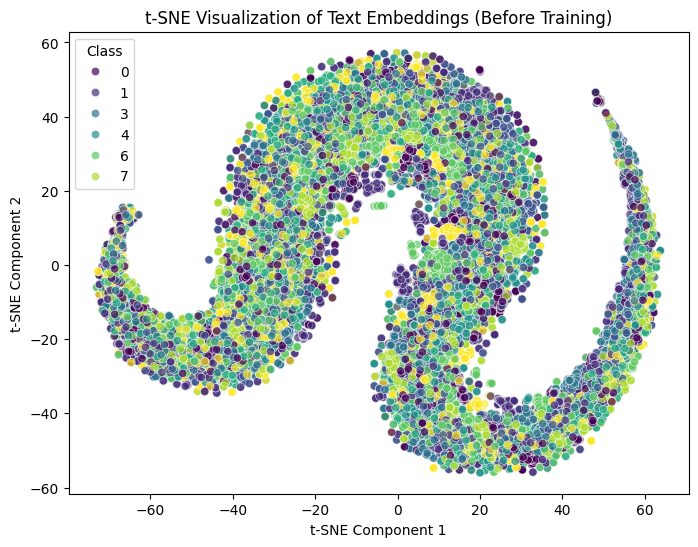

In [ ]:
# Reduce dimensions using t-SNE (after applying SMOTE)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=labels, palette="viridis", alpha=0.7)
plt.title("t-SNE Visualization of Text Embeddings (Before Training)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Class")
plt.show()

### Validation phase

In [ ]:
learning_rate = 1e-3
num_epochs = 20
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
val_f1s = []

with tqdm(total=num_epochs, desc="Training Progress", unit="epoch") as pbar:
    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1s.append(val_f1)

        end_time = time.time()
        epoch_duration = end_time - start_time

        pbar.set_description(
            f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
            f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F1: {val_f1:.2%}, Time: {epoch_duration / 60:.2f} min"
        )
        pbar.update(1)

Epoch 20/20 - Train Loss: 0.1564, Val Loss: 0.5784, Train Acc: 95.83%, Val Acc: 87.96%, Val F1: 87.92%, Time: 0.69 min: 100%|██████████| 20/20 [11:22<00:00, 34.10s/epoch]


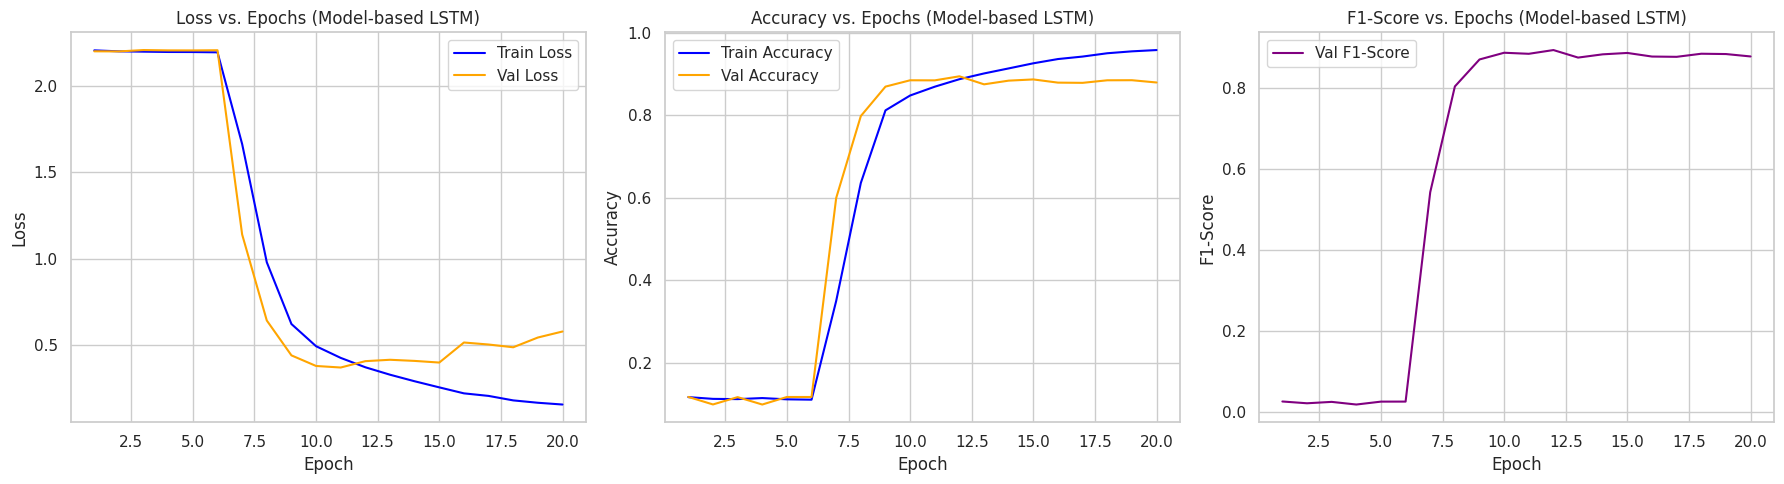

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st plot
sns.lineplot(x=range(1, len(train_losses) + 1), y=train_losses, label='Train Loss', color='blue')
sns.lineplot(x=range(1, len(val_losses) + 1), y=val_losses, label='Val Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs (Model-based LSTM)')
plt.legend()

plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd plot
sns.lineplot(x=range(1, len(train_accuracies) + 1), y=train_accuracies, label='Train Accuracy', color='blue')
sns.lineplot(x=range(1, len(val_accuracies) + 1), y=val_accuracies, label='Val Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs (Model-based LSTM)')
plt.legend()

plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd plot
sns.lineplot(x=range(1, len(val_f1s) + 1), y=val_f1s, label='Val F1-Score', color='purple')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('F1-Score vs. Epochs (Model-based LSTM)')
plt.legend()

plt.tight_layout()
plt.show()

### Optimization phase


The choice of hyperparameters for the different models was based on an analysis of the results obtained from the reports generated by Weights & Biases (WandB). These reports were used to identify the best-performing configurations in terms of accuracy, F1-score and training stability

I.1.1 Optimizer selection

In [ ]:
num_epochs = 20
learning_rate = 1e-3
loss_function = torch.nn.CrossEntropyLoss()

optimizers = {
    'Adam': optim.Adam,
    'RMSprop': optim.RMSprop,
    'AdamW': optim.AdamW,
}

for optimizer_name, optimizer_class in optimizers.items():
    print(f"\n🔹 Training with optimizer: {optimizer_name}")

    model = CNN_LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=250, hidden_dim=167, num_layers=1, dropout_prob=0.3).to(device)
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)

    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge', project='Multi_Class_Optimizer_Comparison_cnn_lstm_SMOTE', name=f"{optimizer_name}_run", config={
        'learning_rate': learning_rate,
        'num_epochs': num_epochs,
        'optimizer': optimizer_name,
        'model': 'CNN_LSTM_Model',
        'embedding_dim': 128,
        'hidden_dim': 167,
        'dropout_prob': 0.5
    })

    print(model)
    num_params = count_parameters(model)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    # Progress bar for training
    with tqdm(total=num_epochs, desc=f"Optimizer: {optimizer_name}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(f"Optimizer: {optimizer_name} | Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train ACC: {train_acc:.2%}, Val ACC: {val_acc:.2%}, Time: {epoch_duration / 60:.2f} min")
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1,
            })

    wandb.finish()


🔹 Training with optimizer: Adam


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: wilfried-mvomoeto (wilfried-mvomoeto-university-of-li-ge) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


CNN_LSTM_Model(
  (embedding): Embedding(40002, 250)
  (conv1): Conv1d(250, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(100, 167, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=167, out_features=9, bias=True)
)
Total trainable parameters: 10286904


Optimizer: Adam | Epoch 20/20 - Train Loss: 1.6875, Val Loss: 1.4920, Train ACC: 31.41%, Val ACC: 39.31%, Time: 0.53 min: 100%|██████████| 20/20 [10:43<00:00, 32.17s/epoch]


train_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▅▅▅▅█
train_loss,██████████████▇▄▃▃▃▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▄▄▄▄█
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▄▄▄▄█
val_loss,██████████████▅▅▅▅▅▁
train_acc,0.31413
train_loss,1.68755
val_acc,0.39307
val_f1,0.30418
val_loss,1.49203



🔹 Training with optimizer: RMSprop


CNN_LSTM_Model(
  (embedding): Embedding(40002, 250)
  (conv1): Conv1d(250, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(100, 167, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=167, out_features=9, bias=True)
)
Total trainable parameters: 10286904


Optimizer: RMSprop | Epoch 20/20 - Train Loss: 0.5074, Val Loss: 0.8199, Train ACC: 77.50%, Val ACC: 70.13%, Time: 0.54 min: 100%|██████████| 20/20 [10:02<00:00, 30.12s/epoch]


train_acc,▁▁▁▁▁▁▁▁▁▂▃▅▆▆▆▆▇███
train_loss,█████████▇▅▄▃▃▃▃▂▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▃▄▆▇▇▇▇████
val_f1,▁▁▁▁▁▁▁▁▁▂▄▆▆▇▇▇████
val_loss,█████████▅▄▃▂▂▂▂▁▁▁▁
train_acc,0.77499
train_loss,0.50741
val_acc,0.70128
val_f1,0.65058
val_loss,0.81988



🔹 Training with optimizer: AdamW


CNN_LSTM_Model(
  (embedding): Embedding(40002, 250)
  (conv1): Conv1d(250, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(100, 167, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=167, out_features=9, bias=True)
)
Total trainable parameters: 10286904


Optimizer: AdamW | Epoch 20/20 - Train Loss: 2.1700, Val Loss: 2.1978, Train ACC: 13.05%, Val ACC: 12.25%, Time: 0.54 min: 100%|██████████| 20/20 [10:58<00:00, 32.93s/epoch]


train_acc,▃▁▄▄▆▄▅▆▆▇▅▅▅▆█▇▇▆▇█
train_loss,█▇▇▆▅▄▃▃▂▂▂▂▂▂▂▂▁▂▁▁
val_acc,▁▇▂▇▇▃▃█▂▇█▃▃▃▃▇▃▂▂▇
val_f1,▁▅▁▆▆▂▃█▃▇▆▃▃▃▃▆▄▁▃█
val_loss,▁▁▁▁▂▂▂▂▃▃▄▅▆▆▇█▇▇▇▄
train_acc,0.13051
train_loss,2.16997
val_acc,0.12246
val_f1,0.02983
val_loss,2.19778


---
RMSprop is selected as optimizer.

I.1.2 Learning rate value selection

In [ ]:
learning_rates = [8e-4, 1e-3, 7e-4]

for lr in learning_rates:
    print(f"\n🔹 Training with RMSprop and learning rate: {lr}")

    model = CNN_LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=250, hidden_dim=167, num_layers=1, dropout_prob=0.3).to(device)
    optimizer = optim.RMSprop(model.parameters(), lr=lr)

    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge', project='Multi_Class_learning_rate_tuning_cnn_lstm_SMOTE', name=f"RMSprop_lr_{lr}", config={
        'learning_rate': lr,
        'num_epochs': num_epochs,
        'optimizer': 'RMSprop',
        'model': 'LSTM_CNN_Model',
        'embedding_dim': 250,
        'hidden_dim': 167,
        'dropout_prob': 0.5
    })

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []
    with tqdm(total=num_epochs, desc=f"LR: {lr}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(f"LR: {lr} | Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train ACSA: {train_acc:.2%}, Val ACSA: {val_acc:.2%}, Time: {epoch_duration / 60:.2f} min")
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1
            })

    wandb.finish()


🔹 Training with RMSprop and learning rate: 0.0008


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: wilfried-mvomoeto (wilfried-mvomoeto-university-of-li-ge) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


LR: 0.0008 | Epoch 20/20 - Train Loss: 0.0821, Val Loss: 0.4704, Train ACSA: 97.89%, Val ACSA: 90.01%, Time: 0.50 min: 100%|██████████| 20/20 [10:36<00:00, 31.84s/epoch]


train_acc,▁▁▁▁▁▁▃▇▇███████████
train_loss,██████▆▃▂▂▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▆█████████████
val_f1,▁▁▁▁▁▁▆█████████████
val_loss,██████▃▁▁▁▁▁▁▁▂▂▂▂▂▂
train_acc,0.9789
train_loss,0.08208
val_acc,0.90014
val_f1,0.90004
val_loss,0.47039



🔹 Training with RMSprop and learning rate: 0.001


LR: 0.001 | Epoch 20/20 - Train Loss: 0.0680, Val Loss: 0.6082, Train ACSA: 98.20%, Val ACSA: 88.88%, Time: 0.50 min: 100%|██████████| 20/20 [09:59<00:00, 29.99s/epoch]


train_acc,▁▁▄▇▇███████████████
train_loss,██▅▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▇█████████████████
val_f1,▁▁▇█████████████████
val_loss,██▂▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂
train_acc,0.98196
train_loss,0.06799
val_acc,0.88875
val_f1,0.8896
val_loss,0.60819



🔹 Training with RMSprop and learning rate: 0.0007


LR: 0.0007 | Epoch 20/20 - Train Loss: 0.0986, Val Loss: 0.4880, Train ACSA: 97.66%, Val ACSA: 89.51%, Time: 0.50 min: 100%|██████████| 20/20 [10:00<00:00, 30.01s/epoch]


train_acc,▁▁▁▁▄▇▇▇▇███████████
train_loss,███▇▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▃▅███████████████
val_f1,▁▁▁▃▅███████████████
val_loss,███▅▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,0.97664
train_loss,0.09856
val_acc,0.89514
val_f1,0.89479
val_loss,0.48798


---
We pursue with $10^{-3}$  as learning rate value.

I.1.3 Embedding dimension value selection

In [ ]:
embedding_dims = [100, 250, 320]
learning_rate = 1e-3

for embedding_dim in embedding_dims:
    print(f"\n🔹 Training with embedding_dim: {embedding_dim}\n")
    run_name = f"CNN_LSTM_Embedding_{embedding_dim}"
    model = CNN_LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=embedding_dim, hidden_dim=167, num_layers=1, dropout_prob=0.3).to(device)
    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project="Multi_Class_CNN_LSTM_Embedding_Tuning_SMOTE",
        name=run_name,
        config={
            "embedding_dim": embedding_dim,
            "learning_rate": learning_rate,
            "epochs": num_epochs,
            "hidden_dim": 167,
            "dropout": 0.5,
            "optimizer": "AdamW"
        }
    )

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    with tqdm(total=num_epochs, desc=f"Training with Embedding={embedding_dim}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with embedding_dim: 100



Epoch 20/20 - Train Loss: 2.1727, Val Loss: 2.2068, Train Acc: 12.78%, Val Acc: 12.31%, Val F-1: 2.89%,, Time: 0.43 min: 100%|██████████| 20/20 [08:34<00:00, 25.71s/epoch]


train_acc,▃▄▁▅▃▄▆▆▆▅▇▆▇▆▇▄█▆▇▇
train_loss,█▇▆▅▄▃▃▂▂▃▂▁▁▂▁▁▁▁▁▂
val_acc,▇▁▁█▁▇▇█▇▁█▁▁▁▁▁▂█▂█
val_f1,▆▂▁▇▂▅▆▇▅▂▇▂▃▃▃▃▄█▄▇
val_loss,▁▂▂▂▅▅▅▄▅▄▇▇▇▅▆█▇█▇█
train_acc,0.12777
train_loss,2.17273
val_acc,0.12315
val_f1,0.0289
val_loss,2.20685



🔹 Training with embedding_dim: 250



Epoch 20/20 - Train Loss: 0.0655, Val Loss: 0.6657, Train Acc: 98.31%, Val Acc: 89.55%, Val F-1: 89.56%,, Time: 0.50 min: 100%|██████████| 20/20 [10:01<00:00, 30.08s/epoch]


train_acc,▁▇▇▇▇███████████████
train_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▅▇▇█▇▇▇▆▆▇▆▇▆▅▆▆▅▅▆
val_f1,▁▅▇▇█▇▆▇▆▆▆▆▇▆▅▅▆▄▅▆
val_loss,▄▂▁▁▁▂▃▂▃▃▅▅▄▆▇▆▆█▇█
train_acc,0.98311
train_loss,0.06552
val_acc,0.89548
val_f1,0.89559
val_loss,0.66573



🔹 Training with embedding_dim: 320



Epoch 20/20 - Train Loss: 0.0933, Val Loss: 0.4680, Train Acc: 97.78%, Val Acc: 88.74%, Val F-1: 88.86%,, Time: 0.53 min: 100%|██████████| 20/20 [10:37<00:00, 31.90s/epoch]


train_acc,▁▁▁▁▃▆▇▇████████████
train_loss,████▆▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▆▇██████████████
val_f1,▁▁▁▁▅███████████████
val_loss,████▃▂▁▁▁▁▁▁▁▁▁▂▂▁▁▁
train_acc,0.97779
train_loss,0.09335
val_acc,0.88737
val_f1,0.88858
val_loss,0.46801


---
Embedding dimenesion value is set to 300.

I.1.4 Depth value selection

In [ ]:
depth_values = [1, 2, 3]
learning_rate = 1e-3

for num_layers in depth_values:
    print(f"\n🔹 Training with GRU Depth (num_layers): {num_layers}\n")

    run_name = f"CNN_LSTM_Depth_{num_layers}"
    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project="Multi-Class-CNN-LSTM-Depth-Tuning_SMOTE",
        name=run_name,
        config={
            "num_layers": num_layers,
            "learning_rate": learning_rate,
            "hidden_dim":167,
            "dropout":0.5,
            "optimizer": "AdamW"
        }
    )
    model = CNN_LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=300, hidden_dim=167, num_layers=num_layers, dropout_prob=0.3).to(device)
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    with tqdm(total=num_epochs, desc=f"Training with CNN-LSTM Depth={num_layers}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with GRU Depth (num_layers): 1



Epoch 20/20 - Train Loss: 0.1783, Val Loss: 0.4390, Train Acc: 95.52%, Val Acc: 89.41%, Val F-1: 89.41%,, Time: 0.53 min: 100%|██████████| 20/20 [10:37<00:00, 31.86s/epoch]


train_acc,▁▁▁▁▁▁▁▁▁▃▅▆▇▇██████
train_loss,█████████▆▄▃▂▂▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▅▆█████████
val_f1,▁▁▁▁▁▁▁▁▁▄▆█████████
val_loss,█████████▄▃▁▁▁▁▁▁▁▁▁
train_acc,0.95517
train_loss,0.17834
val_acc,0.8941
val_f1,0.89408
val_loss,0.43902



🔹 Training with GRU Depth (num_layers): 2



Epoch 20/20 - Train Loss: 0.0846, Val Loss: 0.6804, Train Acc: 97.84%, Val Acc: 88.86%, Val F-1: 88.85%,, Time: 0.79 min: 100%|██████████| 20/20 [15:53<00:00, 47.69s/epoch]


train_acc,▁▁▃▆▇▇██████████████
train_loss,██▆▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▆█████████████████
val_f1,▁▁▅█████████████████
val_loss,▆█▂▁▁▁▁▁▁▁▁▁▁▁▂▁▂▂▂▂
train_acc,0.97838
train_loss,0.08458
val_acc,0.88858
val_f1,0.88851
val_loss,0.68045



🔹 Training with GRU Depth (num_layers): 3



Epoch 20/20 - Train Loss: 0.1052, Val Loss: 0.4809, Train Acc: 97.46%, Val Acc: 89.25%, Val F-1: 89.27%,, Time: 1.05 min: 100%|██████████| 20/20 [20:54<00:00, 62.72s/epoch]


train_acc,▁▅▇▇▇███████████████
train_loss,█▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▅██████████████████
val_f1,▁▅██████████████████
val_loss,█▄▂▁▁▁▂▁▂▁▂▁▂▂▂▂▃▃▃▂
train_acc,0.97457
train_loss,0.10522
val_acc,0.89255
val_f1,0.89268
val_loss,0.48085


---
1 is depth value selected.

I.1.5 Batch size value selection

In [ ]:
batch_sizes = [8, 16, 64]
embedding_dim = 300

for batch_size in batch_sizes:
    print(f"\n🔹 Training with batch size: {batch_size}")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

    model = CNN_LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=250, hidden_dim=167, num_layers=1, dropout_prob=0.3).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project="Multi-Class-batch_size_comparison_lstm_SMOTE",
        name=f"LSTM_Batch_{batch_size}",
        config={
            "batch_size": batch_size,
            "learning_rate": learning_rate,
            "num_epochs": num_epochs,
            "optimizer": "Adam",
            "hidden_dim": 167,
            "dropout_prob": 0.5
        }
    )

    print(model)
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    with tqdm(total=num_epochs, desc=f"Training with Embedding={embedding_dim}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with batch size: 8


CNN_LSTM_Model(
  (embedding): Embedding(40002, 250)
  (conv1): Conv1d(250, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(100, 167, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=167, out_features=9, bias=True)
)
Total trainable parameters: 10286904


Epoch 20/20 - Train Loss: 0.1279, Val Loss: 0.5674, Train Acc: 97.39%, Val Acc: 89.29%, Val F-1: 89.40%,, Time: 0.68 min: 100%|██████████| 20/20 [13:45<00:00, 41.29s/epoch]


train_acc,▁▁▄▆▇▇██████████████
train_loss,██▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▃▅█████████████████
val_f1,▁▃▅█████████████████
val_loss,█▆▃▁▁▁▁▁▁▁▁▁▂▁▂▂▁▂▂▂
train_acc,0.97394
train_loss,0.12788
val_acc,0.89289
val_f1,0.89396
val_loss,0.56736



🔹 Training with batch size: 16


CNN_LSTM_Model(
  (embedding): Embedding(40002, 250)
  (conv1): Conv1d(250, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(100, 167, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=167, out_features=9, bias=True)
)
Total trainable parameters: 10286904


Epoch 20/20 - Train Loss: 0.1032, Val Loss: 0.5262, Train Acc: 97.52%, Val Acc: 88.86%, Val F-1: 88.86%,, Time: 0.50 min: 100%|██████████| 20/20 [09:59<00:00, 29.98s/epoch]


train_acc,▁▁▁▂▄▆▇▇▇▇██████████
train_loss,███▇▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▃▆▇██████████████
val_f1,▁▁▁▃▆▇██████████████
val_loss,███▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁
train_acc,0.9752
train_loss,0.10319
val_acc,0.88858
val_f1,0.88862
val_loss,0.52623



🔹 Training with batch size: 64


CNN_LSTM_Model(
  (embedding): Embedding(40002, 250)
  (conv1): Conv1d(250, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(100, 167, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=167, out_features=9, bias=True)
)
Total trainable parameters: 10286904


Epoch 20/20 - Train Loss: 0.0656, Val Loss: 0.5148, Train Acc: 98.06%, Val Acc: 88.79%, Val F-1: 88.72%,, Time: 0.35 min: 100%|██████████| 20/20 [06:56<00:00, 20.82s/epoch]


train_acc,▁▁▁▁▁▁▄▇▇███████████
train_loss,██████▅▂▂▂▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▂██████████████
val_f1,▁▁▁▁▁▂██████████████
val_loss,█████▇▂▁▁▁▁▁▁▁▁▂▁▂▂▂
train_acc,0.98063
train_loss,0.06564
val_acc,0.88789
val_f1,0.88725
val_loss,0.51476


---
## I.2 **SMOTE - GRU (Glove 300d)**

## Validation phase

In [ ]:
model = GRU_Model(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=350,
    num_layers=1,
    dropout_prob=0.3,
    embedding_weights=embedding_matrix,
    freeze_embeddings=False
).to(device)

print(model)
num_params = count_parameters(model)
print()
print(f"Total trainable parameters: {num_params}")

GRU_Model(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 350, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=350, out_features=9, bias=True)
)

Total trainable parameters: 12688359


In [ ]:
model.eval()
embeddings = []
labels = []

with torch.no_grad():
    for inputs, targets, _ in train_loader:
        inputs = inputs.to(device)
        embedded = model.embedding(inputs)
        embeddings.append(embedded.mean(dim=1).cpu().numpy())
        labels.extend(targets.cpu().numpy())

# Convert lists to numpy arrays
embeddings = np.vstack(embeddings)
labels = np.array(labels)

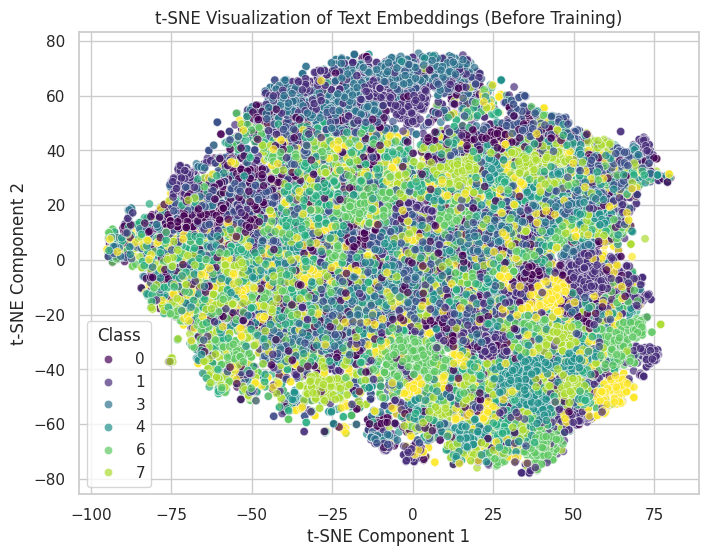

In [ ]:
# Reduce dimensions using t-SNE (Before training and after applying SMOTE)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=labels, palette="viridis", alpha=0.7)
plt.title("t-SNE Visualization of Text Embeddings (Before Training)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Class")
plt.show()

In [ ]:
learning_rate = 9e-4
num_epochs = 10
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-5)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
val_f1s = []

with tqdm(total=num_epochs, desc="Training Progress", unit="epoch") as pbar:
    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1s.append(val_f1)

        end_time = time.time()
        epoch_duration = end_time - start_time

        pbar.set_description(
            f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
            f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F1: {val_f1:.2%}, Time: {epoch_duration / 60:.2f} min"
        )
        pbar.update(1)

Epoch 10/10 - Train Loss: 0.1993, Val Loss: 0.3132, Train Acc: 93.80%, Val Acc: 91.53%, Val F1: 91.59%, Time: 0.86 min: 100%|██████████| 10/10 [08:41<00:00, 52.13s/epoch]


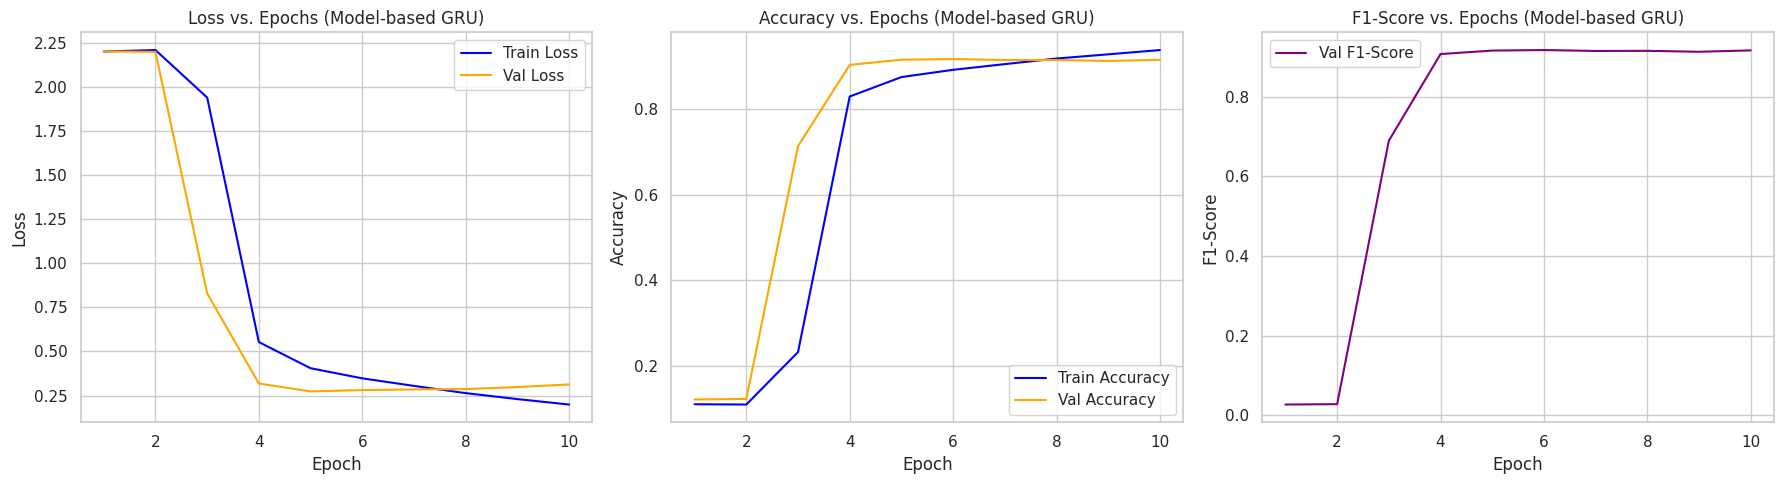

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st plot
sns.lineplot(x=range(1, len(train_losses) + 1), y=train_losses, label='Train Loss', color='blue')
sns.lineplot(x=range(1, len(val_losses) + 1), y=val_losses, label='Val Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs (Model-based GRU)')
plt.legend()

plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd plot
sns.lineplot(x=range(1, len(train_accuracies) + 1), y=train_accuracies, label='Train Accuracy', color='blue')
sns.lineplot(x=range(1, len(val_accuracies) + 1), y=val_accuracies, label='Val Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs (Model-based GRU)')
plt.legend()

plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd plot
sns.lineplot(x=range(1, len(val_f1s) + 1), y=val_f1s, label='Val F1-Score', color='purple')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('F1-Score vs. Epochs (Model-based GRU)')
plt.legend()

plt.tight_layout()
plt.show()

### Optimization phase

The choice of hyperparameters for the different models was based on an analysis of the results obtained from the reports generated by Weights & Biases (WandB). These reports were used to identify the best-performing configurations in terms of accuracy, F1-score and training stability

I.2.1 Optimizer selection

In [ ]:
num_epochs = 20
learning_rate = 9e-4
loss_function = torch.nn.CrossEntropyLoss()

optimizers = {
    'RMSprop': optim.RMSprop,
    'Adam': optim.Adam,
    'AdamW': optim.AdamW,
}

for optimizer_name, optimizer_class in optimizers.items():
    print(f"\n🔹 Training with optimizer: {optimizer_name}")

    model = GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, hidden_dim=350, num_layers=1,dropout_prob=0.4, embedding_weights=embedding_matrix, freeze_embeddings=False).to(device)
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)
    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge', project='Multi_Class_Optimizer_Comparison_gru_glove300d_SMOTE', name=f"{optimizer_name}_run", config={
        'learning_rate': learning_rate,
        'num_epochs': num_epochs,
        'optimizer': optimizer_name,
        'model': 'GRU_Model',
        'embedding_dim': 300,
        'hidden_dim': 350,
        'dropout_prob': 0.5
    })

    print(model)
    num_params = count_parameters(model)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    # Progress bar for training
    with tqdm(total=num_epochs, desc=f"Optimizer: {optimizer_name}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(f"Optimizer: {optimizer_name} | Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train ACC: {train_acc:.2%}, Val ACC: {val_acc:.2%}, Time: {epoch_duration / 60:.2f} min")
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1,
            })

    wandb.finish()


🔹 Training with optimizer: RMSprop


GRU_Model(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 350, batch_first=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=350, out_features=9, bias=True)
)
Total trainable parameters: 12688359


Optimizer: RMSprop | Epoch 20/20 - Train Loss: 0.0363, Val Loss: 0.4299, Train ACC: 98.75%, Val ACC: 90.48%, Time: 0.41 min: 100%|██████████| 20/20 [08:07<00:00, 24.36s/epoch]


train_acc,▁▁▁▁▁▁▁▆▇███████████
train_loss,███████▃▂▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▃█████████████
val_f1,▁▁▁▁▁▁▃█████████████
val_loss,██████▇▁▁▁▁▁▁▁▁▁▁▁▁▂
train_acc,0.98751
train_loss,0.03629
val_acc,0.90479
val_f1,0.90517
val_loss,0.4299



🔹 Training with optimizer: Adam


GRU_Model(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 350, batch_first=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=350, out_features=9, bias=True)
)
Total trainable parameters: 12688359


Optimizer: Adam | Epoch 20/20 - Train Loss: 0.0329, Val Loss: 0.4116, Train ACC: 98.72%, Val ACC: 91.38%, Time: 0.41 min: 100%|██████████| 20/20 [08:15<00:00, 24.75s/epoch]


train_acc,▁▁▁▁▁▁▁▃▇███████████
train_loss,███████▆▂▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁█████████████
val_f1,▁▁▁▁▁▁▁█████████████
val_loss,███████▁▁▁▁▁▁▁▁▁▁▂▂▂
train_acc,0.98725
train_loss,0.03288
val_acc,0.91376
val_f1,0.91409
val_loss,0.41158



🔹 Training with optimizer: AdamW


GRU_Model(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 350, batch_first=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=350, out_features=9, bias=True)
)
Total trainable parameters: 12688359


Optimizer: AdamW | Epoch 20/20 - Train Loss: 0.1186, Val Loss: 0.2861, Train ACC: 96.48%, Val ACC: 91.27%, Time: 0.42 min: 100%|██████████| 20/20 [08:17<00:00, 24.86s/epoch]


train_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▇███
train_loss,████████████████▂▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇████
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇████
val_loss,███████████████▂▁▁▁▁
train_acc,0.96478
train_loss,0.11863
val_acc,0.91273
val_f1,0.91323
val_loss,0.28607


---

I.2.2 Learning rate value selection

In [ ]:
learning_rates = [9-4, 8e-4, 7e-4]

for lr in learning_rates:
    print(f"\n🔹 Training with RMSprop and learning rate: {lr}")

    model = GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, hidden_dim=350, num_layers=1,dropout_prob=0.4, embedding_weights=embedding_matrix, freeze_embeddings=False).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge', project='Multi_Class_learning_rate_tuning_gru_glove300d_SMOTE', name=f"RMSprop_lr_{lr}", config={
        'learning_rate': lr,
        'num_epochs': num_epochs,
        'optimizer': 'RMPprop',
        'model': 'GRU_Model',
        'embedding_dim': 300,
        'hidden_dim': 350,
        'dropout_prob': 0.5
    })

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []
    with tqdm(total=num_epochs, desc=f"LR: {lr}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(f"LR: {lr} | Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train ACSA: {train_acc:.2%}, Val ACSA: {val_acc:.2%}, Time: {epoch_duration / 60:.2f} min")
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1
            })

    wandb.finish()


🔹 Training with RMSprop and learning rate: 5


LR: 5 | Epoch 20/20 - Train Loss: 394.2482, Val Loss: 285.3591, Train ACSA: 14.23%, Val ACSA: 15.75%, Time: 0.38 min: 100%|██████████| 20/20 [07:33<00:00, 22.67s/epoch]


train_acc,▁▅▇▇▇▇██▆▆▇▆▆▅▆▆▆▆▇▅
train_loss,█▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▂▅▇▄▇█▁▇▆▆█▂▆▁▃▄▄▅▆▅
val_f1,▄▅▅▃▆▆▄█▄▇█▁▅▁▄▅▆▆▅▅
val_loss,▆█▄▄▂▂▄▂▂▁▁▃▂▃▂▂▂▁▂▂
train_acc,0.1423
train_loss,394.24818
val_acc,0.15747
val_f1,0.11049
val_loss,285.35911



🔹 Training with RMSprop and learning rate: 0.0008


LR: 0.0008 | Epoch 20/20 - Train Loss: 0.0394, Val Loss: 0.3779, Train ACSA: 98.64%, Val ACSA: 91.13%, Time: 0.41 min: 100%|██████████| 20/20 [08:13<00:00, 24.67s/epoch]


train_acc,▁▁▁▁▁▁▁▁▁▁▁▁▆███████
train_loss,████████████▃▂▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁████████
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁████████
val_loss,▆▆▆▆▆▆▆▆▆▆▆█▁▁▁▁▁▁▁▁
train_acc,0.98644
train_loss,0.03936
val_acc,0.91135
val_f1,0.91153
val_loss,0.37785



🔹 Training with RMSprop and learning rate: 0.0007


LR: 0.0007 | Epoch 20/20 - Train Loss: 0.0414, Val Loss: 0.3880, Train ACSA: 98.51%, Val ACSA: 91.12%, Time: 0.41 min: 100%|██████████| 20/20 [08:12<00:00, 24.62s/epoch]


train_acc,▁▁▁▁▁▁▁▁▁▁▁▆████████
train_loss,███████████▃▂▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁▂█████████
val_f1,▁▁▁▁▁▁▁▁▁▁▂█████████
val_loss,███████████▁▁▁▁▁▁▁▁▁
train_acc,0.98507
train_loss,0.04138
val_acc,0.91118
val_f1,0.91134
val_loss,0.38795


---
RMSprop is selected as optimizer.

I.2.3 Hidden dimension value selection

In [ ]:
hidden_dims = [100, 250, 400]

for hidden_dim in hidden_dims:
    print(f"\n🔹 Training with hidden_dim: {hidden_dim}\n")
    run_name = f"GRU_Hidden_{hidden_dim}"

    model = GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, hidden_dim=hidden_dim, num_layers=1,dropout_prob=0.4, embedding_weights=embedding_matrix, freeze_embeddings=False).to(device)
    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project="Multi_Class_GRU-Hidden-Tuning-glove300d_SMOTE",
        name=run_name,
        config={
            "embedding_dim": EMBEDDING_DIM,
            "learning_rate": learning_rate,
            "epochs": num_epochs,
            "hidden_dim": 350,
            "dropout": 0.4,
            "optimizer": "RMSprop"
        }
    )

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    with tqdm(total=num_epochs, desc=f"Training with Hidden={hidden_dim}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with hidden_dim: 100



Epoch 20/20 - Train Loss: 2.1777, Val Loss: 2.1914, Train Acc: 12.98%, Val Acc: 12.30%, Val F-1: 3.15%,, Time: 0.11 min: 100%|██████████| 20/20 [02:04<00:00,  6.25s/epoch]


train_acc,▁▃▃▄▂▃▇▆▆▆▂▆▅▇▆▇▆▆▆█
train_loss,█▇▅▄▃▃▂▂▂▁▁▂▇▁▃▂▁▁▂▄
val_acc,▂▂▂▂█▂█▂▂█▂▂▇▁█▂▂▂▇▇
val_f1,▂▂▂▂▆▃▆▃▃▆▄▁▆▁▇▄▂▃▇█
val_loss,▂▁▃▁▂▄▃▇▄▆▆█▃▇▄▅▆▇▅▇
train_acc,0.12977
train_loss,2.1777
val_acc,0.12297
val_f1,0.03151
val_loss,2.19136



🔹 Training with hidden_dim: 250



Epoch 20/20 - Train Loss: 0.2321, Val Loss: 0.2831, Train Acc: 93.00%, Val Acc: 91.60%, Val F-1: 91.64%,, Time: 0.28 min: 100%|██████████| 20/20 [05:32<00:00, 16.62s/epoch]


train_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃██
train_loss,█████████████████▆▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁███
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁███
val_loss,█████████████████▂▁▁
train_acc,0.93003
train_loss,0.23207
val_acc,0.91601
val_f1,0.91641
val_loss,0.28309



🔹 Training with hidden_dim: 400



Epoch 20/20 - Train Loss: 0.0295, Val Loss: 0.4772, Train Acc: 98.78%, Val Acc: 90.93%, Val F-1: 90.90%,, Time: 0.46 min: 100%|██████████| 20/20 [09:07<00:00, 27.38s/epoch]


train_acc,▁▁▁▁▁▃▇█████████████
train_loss,█████▆▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁███████████████
val_f1,▁▁▁▁▁███████████████
val_loss,█████▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂
train_acc,0.9878
train_loss,0.02949
val_acc,0.90928
val_f1,0.90903
val_loss,0.47718


---
Hidden dimension value is set to 250.

I.2.4 Depth value selection

In [ ]:
depth_values = [1, 2, 3]

for num_layers in depth_values:
    print(f"\n🔹 Training with GRU Depth (num_layers): {num_layers}\n")
    run_name = f"GRU_Depth_{num_layers}"
    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project="Multi-Class-GRU-Depth-Tuning-glove300d_SMOTE",
        name=run_name,
        config={
            "num_layers": num_layers,
            "learning_rate": learning_rate,
            "hidden_dim":350,
            "dropout":0.4,
            "optimizer": "RMSprop"
        }
    )
    model = GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, hidden_dim=350, num_layers=1,dropout_prob=0.4, embedding_weights=embedding_matrix, freeze_embeddings=False).to(device)
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    with tqdm(total=num_epochs, desc=f"Training with GRU Depth={num_layers}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with GRU Depth (num_layers): 1



Epoch 20/20 - Train Loss: 0.0262, Val Loss: 0.4552, Train Acc: 98.87%, Val Acc: 91.29%, Val F-1: 91.27%,, Time: 0.41 min: 100%|██████████| 20/20 [08:07<00:00, 24.37s/epoch]


train_acc,▁▁▁▄▇███████████████
train_loss,███▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁█████████████████
val_f1,▁▁▁█████████████████
val_loss,███▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂
train_acc,0.98873
train_loss,0.02621
val_acc,0.9129
val_f1,0.91267
val_loss,0.45519



🔹 Training with GRU Depth (num_layers): 2



Epoch 20/20 - Train Loss: 0.0262, Val Loss: 0.5163, Train Acc: 98.75%, Val Acc: 90.89%, Val F-1: 90.83%,, Time: 0.41 min: 100%|██████████| 20/20 [08:09<00:00, 24.46s/epoch]


train_acc,▁▁▄▇████████████████
train_loss,██▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁██████████████████
val_f1,▁▁██████████████████
val_loss,██▁▁▁▁▁▁▁▁▁▁▂▁▂▂▂▂▂▂
train_acc,0.98754
train_loss,0.02618
val_acc,0.90893
val_f1,0.90829
val_loss,0.51632



🔹 Training with GRU Depth (num_layers): 3



Epoch 20/20 - Train Loss: 0.0396, Val Loss: 0.3888, Train Acc: 98.60%, Val Acc: 91.31%, Val F-1: 91.31%,, Time: 0.41 min: 100%|██████████| 20/20 [08:05<00:00, 24.28s/epoch]


train_acc,▁▁▁▁▁▁▁▁▃▄▇█████████
train_loss,███████▇▆▅▂▂▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▃▃▇██████████
val_f1,▁▁▁▁▁▁▁▃▃▇██████████
val_loss,███████▆▆▂▁▁▁▁▁▁▁▁▁▁
train_acc,0.98596
train_loss,0.03956
val_acc,0.91307
val_f1,0.91315
val_loss,0.38881


---
Depth value is set to 1.

I.2.5 Batch size value selection

In [ ]:
batch_sizes = [8, 16, 64]

for batch_size in batch_sizes:
    print(f"\n🔹 Training with batch size: {batch_size}")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

    model = GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, hidden_dim=250, num_layers=1,dropout_prob=0.3, embedding_weights=embedding_matrix, freeze_embeddings=False).to(device)
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project="Multi-Class-batch_size_comparison_gru_glove300d_SMOTE",
        name=f"GRU_Batch_{batch_size}",
        config={
            "batch_size": batch_size,
            "learning_rate": learning_rate,
            "num_epochs": num_epochs,
            "optimizer": "RMSprop",
            "hidden_dim": 250,
            "dropout_prob": 0.4
        }
    )

    print(model)
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    with tqdm(total=num_epochs, desc=f"Training with Embedding={hidden_dim}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with batch size: 8


GRU_Model(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 250, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=250, out_features=9, bias=True)
)
Total trainable parameters: 12416859


Epoch 20/20 - Train Loss: 0.0349, Val Loss: 0.5473, Train Acc: 98.70%, Val Acc: 91.13%, Val F-1: 91.13%,, Time: 1.12 min: 100%|██████████| 20/20 [22:22<00:00, 67.13s/epoch]


train_acc,▁▁▁▇████████████████
train_loss,███▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▆█████████████████
val_f1,▁▁▆█████████████████
val_loss,██▃▁▁▁▁▁▂▂▁▂▂▂▂▂▂▂▂▂
train_acc,0.98703
train_loss,0.03493
val_acc,0.91135
val_f1,0.91134
val_loss,0.54731



🔹 Training with batch size: 16


GRU_Model(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 250, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=250, out_features=9, bias=True)
)
Total trainable parameters: 12416859


Epoch 20/20 - Train Loss: 0.0303, Val Loss: 0.4973, Train Acc: 98.82%, Val Acc: 91.26%, Val F-1: 91.21%,, Time: 0.68 min: 100%|██████████| 20/20 [13:38<00:00, 40.92s/epoch]


train_acc,▁▁▁▁▄███████████████
train_loss,████▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁████████████████
val_f1,▁▁▁▁████████████████
val_loss,████▁▁▁▁▁▁▁▁▁▂▂▁▂▂▂▂
train_acc,0.98821
train_loss,0.03027
val_acc,0.91256
val_f1,0.91211
val_loss,0.49729



🔹 Training with batch size: 64


GRU_Model(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 250, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=250, out_features=9, bias=True)
)
Total trainable parameters: 12416859


Epoch 17/20 - Train Loss: 2.1723, Val Loss: 2.1912, Train Acc: 12.44%, Val Acc: 12.35%, Val F-1: 2.96%,, Time: 0.29 min:  85%|████████▌ | 17/20 [04:52<00:51, 17.31s/epoch]

---
Btach size value is set to 16.

---
## I.3 **SMOTE - GLOVE (Glove 300d) - Bahdanau Attention**

### Validation phase

In [ ]:
model = GloVe_GRU_BahdanauAttention(embedding_matrix=embedding_matrix, hidden_dim=200, num_layers=1, dropout_prob=0.8).to(device)
print(model)

num_params = count_parameters(model)
print(f"Total trainable parameters: {num_params}")

GloVe_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 200, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=400, out_features=200, bias=True)
    (v): Linear(in_features=200, out_features=1, bias=False)
  )
  (fc): Linear(in_features=400, out_features=9, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)
Total trainable parameters: 12687009


In [ ]:
learning_rate = 1e-4
num_epochs = 6
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-5)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
val_f1s = []

with tqdm(total=num_epochs, desc="Training Progress", unit="epoch") as pbar:
    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1s.append(val_f1)

        end_time = time.time()
        epoch_duration = end_time - start_time

        pbar.set_description(
            f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
            f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F1: {val_f1:.2%}, Time: {epoch_duration / 60:.2f} min"
        )
        pbar.update(1)

Epoch 6/6 - Train Loss: 0.3835, Val Loss: 0.2860, Train Acc: 88.13%, Val Acc: 91.46%, Val F1: 91.38%, Time: 0.94 min: 100%|██████████| 6/6 [06:42<00:00, 67.07s/epoch]


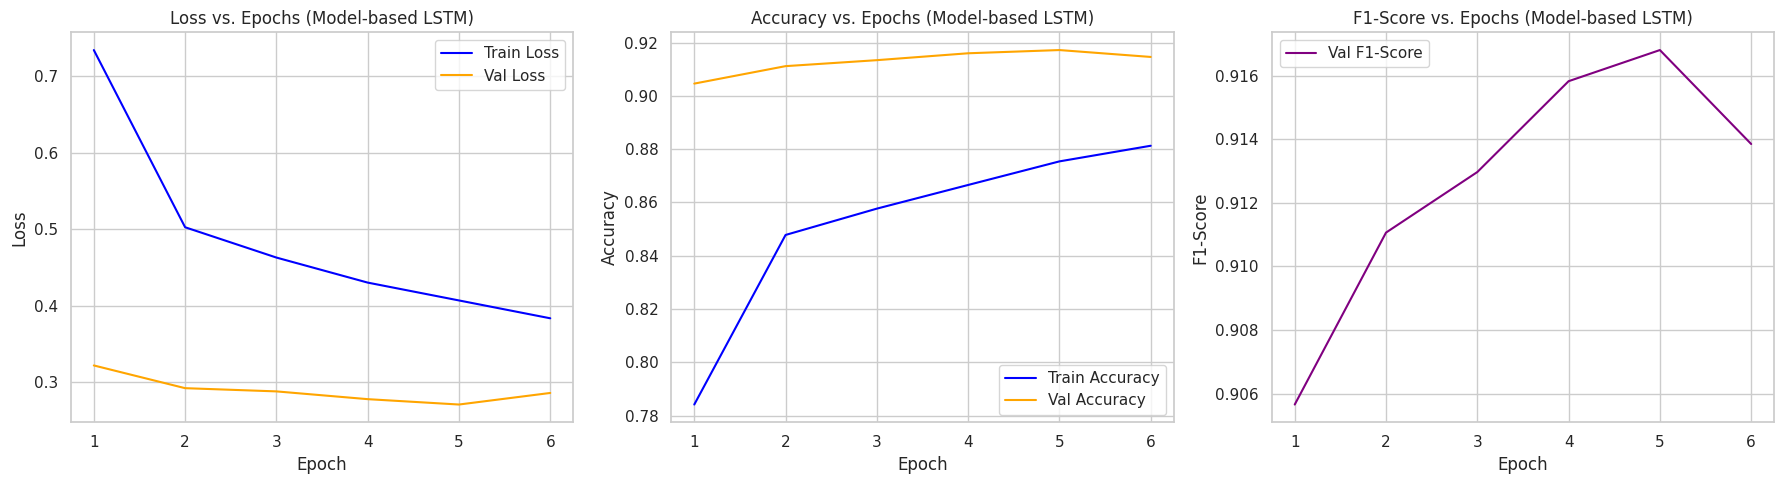

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st plot
sns.lineplot(x=range(1, len(train_losses) + 1), y=train_losses, label='Train Loss', color='blue')
sns.lineplot(x=range(1, len(val_losses) + 1), y=val_losses, label='Val Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs (Model-based LSTM)')
plt.legend()

plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd plot
sns.lineplot(x=range(1, len(train_accuracies) + 1), y=train_accuracies, label='Train Accuracy', color='blue')
sns.lineplot(x=range(1, len(val_accuracies) + 1), y=val_accuracies, label='Val Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs (Model-based LSTM)')
plt.legend()

plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd plot
sns.lineplot(x=range(1, len(val_f1s) + 1), y=val_f1s, label='Val F1-Score', color='purple')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('F1-Score vs. Epochs (Model-based LSTM)')
plt.legend()

plt.tight_layout()
plt.show()

### Optimization phase

I.3.1 Optimizer selection

In [ ]:
learning_rate = 1e-4
loss_function = torch.nn.CrossEntropyLoss()

optimizers = {
    'RMSprop': optim.RMSprop,
    'Adam': optim.Adam,
    'AdamW': optim.AdamW,
}

for optimizer_name, optimizer_class in optimizers.items():
    print(f"\n🔹 Training with optimizer: {optimizer_name}")

    model = GloVe_GRU_BahdanauAttention(embedding_matrix=embedding_matrix, hidden_dim=200, num_layers=1, dropout_prob=0.8).to(device)
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)
    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge', project='Multi_Class_Optimizer_Comparison_gru_glove300d_Attention_SMOTE', name=f"{optimizer_name}_run", config={
        'learning_rate': learning_rate,
        'num_epochs': num_epochs,
        'optimizer': optimizer_name,
        'model': 'GRU_Model',
        'embedding_dim': 300,
        'hidden_dim': 200,
        'dropout_prob': 0.5
    })

    print(model)
    num_params = count_parameters(model)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    # Progress bar for training
    with tqdm(total=num_epochs, desc=f"Optimizer: {optimizer_name}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(f"Optimizer: {optimizer_name} | Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train ACC: {train_acc:.2%}, Val ACC: {val_acc:.2%}, Time: {epoch_duration / 60:.2f} min")
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1,
            })

    wandb.finish()


🔹 Training with optimizer: RMSprop


GloVe_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 200, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=400, out_features=200, bias=True)
    (v): Linear(in_features=200, out_features=1, bias=False)
  )
  (fc): Linear(in_features=400, out_features=9, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)
Total trainable parameters: 12687009


Optimizer: RMSprop | Epoch 6/6 - Train Loss: 0.2201, Val Loss: 0.2705, Train ACC: 93.66%, Val ACC: 92.03%, Time: 0.85 min: 100%|██████████| 6/6 [05:16<00:00, 52.74s/epoch]


train_acc,▁▆▇▇██
train_loss,█▃▂▂▁▁
val_acc,▁▂▇▇██
val_f1,▁▃▇▇██
val_loss,█▅▃▁▃▂
train_acc,0.93658
train_loss,0.2201
val_acc,0.92032
val_f1,0.91999
val_loss,0.27054



🔹 Training with optimizer: Adam


GloVe_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 200, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=400, out_features=200, bias=True)
    (v): Linear(in_features=200, out_features=1, bias=False)
  )
  (fc): Linear(in_features=400, out_features=9, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)
Total trainable parameters: 12687009


Optimizer: Adam | Epoch 6/6 - Train Loss: 0.2009, Val Loss: 0.2737, Train ACC: 94.13%, Val ACC: 92.01%, Time: 0.88 min: 100%|██████████| 6/6 [05:15<00:00, 52.62s/epoch]


train_acc,▁▇▇▇██
train_loss,█▂▂▂▁▁
val_acc,▁▄▆▇▇█
val_f1,▁▄▆▇▇█
val_loss,█▄▁▂▂▁
train_acc,0.94131
train_loss,0.20094
val_acc,0.92014
val_f1,0.91997
val_loss,0.27375



🔹 Training with optimizer: AdamW


GloVe_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 200, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=400, out_features=200, bias=True)
    (v): Linear(in_features=200, out_features=1, bias=False)
  )
  (fc): Linear(in_features=400, out_features=9, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)
Total trainable parameters: 12687009


Optimizer: AdamW | Epoch 6/6 - Train Loss: 0.1983, Val Loss: 0.2804, Train ACC: 94.43%, Val ACC: 92.03%, Time: 0.89 min: 100%|██████████| 6/6 [05:20<00:00, 53.38s/epoch]


train_acc,▁▇▇▇██
train_loss,█▂▂▂▁▁
val_acc,▁▃▇▆▇█
val_f1,▁▃▇▆▇█
val_loss,█▂▁▁▁▂
train_acc,0.9443
train_loss,0.19828
val_acc,0.92032
val_f1,0.92023
val_loss,0.28036


---
Adam is selected as optimizer.

I.3.2 Learning rate value selection

In [ ]:
learning_rates = [9e-5, 7e-5, 8e-5]

for lr in learning_rates:
    print(f"\n🔹 Training with RMSprop and learning rate: {lr}")

    model = GloVe_GRU_BahdanauAttention(embedding_matrix=embedding_matrix, hidden_dim=200, num_layers=1, dropout_prob=0.8).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge', project='Multi_Class_learning_rate_tuning_gru_glove300d_Attention_SMOTE', name=f"RMSprop_lr_{lr}", config={
        'learning_rate': lr,
        'num_epochs': num_epochs,
        'optimizer': 'RMPprop',
        'model': 'GRU_Model',
        'embedding_dim': 300,
        'hidden_dim': 200,
        'dropout_prob': 0.5
    })

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []
    with tqdm(total=num_epochs, desc=f"LR: {lr}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(f"LR: {lr} | Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train ACSA: {train_acc:.2%}, Val ACSA: {val_acc:.2%}, Time: {epoch_duration / 60:.2f} min")
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1
            })

    wandb.finish()


🔹 Training with RMSprop and learning rate: 9e-05


LR: 9e-05 | Epoch 6/6 - Train Loss: 0.2166, Val Loss: 0.2705, Train ACSA: 93.70%, Val ACSA: 92.07%, Time: 0.90 min: 100%|██████████| 6/6 [05:23<00:00, 53.95s/epoch]


train_acc,▁▇▇███
train_loss,█▂▂▁▁▁
val_acc,▁▃▅█▇█
val_f1,▁▃▅█▇█
val_loss,█▆▃▂▃▁
train_acc,0.93698
train_loss,0.21655
val_acc,0.92066
val_f1,0.92036
val_loss,0.27049



🔹 Training with RMSprop and learning rate: 7e-05


LR: 7e-05 | Epoch 6/6 - Train Loss: 0.2293, Val Loss: 0.2675, Train ACSA: 93.27%, Val ACSA: 91.95%, Time: 0.90 min: 100%|██████████| 6/6 [05:23<00:00, 53.84s/epoch]


train_acc,▁▇▇███
train_loss,█▂▂▁▁▁
val_acc,▁▅▆▆▇█
val_f1,▁▅▆▆▇█
val_loss,█▅▃▁▂▁
train_acc,0.93266
train_loss,0.2293
val_acc,0.91945
val_f1,0.91921
val_loss,0.26755



🔹 Training with RMSprop and learning rate: 8e-05


LR: 8e-05 | Epoch 6/6 - Train Loss: 0.2200, Val Loss: 0.2746, Train ACSA: 93.53%, Val ACSA: 91.89%, Time: 0.90 min: 100%|██████████| 6/6 [05:22<00:00, 53.79s/epoch]


train_acc,▁▇▇███
train_loss,█▂▂▂▁▁
val_acc,▁▅▇▇█▇
val_f1,▁▅▇▇██
val_loss,█▃▂▁▁▁
train_acc,0.93532
train_loss,0.22002
val_acc,0.91894
val_f1,0.91889
val_loss,0.27465


---
Learning rate value is set to $10^{-4}$.

I.3.3 Hidden dimension value selection

In [ ]:
hidden_dims = [100, 250, 400]
learning_rate = 1e-4

for hidden_dim in hidden_dims:
    print(f"\n🔹 Training with hidden_dim: {hidden_dim}\n")
    run_name = f"GRU_Hidden_{hidden_dim}"

    model = GloVe_GRU_BahdanauAttention(embedding_matrix=embedding_matrix, hidden_dim=200, num_layers=1, dropout_prob=0.8).to(device)
    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project="Multi_Class_GRU-Hidden-Tuning-glove300d_Attention_SMOTE",
        name=run_name,
        config={
            "embedding_dim": EMBEDDING_DIM,
            "learning_rate": learning_rate,
            "epochs": num_epochs,
            "hidden_dim": 200,
            "dropout": 0.4,
            "optimizer": "RMSprop"
        }
    )

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    with tqdm(total=num_epochs, desc=f"Training with Hidden={hidden_dim}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with hidden_dim: 100



Epoch 6/6 - Train Loss: 0.2305, Val Loss: 0.2706, Train Acc: 93.35%, Val Acc: 92.03%, Val F-1: 92.00%,, Time: 0.87 min: 100%|██████████| 6/6 [05:11<00:00, 51.89s/epoch]


train_acc,▁▆▇▇██
train_loss,█▂▂▂▁▁
val_acc,▁▄▃▅▅█
val_f1,▁▄▃▆▆█
val_loss,█▃▁▂▁▁
train_acc,0.93355
train_loss,0.23046
val_acc,0.92032
val_f1,0.92002
val_loss,0.27055



🔹 Training with hidden_dim: 250



Epoch 6/6 - Train Loss: 0.2316, Val Loss: 0.2747, Train Acc: 93.38%, Val Acc: 91.82%, Val F-1: 91.81%,, Time: 0.87 min: 100%|██████████| 6/6 [05:16<00:00, 52.69s/epoch]


train_acc,▁▆▇▇██
train_loss,█▂▂▂▁▁
val_acc,▁▅▆██▇
val_f1,▁▅▆███
val_loss,█▄▃▁▁▂
train_acc,0.93384
train_loss,0.23162
val_acc,0.91825
val_f1,0.9181
val_loss,0.27467



🔹 Training with hidden_dim: 400



Epoch 6/6 - Train Loss: 0.2253, Val Loss: 0.2790, Train Acc: 93.47%, Val Acc: 92.07%, Val F-1: 92.01%,, Time: 0.88 min: 100%|██████████| 6/6 [05:15<00:00, 52.65s/epoch]


train_acc,▁▆▇▇██
train_loss,█▃▂▂▁▁
val_acc,▁▂▆▅▆█
val_f1,▁▂▆▄▆█
val_loss,█▄▂▂▁▂
train_acc,0.93469
train_loss,0.22529
val_acc,0.92066
val_f1,0.92007
val_loss,0.27902


---
Hidden dimnension value is set to 200.

I.3.4 Depth value selection

In [ ]:
depth_values = [1, 2, 3]

for num_layers in depth_values:
    print(f"\n🔹 Training with GRU Depth (num_layers): {num_layers}\n")
    run_name = f"GRU_Depth_{num_layers}"
    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project="Multi-Class-GRU-Depth-Tuning-glove300d_Attention_SMOTE",
        name=run_name,
        config={
            "num_layers": num_layers,
            "learning_rate": learning_rate,
            "hidden_dim":200,
            "dropout":0.8,
            "optimizer": "RMSprop"
        }
    )
    model = GloVe_GRU_BahdanauAttention(embedding_matrix=embedding_matrix, hidden_dim=200, num_layers=1, dropout_prob=0.8).to(device)
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    with tqdm(total=num_epochs, desc=f"Training with GRU Depth={num_layers}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with GRU Depth (num_layers): 1



Epoch 6/6 - Train Loss: 0.2310, Val Loss: 0.2792, Train Acc: 93.35%, Val Acc: 91.82%, Val F-1: 91.82%,, Time: 0.87 min: 100%|██████████| 6/6 [05:17<00:00, 52.84s/epoch]


train_acc,▁▆▇▇██
train_loss,█▂▂▂▁▁
val_acc,▁▄▆▇█▆
val_f1,▁▄▆▇█▆
val_loss,█▅▂▁▃▄
train_acc,0.93351
train_loss,0.231
val_acc,0.91825
val_f1,0.91821
val_loss,0.27924



🔹 Training with GRU Depth (num_layers): 2



Epoch 6/6 - Train Loss: 0.2315, Val Loss: 0.2716, Train Acc: 93.24%, Val Acc: 92.05%, Val F-1: 92.03%,, Time: 0.90 min: 100%|██████████| 6/6 [05:17<00:00, 52.97s/epoch]


train_acc,▁▆▇▇██
train_loss,█▃▂▂▁▁
val_acc,▁▄▆▇█▇
val_f1,▁▄▅▆█▇
val_loss,█▅▂▂▁▂
train_acc,0.93244
train_loss,0.2315
val_acc,0.92049
val_f1,0.92033
val_loss,0.27161



🔹 Training with GRU Depth (num_layers): 3



Epoch 6/6 - Train Loss: 0.2319, Val Loss: 0.2672, Train Acc: 93.24%, Val Acc: 92.15%, Val F-1: 92.12%,, Time: 0.93 min: 100%|██████████| 6/6 [05:26<00:00, 54.38s/epoch]


train_acc,▁▆▇▇██
train_loss,█▂▂▂▁▁
val_acc,▁▃▇▇██
val_f1,▁▄▇▇██
val_loss,█▅▃▁▂▁
train_acc,0.93244
train_loss,0.23185
val_acc,0.92152
val_f1,0.92125
val_loss,0.26716


---
Depth value is set to 2.

I.3.5 Batch size value selection

In [ ]:
batch_sizes = [8, 16, 64]

for batch_size in batch_sizes:
    print(f"\n🔹 Training with batch size: {batch_size}")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

    GloVe_GRU_BahdanauAttention(embedding_matrix=embedding_matrix, hidden_dim=200, num_layers=1, dropout_prob=0.8).to(device)
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project="Multi-Class-batch_size_comparison_gru_glove300d_Attention_SMOTE",
        name=f"GRU_Batch_{batch_size}",
        config={
            "batch_size": batch_size,
            "learning_rate": learning_rate,
            "num_epochs": num_epochs,
            "optimizer": "RMSprop",
            "hidden_dim": 200,
            "dropout_prob": 0.8
        }
    )

    print(model)
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    with tqdm(total=num_epochs, desc=f"Training with Embedding={hidden_dim}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with batch size: 8


GloVe_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 200, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=400, out_features=200, bias=True)
    (v): Linear(in_features=200, out_features=1, bias=False)
  )
  (fc): Linear(in_features=400, out_features=9, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)
Total trainable parameters: 12687009


Epoch 6/6 - Train Loss: 0.1252, Val Loss: 0.3848, Train Acc: 96.89%, Val Acc: 91.91%, Val F-1: 91.91%,, Time: 1.96 min: 100%|██████████| 6/6 [11:12<00:00, 112.04s/epoch]


train_acc,▁▂▄▆▇█
train_loss,█▇▅▄▂▁
val_acc,██▆▇▁▆
val_f1,██▆▇▁▆
val_loss,▁▂▄▃█▇
train_acc,0.96888
train_loss,0.12519
val_acc,0.91911
val_f1,0.91906
val_loss,0.38479



🔹 Training with batch size: 16


GloVe_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 200, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=400, out_features=200, bias=True)
    (v): Linear(in_features=200, out_features=1, bias=False)
  )
  (fc): Linear(in_features=400, out_features=9, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)
Total trainable parameters: 12687009


Epoch 6/6 - Train Loss: 0.0557, Val Loss: 0.4684, Train Acc: 98.28%, Val Acc: 90.81%, Val F-1: 90.83%,, Time: 1.12 min: 100%|██████████| 6/6 [07:11<00:00, 71.98s/epoch]


train_acc,▁▃▅▆██
train_loss,█▅▄▃▂▁
val_acc,▄▃█▃▃▁
val_f1,▄▃█▃▃▁
val_loss,▁▄▂▄██
train_acc,0.98281
train_loss,0.05567
val_acc,0.90807
val_f1,0.90831
val_loss,0.46839



🔹 Training with batch size: 64


GloVe_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 200, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=400, out_features=200, bias=True)
    (v): Linear(in_features=200, out_features=1, bias=False)
  )
  (fc): Linear(in_features=400, out_features=9, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)
Total trainable parameters: 12687009


Epoch 6/6 - Train Loss: 0.0336, Val Loss: 0.4493, Train Acc: 98.73%, Val Acc: 90.93%, Val F-1: 90.95%,, Time: 0.46 min: 100%|██████████| 6/6 [02:40<00:00, 26.78s/epoch]


train_acc,▁▃▄▇█▆
train_loss,█▅▄▂▁▁
val_acc,█▂▅▁▇▄
val_f1,█▃▆▁▆▄
val_loss,█▁▂▆▆▃
train_acc,0.98732
train_loss,0.03362
val_acc,0.90928
val_f1,0.90947
val_loss,0.44928


---

---
# II. **Weighted Training**

---

**Weighted training** involves assigning different weights to the classes in a loss function when training a model, in order to compensate for the imbalance between classes. In unbalanced datasets, where certain classes are under-represented, the aim is to make errors on minority classes more costly for the model. This allows the model to pay more attention to these under-represented classes, which generally improves its ability to predict these classes correctly. Weights are usually calculated as a function of class frequency, and these weights are incorporated into the loss function, such as CrossEntropyLoss in PyTorch. This helps to balance the impact of different classes on training, without the need to generate new data or modify the training set.

In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_tensor.cpu().numpy()), y=y_train_tensor.cpu().numpy())
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
loss_function = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [ ]:
batch_size = 16
train_dataset = TextDataset(X_train_tensor, y_train_tensor, raw_text_data=X_train)
val_dataset = TextDataset(X_val_tensor, y_val, raw_text_data=X_val)
test_dataset = TextDataset(X_test_tensor, y_test, raw_text_data=X_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 27056
Validation set size: 5798
Test set size: 5798


<ipython-input-8-35ba822a06f8>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
<ipython-input-8-35ba822a06f8>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)


---

## II.1 **Weighted Training - CNN-LSTM**

### Validation phase

In [ ]:
model = CNN_LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=320, hidden_dim=200, num_layers=1, dropout_prob=0.3).to(device)

print(model)
num_params = count_parameters(model)
print()
print(f"Total trainable parameters: {num_params}")

CNN_LSTM_Model(
  (embedding): Embedding(40002, 320)
  (conv1): Conv1d(320, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(100, 200, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=200, out_features=9, bias=True)
)

Total trainable parameters: 13170249


In [ ]:
optimizer = optim.RMSprop(model.parameters(), lr=1e-3)
num_epochs = 10

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
val_f1s = []

with tqdm(total=num_epochs, desc="Training Progress", unit="epoch") as pbar:
    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1s.append(val_f1)

        end_time = time.time()
        epoch_duration = end_time - start_time

        pbar.set_description(
            f"Epoch {epoch+1}/10 - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
            f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F1: {val_f1:.2%}, Time: {epoch_duration / 60:.2f} min"
        )
        pbar.update(1)

Epoch 10/10 - Train Loss: 0.1393, Val Loss: 0.4133, Train Acc: 96.30%, Val Acc: 89.94%, Val F1: 89.98%, Time: 0.45 min: 100%|██████████| 10/10 [04:32<00:00, 27.22s/epoch]


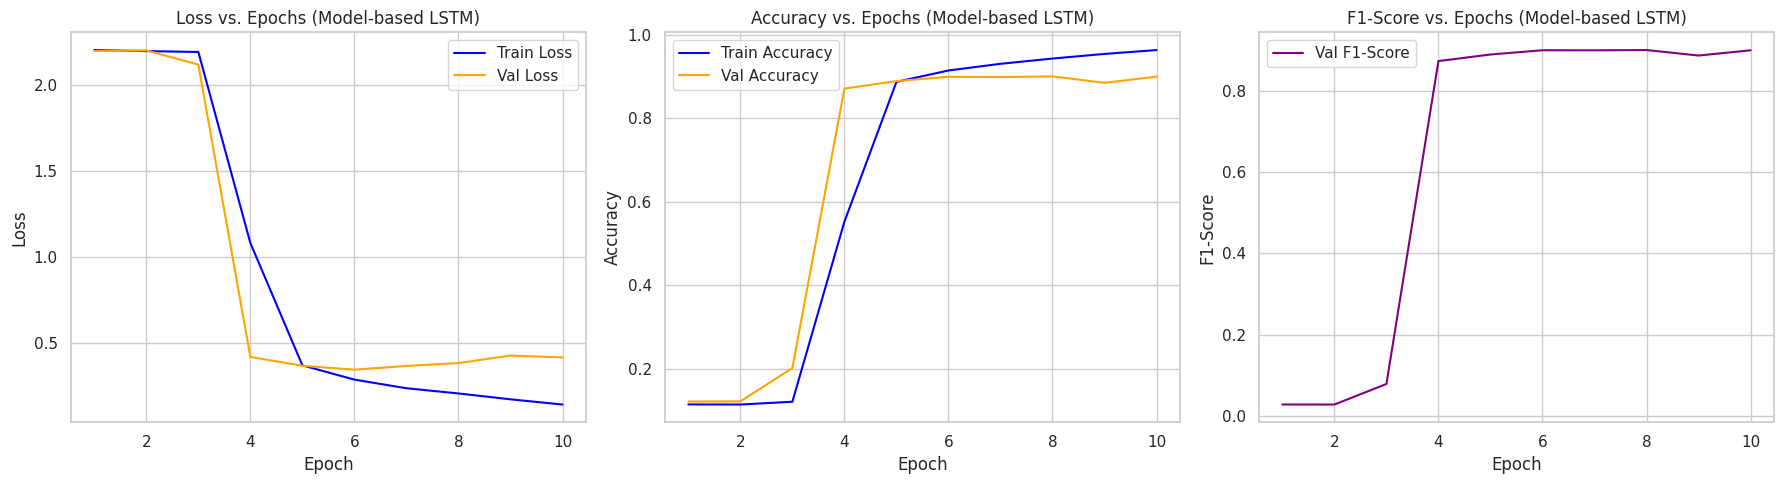

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st plot
sns.lineplot(x=range(1, len(train_losses) + 1), y=train_losses, label='Train Loss', color='blue')
sns.lineplot(x=range(1, len(val_losses) + 1), y=val_losses, label='Val Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs (Model-based LSTM)')
plt.legend()

plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd plot
sns.lineplot(x=range(1, len(train_accuracies) + 1), y=train_accuracies, label='Train Accuracy', color='blue')
sns.lineplot(x=range(1, len(val_accuracies) + 1), y=val_accuracies, label='Val Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs (Model-based LSTM)')
plt.legend()

plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd plot
sns.lineplot(x=range(1, len(val_f1s) + 1), y=val_f1s, label='Val F1-Score', color='purple')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('F1-Score vs. Epochs (Model-based LSTM)')
plt.legend()

plt.tight_layout()
plt.show()

### Optimization phase

II.1.1 Optimizer selection

In [ ]:
num_epochs = 20
learning_rate = 1e-3

optimizers = {
    'Adam': optim.Adam,
    'RMSprop': optim.RMSprop,
    'AdamW': optim.AdamW,
}

for optimizer_name, optimizer_class in optimizers.items():
    print(f"\n🔹 Training with optimizer: {optimizer_name}")

    model = CNN_LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=300, hidden_dim=200, num_layers=1, dropout_prob=0.5).to(device)
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)

    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge', project='Multi_Class_Optimizer_Tuning_cnn_lstm_Weighted_Training', name=f"{optimizer_name}_run", config={
        'learning_rate': learning_rate,
        'num_epochs': num_epochs,
        'optimizer': optimizer_name,
        'model': 'CNN_LSTM_Model',
        'embedding_dim': 128,
        'hidden_dim': 167,
        'dropout_prob': 0.5
    })

    print(model)
    num_params = count_parameters(model)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    # Progress bar for training
    with tqdm(total=num_epochs, desc=f"Optimizer: {optimizer_name}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(f"Optimizer: {optimizer_name} | Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train ACC: {train_acc:.2%}, Val ACC: {val_acc:.2%}, Time: {epoch_duration / 60:.2f} min")
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1,
            })

    wandb.finish()


🔹 Training with optimizer: Adam


CNN_LSTM_Model(
  (embedding): Embedding(40002, 300)
  (conv1): Conv1d(300, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(100, 200, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=200, out_features=9, bias=True)
)
Total trainable parameters: 12364209


Optimizer: Adam | Epoch 20/20 - Train Loss: 0.6505, Val Loss: 0.7925, Train ACC: 71.56%, Val ACC: 70.04%, Time: 0.22 min: 100%|██████████| 20/20 [04:23<00:00, 13.19s/epoch]


train_acc,▁▁▁▁▁▁▁▁▁▁▂▃▅▅▅▆▇▇▇█
train_loss,██████████▇▆▄▄▃▃▂▂▂▁
val_acc,▁▁▁▁▁▁▁▁▁▂▃▄▅▆▆▇▇▇▇█
val_f1,▁▁▁▁▁▁▁▁▁▂▃▄▅▅▆▆▇▇██
val_loss,██████████▅▅▃▃▃▂▂▂▁▁
train_acc,0.71559
train_loss,0.65051
val_acc,0.70041
val_f1,0.64992
val_loss,0.79251



🔹 Training with optimizer: RMSprop


CNN_LSTM_Model(
  (embedding): Embedding(40002, 300)
  (conv1): Conv1d(300, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(100, 200, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=200, out_features=9, bias=True)
)
Total trainable parameters: 12364209


Optimizer: RMSprop | Epoch 20/20 - Train Loss: 0.0619, Val Loss: 0.5204, Train ACC: 98.22%, Val ACC: 89.86%, Time: 0.21 min: 100%|██████████| 20/20 [04:12<00:00, 12.62s/epoch]


train_acc,▁▁▁▄▇▇▇█████████████
train_loss,███▅▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▇████████████████
val_f1,▁▁▂▇████████████████
val_loss,███▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
train_acc,0.98219
train_loss,0.0619
val_acc,0.89859
val_f1,0.89842
val_loss,0.52037



🔹 Training with optimizer: AdamW


CNN_LSTM_Model(
  (embedding): Embedding(40002, 300)
  (conv1): Conv1d(300, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(100, 200, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=200, out_features=9, bias=True)
)
Total trainable parameters: 12364209


Optimizer: AdamW | Epoch 20/20 - Train Loss: 0.4740, Val Loss: 0.6085, Train ACC: 80.77%, Val ACC: 76.99%, Time: 0.21 min: 100%|██████████| 20/20 [04:20<00:00, 13.03s/epoch]


train_acc,▁▁▁▁▁▁▁▁▁▁▁▃▅▅▆▆▆▇▇█
train_loss,███████████▆▄▄▃▃▃▂▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁▂▅▆▆▆▅▇▇▇█
val_f1,▁▁▁▁▁▁▁▁▁▁▁▄▆▆▆▅▇▇▇█
val_loss,██████████▇▄▃▃▃▃▂▂▂▁
train_acc,0.80766
train_loss,0.474
val_acc,0.76992
val_f1,0.74177
val_loss,0.60849


---
Adam optimizer is selected.

II.1.2 Learning rate value selection

In [ ]:
learning_rates = [8e-4, 1e-3, 7e-4]

for lr in learning_rates:
    print(f"\n🔹 Training with RMSprop and learning rate: {lr}")

    model = CNN_LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=300, hidden_dim=200, num_layers=1, dropout_prob=0.5).to(device)
    optimizer = optim.RMSprop(model.parameters(), lr=lr)

    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge', project='Multi_Class_learning_rate_Tuning_cnn_lstm_Weighted_Training', name=f"RMSprop_lr_{lr}", config={
        'learning_rate': lr,
        'num_epochs': num_epochs,
        'optimizer': 'RMSprop',
        'model': 'LSTM_CNN_Model',
        'embedding_dim': 250,
        'hidden_dim': 167,
        'dropout_prob': 0.5
    })

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []
    with tqdm(total=num_epochs, desc=f"LR: {lr}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(f"LR: {lr} | Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train ACSA: {train_acc:.2%}, Val ACSA: {val_acc:.2%}, Time: {epoch_duration / 60:.2f} min")
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1
            })

    wandb.finish()


🔹 Training with RMSprop and learning rate: 0.0008


LR: 0.0008 | Epoch 20/20 - Train Loss: 2.1800, Val Loss: 2.2175, Train ACSA: 12.27%, Val ACSA: 11.73%, Time: 0.20 min: 100%|██████████| 20/20 [03:57<00:00, 11.88s/epoch]


train_acc,▁▂▃▃▆▄▅▅█▃▆▂▇▅▅▅▅▄▅█
train_loss,█▆▆▅▄▃▃▅▂▂▂▂▂▂▂▂▂▁▁▁
val_acc,▇▁▇███▇█▇▇▁▇▁▇▂██▇█▇
val_f1,▅▁▅▅▅▅▅▆▅▅▁▅▂▅▄█▆▅▆▇
val_loss,▁▁▂▂▃▃▄▄▅▅▅▆█▆▅▇▇▇▇▆
train_acc,0.12271
train_loss,2.17996
val_acc,0.11728
val_f1,0.03572
val_loss,2.21754



🔹 Training with RMSprop and learning rate: 0.001


LR: 0.001 | Epoch 20/20 - Train Loss: 0.3816, Val Loss: 0.5033, Train ACSA: 84.29%, Val ACSA: 82.55%, Time: 0.20 min: 100%|██████████| 20/20 [03:59<00:00, 11.97s/epoch]


train_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▇████
train_loss,██████████████▆▃▂▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▂▅▇████
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▂▅▇████
val_loss,█████████████▇▄▁▁▁▁▁
train_acc,0.84292
train_loss,0.38158
val_acc,0.82546
val_f1,0.80072
val_loss,0.50333



🔹 Training with RMSprop and learning rate: 0.0007


LR: 0.0007 | Epoch 20/20 - Train Loss: 2.1813, Val Loss: 2.2194, Train ACSA: 12.26%, Val ACSA: 9.87%, Time: 0.20 min: 100%|██████████| 20/20 [03:57<00:00, 11.89s/epoch]


train_acc,▂▁▅▃▃▄█▆▇▇▆▇▄▅▇▅▄▃▇▇
train_loss,█▇▆▅▃▃▂▂▃▂▂▂▂▂▂▂▁▁▁▁
val_acc,█▆█▆█▁▆▆▆█▁▆▆▆▆▆▇▆▆▁
val_f1,▆▄▆▅▆▁▅▄▅▇█▅▅▅▅▅▇▇▅▅
val_loss,▁▁▁▂▄▃▄▅▄▄▄▅▆▇▆▇▇█▇█
train_acc,0.1226
train_loss,2.18134
val_acc,0.09865
val_f1,0.02593
val_loss,2.21943


---
Learning rate value is set to $9 \cdot 10^{-4}$.

II.1.3 Embedding dimension value selection

In [ ]:
embedding_dims = [100, 250, 320]
learning_rate = 9e-4

for embedding_dim in embedding_dims:
    print(f"\n🔹 Training with embedding_dim: {embedding_dim}\n")
    run_name = f"CNN_LSTM_Embedding_{embedding_dim}"
    model = CNN_LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=embedding_dim, hidden_dim=200, num_layers=1, dropout_prob=0.5).to(device)
    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project="Multi_Class_CNN_LSTM_Embedding_Tuning_Weighted_Training",
        name=run_name,
        config={
            "embedding_dim": embedding_dim,
            "learning_rate": learning_rate,
            "epochs": num_epochs,
            "hidden_dim": 167,
            "dropout": 0.5,
            "optimizer": "AdamW"
        }
    )

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    with tqdm(total=num_epochs, desc=f"Training with Embedding={embedding_dim}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with embedding_dim: 100



Epoch 20/20 - Train Loss: 0.7781, Val Loss: 0.8089, Train Acc: 67.68%, Val Acc: 63.44%, Val F-1: 59.08%,, Time: 0.15 min: 100%|██████████| 20/20 [03:03<00:00,  9.18s/epoch]


train_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▆▆▇██
train_loss,██████████████▆▃▃▂▁▁
val_acc,▂▂▂▂▁▂▂▂▂▁▁▂▂▂▅▆▆███
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▂▅▅▆███
val_loss,██████████████▃▃▂▁▁▁
train_acc,0.67678
train_loss,0.77809
val_acc,0.63436
val_f1,0.59077
val_loss,0.80886



🔹 Training with embedding_dim: 250



Epoch 20/20 - Train Loss: 0.3563, Val Loss: 0.5518, Train Acc: 84.67%, Val Acc: 77.27%, Val F-1: 74.12%,, Time: 0.19 min: 100%|██████████| 20/20 [03:43<00:00, 11.17s/epoch]


train_acc,▁▁▁▁▁▁▁▁▁▂▅▆▆▆▆▇▇▇▇█
train_loss,█████████▆▄▃▃▃▂▂▂▂▂▁
val_acc,▁▁▁▁▁▁▁▂▂▅▆▆▆▆▇█▇▇▇█
val_f1,▁▁▁▁▁▁▁▁▁▅▆▆▆▆▇▇▇▇▇█
val_loss,█████████▄▃▃▃▃▂▂▂▂▂▁
train_acc,0.84665
train_loss,0.35627
val_acc,0.77268
val_f1,0.74118
val_loss,0.55175



🔹 Training with embedding_dim: 320



Epoch 20/20 - Train Loss: 2.1853, Val Loss: 2.2099, Train Acc: 12.09%, Val Acc: 12.23%, Val F-1: 3.33%,, Time: 0.20 min: 100%|██████████| 20/20 [04:02<00:00, 12.15s/epoch]


train_acc,▁▄▂▅▄▄▅▅▂▇▅█▇▅▇▄▆█▇▇
train_loss,█▆▆▅▃▂▂▁█▄▃▁▂▆▁▁▁▁▃▂
val_acc,▇█▆▁█▇▆█▆▁▆█▆▇▆▆▁█▃█
val_f1,▃▃▂▁▃▃▃▃▃▂▂▃▃▅▃▃▁▃█▄
val_loss,▁▁▁▁▁▂▁▂▂▂▂▂▂▁▂▂▂▂█▂
train_acc,0.12086
train_loss,2.18534
val_acc,0.12228
val_f1,0.03331
val_loss,2.20992


---
Embedding dimension value is set to 250.

II.2.4 Depth value selection

In [ ]:
depth_values = [1, 2, 3]

for num_layers in depth_values:
    print(f"\n🔹 Training with CNN-LSTM Depth (num_layers): {num_layers}\n")

    run_name = f"CNN_LSTM_Depth_{num_layers}"
    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project="Multi-Class-CNN-LSTM-Depth-Tuning_Weighted_Training",
        name=run_name,
        config={
            "num_layers": num_layers,
            "learning_rate": learning_rate,
            "hidden_dim":167,
            "dropout":0.5,
            "optimizer": "AdamW"
        }
    )
    model = CNN_LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=300, hidden_dim=167, num_layers=num_layers, dropout_prob=0.3).to(device)
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    with tqdm(total=num_epochs, desc=f"Training with CNN-LSTM Depth={num_layers}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with CNN-LSTM Depth (num_layers): 1



Epoch 20/20 - Train Loss: 0.0518, Val Loss: 0.4623, Train Acc: 98.28%, Val Acc: 89.32%, Val F-1: 89.36%,, Time: 0.35 min: 100%|██████████| 20/20 [07:04<00:00, 21.22s/epoch]


train_acc,▁▁▁▁▂▆▇▇████████████
train_loss,████▇▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▄███████████████
val_f1,▁▁▁▁▃███████████████
val_loss,████▄▁▁▁▁▁▁▁▁▁▂▁▂▂▁▂
train_acc,0.98278
train_loss,0.05177
val_acc,0.89324
val_f1,0.8936
val_loss,0.46227



🔹 Training with CNN-LSTM Depth (num_layers): 2



Epoch 20/20 - Train Loss: 0.1007, Val Loss: 0.4440, Train Acc: 97.31%, Val Acc: 89.63%, Val F-1: 89.75%,, Time: 0.60 min: 100%|██████████| 20/20 [11:54<00:00, 35.73s/epoch]


train_acc,▁▁▁▁▁▁▃▆▇▇▇█████████
train_loss,██████▅▃▂▂▂▂▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▂▅▇████████████
val_f1,▁▁▁▁▁▂▅▇████████████
val_loss,█████▇▃▂▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,0.97306
train_loss,0.10067
val_acc,0.89634
val_f1,0.89745
val_loss,0.44405



🔹 Training with CNN-LSTM Depth (num_layers): 3



Epoch 17/20 - Train Loss: 0.1384, Val Loss: 0.4063, Train Acc: 96.16%, Val Acc: 89.53%, Val F-1: 89.67%,, Time: 0.83 min:  85%|████████▌ | 17/20 [14:21<02:30, 50.29s/epoch]

---
Depth value is set to 1.

II.1.5 Batch size value selection

In [ ]:
batch_sizes = [8, 16, 64]

for batch_size in batch_sizes:
    print(f"\n🔹 Training with batch size: {batch_size}")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

    model = CNN_LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=300, hidden_dim=200, num_layers=1, dropout_prob=0.5).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project="Multi-Class-batch_size_cnn_lstm_Tuning_Weighted_Training",
        name=f"LSTM_Batch_{batch_size}",
        config={
            "batch_size": batch_size,
            "learning_rate": learning_rate,
            "num_epochs": num_epochs,
            "optimizer": "Adam",
            "hidden_dim": 200,
            "dropout_prob": 0.5
        }
    )

    print(model)
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    with tqdm(total=num_epochs, desc=f"Training with Embedding={embedding_dim}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with batch size: 8


CNN_LSTM_Model(
  (embedding): Embedding(40002, 300)
  (conv1): Conv1d(300, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(100, 200, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=200, out_features=9, bias=True)
)
Total trainable parameters: 12364209


Epoch 20/20 - Train Loss: 2.1839, Val Loss: 2.2186, Train Acc: 12.27%, Val Acc: 11.64%, Val F-1: 2.65%,, Time: 0.77 min: 100%|██████████| 20/20 [16:12<00:00, 48.60s/epoch]


train_acc,▂▂▁▅▆▅▅█▅▆▅▆█▇▆▇█▆▇▆
train_loss,█▇▆▅▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_acc,█▁██▂▇▇██▂▂▂▇▁▂▁█▂▂▂
val_f1,▆▁▆▆▄▇▅██▄▅▄▆▃▃▄▆▃▄▄
val_loss,▁▁▂▁▂▃▄▄▆▆▅▅▇▆▆███▇▇
train_acc,0.12271
train_loss,2.18387
val_acc,0.11642
val_f1,0.02652
val_loss,2.2186



🔹 Training with batch size: 16


CNN_LSTM_Model(
  (embedding): Embedding(40002, 300)
  (conv1): Conv1d(300, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(100, 200, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=200, out_features=9, bias=True)
)
Total trainable parameters: 12364209


Epoch 20/20 - Train Loss: 0.0981, Val Loss: 0.5947, Train Acc: 97.93%, Val Acc: 88.32%, Val F-1: 88.37%,, Time: 0.42 min: 100%|██████████| 20/20 [08:29<00:00, 25.46s/epoch]


train_acc,▁▁▁▁▅▇▇█████████████
train_loss,████▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▃████████████████
val_f1,▁▁▁▃████████████████
val_loss,███▇▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▂
train_acc,0.9793
train_loss,0.09809
val_acc,0.88324
val_f1,0.88374
val_loss,0.59467



🔹 Training with batch size: 64


CNN_LSTM_Model(
  (embedding): Embedding(40002, 300)
  (conv1): Conv1d(300, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(100, 200, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=200, out_features=9, bias=True)
)
Total trainable parameters: 12364209


Epoch 20/20 - Train Loss: 0.0623, Val Loss: 0.5129, Train Acc: 98.32%, Val Acc: 89.22%, Val F-1: 89.23%,, Time: 0.20 min: 100%|██████████| 20/20 [03:59<00:00, 11.98s/epoch]


train_acc,▁▁▁▁▂▅▇▇████████████
train_loss,████▇▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▂▅▇██████████████
val_f1,▁▁▁▁▅▆██████████████
val_loss,███▇▄▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂
train_acc,0.98318
train_loss,0.06229
val_acc,0.8922
val_f1,0.89229
val_loss,0.51293


---
Batch size value is set to 16.

---

## II.2 **Weighted Training - GRU (Glove 300d)**

### Validation phase

In [ ]:
model = GRU_Model(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=280,
    num_layers=1,
    dropout_prob=0.5,
    embedding_weights=embedding_matrix,
    freeze_embeddings=False
).to(device)

print(model)
num_params = count_parameters(model)
print()
print(f"Total trainable parameters: {num_params}")

GRU_Model(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 280, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=280, out_features=9, bias=True)
)

Total trainable parameters: 12492009


In [ ]:
learning_rate = 1e-3
num_epochs = 10
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
val_f1s = []

with tqdm(total=num_epochs, desc="Training Progress", unit="epoch") as pbar:
    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1s.append(val_f1)

        end_time = time.time()
        epoch_duration = end_time - start_time

        pbar.set_description(
            f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
            f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F1: {val_f1:.2%}, Time: {epoch_duration / 60:.2f} min"
        )
        pbar.update(1)

Epoch 10/10 - Train Loss: 0.0610, Val Loss: 0.3965, Train Acc: 98.31%, Val Acc: 91.82%, Val F1: 91.82%, Time: 0.66 min: 100%|██████████| 10/10 [06:41<00:00, 40.11s/epoch]


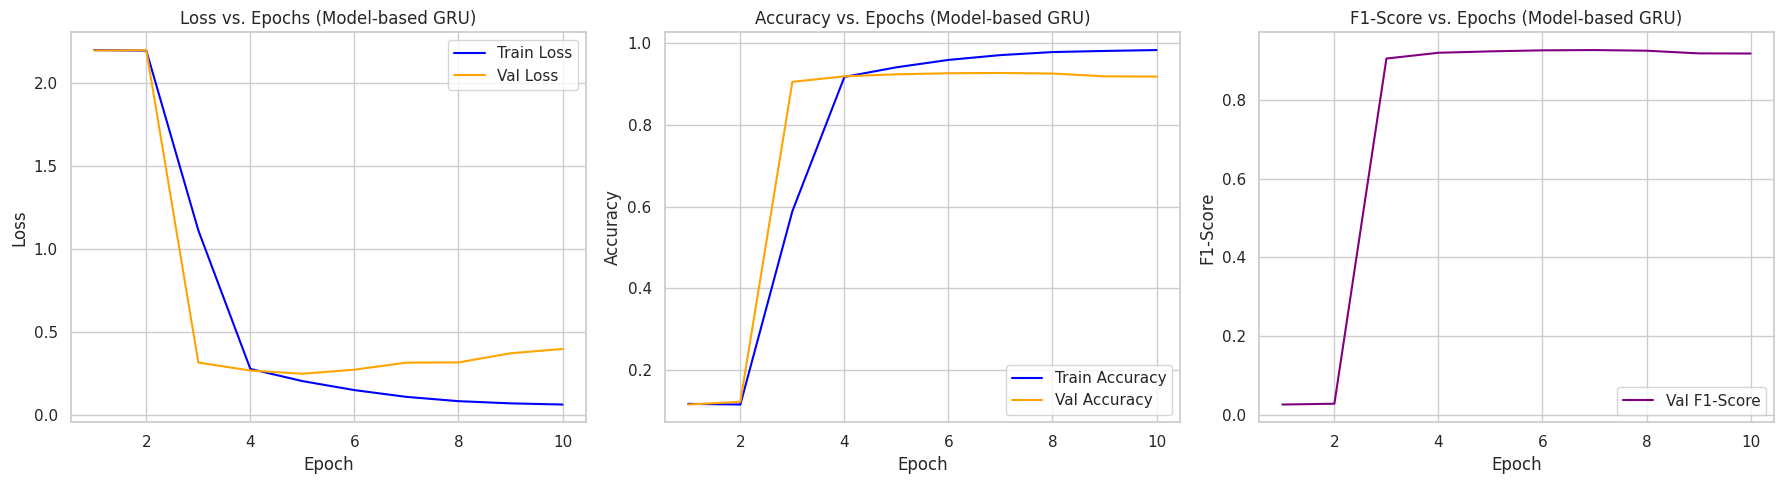

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st plot
sns.lineplot(x=range(1, len(train_losses) + 1), y=train_losses, label='Train Loss', color='blue')
sns.lineplot(x=range(1, len(val_losses) + 1), y=val_losses, label='Val Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs (Model-based GRU)')
plt.legend()

plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd plot
sns.lineplot(x=range(1, len(train_accuracies) + 1), y=train_accuracies, label='Train Accuracy', color='blue')
sns.lineplot(x=range(1, len(val_accuracies) + 1), y=val_accuracies, label='Val Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs (Model-based GRU)')
plt.legend()

plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd plot
sns.lineplot(x=range(1, len(val_f1s) + 1), y=val_f1s, label='Val F1-Score', color='purple')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('F1-Score vs. Epochs (Model-based GRU)')
plt.legend()

plt.tight_layout()
plt.show()

### Optimization phase

II.2.1 Optimizer selection

In [ ]:
num_epochs = 10
learning_rate = 1e-3

optimizers = {
    'RMSprop': optim.RMSprop,
    'Adam': optim.Adam,
    'AdamW': optim.AdamW,
}

for optimizer_name, optimizer_class in optimizers.items():
    print(f"\n🔹 Training with optimizer: {optimizer_name}")

    model = GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, hidden_dim=280, num_layers=1,dropout_prob=0.4, embedding_weights=embedding_matrix, freeze_embeddings=False).to(device)
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)
    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge', project='Multi_Class_Optimizer_Comparison_gru_Weighted_Training', name=f"{optimizer_name}_run", config={
        'learning_rate': learning_rate,
        'num_epochs': num_epochs,
        'optimizer': optimizer_name,
        'model': 'GRU_Model',
        'embedding_dim': 300,
        'hidden_dim': 350,
        'dropout_prob': 0.5
    })

    print(model)
    num_params = count_parameters(model)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    # Progress bar for training
    with tqdm(total=num_epochs, desc=f"Optimizer: {optimizer_name}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(f"Optimizer: {optimizer_name} | Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train ACC: {train_acc:.2%}, Val ACC: {val_acc:.2%}, Time: {epoch_duration / 60:.2f} min")
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1,
            })

    wandb.finish()


🔹 Training with optimizer: RMSprop


GRU_Model(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 280, batch_first=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=280, out_features=9, bias=True)
)
Total trainable parameters: 12492009


Optimizer: RMSprop | Epoch 10/10 - Train Loss: 1.2256, Val Loss: 0.3417, Train ACC: 54.79%, Val ACC: 89.65%, Time: 0.66 min: 100%|██████████| 10/10 [07:16<00:00, 43.65s/epoch]


train_acc,▁▁▁▁▁▁▁▁▁█
train_loss,█████████▁
val_acc,▁▁▁▁▁▁▁▁▁█
val_f1,▁▁▁▁▁▁▁▁▁█
val_loss,▇▇▇▇▇▇▇█▇▁
train_acc,0.54786
train_loss,1.22558
val_acc,0.89652
val_f1,0.89973
val_loss,0.34167



🔹 Training with optimizer: Adam


GRU_Model(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 280, batch_first=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=280, out_features=9, bias=True)
)
Total trainable parameters: 12492009


Optimizer: Adam | Epoch 10/10 - Train Loss: 0.0530, Val Loss: 0.4055, Train ACC: 98.38%, Val ACC: 91.20%, Time: 0.74 min: 100%|██████████| 10/10 [07:45<00:00, 46.55s/epoch]


train_acc,▁▁▅███████
train_loss,██▄▂▁▁▁▁▁▁
val_acc,▁▁████████
val_f1,▁▁████████
val_loss,██▁▁▁▁▁▁▂▂
train_acc,0.98385
train_loss,0.05299
val_acc,0.91204
val_f1,0.91265
val_loss,0.4055



🔹 Training with optimizer: AdamW


GRU_Model(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 280, batch_first=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=280, out_features=9, bias=True)
)
Total trainable parameters: 12492009


Optimizer: AdamW | Epoch 10/10 - Train Loss: 0.0559, Val Loss: 0.4347, Train ACC: 98.31%, Val ACC: 90.38%, Time: 0.71 min: 100%|██████████| 10/10 [07:19<00:00, 43.98s/epoch]


train_acc,▁▁▃▇██████
train_loss,██▆▂▁▁▁▁▁▁
val_acc,▁▁████████
val_f1,▁▁████████
val_loss,██▁▁▁▁▁▁▁▂
train_acc,0.98311
train_loss,0.05592
val_acc,0.90376
val_f1,0.90338
val_loss,0.43475


---
Adam optimizer is selected as optimizer.

II.2.2 Learning rate value selection

In [ ]:
learning_rates = [2e-3, 8e-3, 4e-3]
num_epochs = 7

for lr in learning_rates:
    print(f"\n🔹 Training with RMSprop and learning rate: {lr}")

    model = GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, hidden_dim=280, num_layers=1,dropout_prob=0.4, embedding_weights=embedding_matrix, freeze_embeddings=False).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge', project='Multi_Class_learning_rate_tuning_gru_glove300d_Weighted_Training', name=f"RMSprop_lr_{lr}", config={
        'learning_rate': lr,
        'num_epochs': num_epochs,
        'optimizer': 'RMPprop',
        'model': 'GRU_Model',
        'embedding_dim': 300,
        'hidden_dim': 350,
        'dropout_prob': 0.5
    })

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []
    with tqdm(total=num_epochs, desc=f"LR: {lr}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(f"LR: {lr} | Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train ACSA: {train_acc:.2%}, Val ACSA: {val_acc:.2%}, Time: {epoch_duration / 60:.2f} min")
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1
            })

    wandb.finish()


🔹 Training with RMSprop and learning rate: 0.002


LR: 0.002 | Epoch 7/7 - Train Loss: 0.2344, Val Loss: 0.2602, Train ACSA: 92.77%, Val ACSA: 91.96%, Time: 0.72 min: 100%|██████████| 7/7 [05:07<00:00, 43.91s/epoch]


train_acc,▁▃█████
train_loss,█▆▁▁▁▁▁
val_acc,▁██████
val_f1,▁██████
val_loss,█▂▁▁▁▁▁
train_acc,0.92771
train_loss,0.2344
val_acc,0.91963
val_f1,0.91942
val_loss,0.26024



🔹 Training with RMSprop and learning rate: 0.008


LR: 0.008 | Epoch 7/7 - Train Loss: 0.3881, Val Loss: 0.3593, Train ACSA: 89.12%, Val ACSA: 90.13%, Time: 0.72 min: 100%|██████████| 7/7 [05:06<00:00, 43.82s/epoch]


train_acc,▁▇▇████
train_loss,█▂▂▁▁▁▁
val_acc,▁▁▄█▆▇▇
val_f1,▁▂▅█▆▇▇
val_loss,█▄▃▁▅▃▄
train_acc,0.89123
train_loss,0.38805
val_acc,0.90135
val_f1,0.90199
val_loss,0.3593



🔹 Training with RMSprop and learning rate: 0.004


LR: 0.004 | Epoch 7/7 - Train Loss: 0.2467, Val Loss: 0.2591, Train ACSA: 92.69%, Val ACSA: 92.08%, Time: 0.72 min: 100%|██████████| 7/7 [05:03<00:00, 43.39s/epoch]


train_acc,▁▇▇████
train_loss,█▂▂▁▁▁▁
val_acc,▁▇▇▇▇▆█
val_f1,▁▇▆▇▇▆█
val_loss,█▄▁▂▂▃▁
train_acc,0.92693
train_loss,0.24673
val_acc,0.92083
val_f1,0.92075
val_loss,0.25909


---
Learning rate value is set to $10^{-3}$.

II.2.3 Hidden dimension value selection

In [ ]:
hidden_dims = [100, 250, 400]
learning_rate = 2e-3

for hidden_dim in hidden_dims:
    print(f"\n🔹 Training with hidden_dim: {hidden_dim}\n")
    run_name = f"GRU_Hidden_{hidden_dim}"

    model = GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, hidden_dim=280, num_layers=1,dropout_prob=0.4, embedding_weights=embedding_matrix, freeze_embeddings=False).to(device)
    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project="Multi_Class_GRU-Hidden-Tuning-gru-glove300d_Weighted_Training",
        name=run_name,
        config={
            "embedding_dim": EMBEDDING_DIM,
            "learning_rate": learning_rate,
            "epochs": num_epochs,
            "hidden_dim": 200,
            "dropout": 0.4,
            "optimizer": "RMSprop"
        }
    )

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    with tqdm(total=num_epochs, desc=f"Training with Hidden={hidden_dim}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with hidden_dim: 100



Epoch 7/7 - Train Loss: 2.2019, Val Loss: 2.2011, Train Acc: 11.08%, Val Acc: 11.59%, Val F-1: 2.41%,, Time: 0.68 min: 100%|██████████| 7/7 [04:57<00:00, 42.53s/epoch]


train_acc,▆█▃▁▁▁▁
train_loss,▄▁▆████
val_acc,█▆▁▁▁▁▁
val_f1,█▆▁▁▁▁▁
val_loss,▁▃█████
train_acc,0.11084
train_loss,2.20193
val_acc,0.1159
val_f1,0.02409
val_loss,2.2011



🔹 Training with hidden_dim: 250



Epoch 7/7 - Train Loss: 0.2627, Val Loss: 0.2992, Train Acc: 92.19%, Val Acc: 90.84%, Val F-1: 90.90%,, Time: 0.69 min: 100%|██████████| 7/7 [04:48<00:00, 41.28s/epoch]


train_acc,▁██████
train_loss,█▂▁▁▁▁▁
val_acc,▁▄▅█▇█▅
val_f1,▁▄▆█▇█▅
val_loss,█▄▄▃▂▁▃
train_acc,0.9219
train_loss,0.26275
val_acc,0.90842
val_f1,0.90899
val_loss,0.29917



🔹 Training with hidden_dim: 400



Epoch 7/7 - Train Loss: 2.2046, Val Loss: 2.2007, Train Acc: 11.38%, Val Acc: 11.68%, Val F-1: 2.62%,, Time: 0.68 min: 100%|██████████| 7/7 [04:47<00:00, 41.13s/epoch]


train_acc,▃█▇▃▁▁▁
train_loss,▇▁▃▆███
val_acc,██▂▂▁▂▂
val_f1,██▁▁▁▁▁
val_loss,▂▁█████
train_acc,0.11376
train_loss,2.20461
val_acc,0.11676
val_f1,0.02617
val_loss,2.20069


---
Hidden dimension value is set to 250.


II.2.4 Depth value selection

In [ ]:
depth_values = [1, 2, 3]

for num_layers in depth_values:
    print(f"\n🔹 Training with GRU Depth (num_layers): {num_layers}\n")
    run_name = f"GRU_Depth_{num_layers}"
    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project="Multi-Class-GRU-Depth-Tuning-glove300d_Weighted_Training",
        name=run_name,
        config={
            "num_layers": num_layers,
            "learning_rate": learning_rate,
            "hidden_dim":350,
            "dropout":0.4,
            "optimizer": "RMSprop"
        }
    )
    model = GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, hidden_dim=280, num_layers=1,dropout_prob=0.4, embedding_weights=embedding_matrix, freeze_embeddings=False).to(device)
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    with tqdm(total=num_epochs, desc=f"Training with GRU Depth={num_layers}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with GRU Depth (num_layers): 1



Epoch 7/7 - Train Loss: 0.2489, Val Loss: 0.2729, Train Acc: 92.50%, Val Acc: 91.41%, Val F-1: 91.46%,, Time: 0.69 min: 100%|██████████| 7/7 [04:49<00:00, 41.33s/epoch]


train_acc,▁██████
train_loss,█▁▁▁▁▁▁
val_acc,▁▅▅█▃▇█
val_f1,▁▆▅▇▃██
val_loss,█▄▃▂▄▂▁
train_acc,0.92504
train_loss,0.24888
val_acc,0.91411
val_f1,0.9146
val_loss,0.27287



🔹 Training with GRU Depth (num_layers): 2



Epoch 7/7 - Train Loss: 0.2482, Val Loss: 0.2731, Train Acc: 92.55%, Val Acc: 91.65%, Val F-1: 91.66%,, Time: 0.69 min: 100%|██████████| 7/7 [04:49<00:00, 41.31s/epoch]


train_acc,▁▇▇████
train_loss,█▂▂▁▁▁▁
val_acc,▁▃▄██▆▇
val_f1,▁▂▄█▇▆▇
val_loss,█▆▆▂▂▁▂
train_acc,0.92545
train_loss,0.24821
val_acc,0.91652
val_f1,0.91662
val_loss,0.27311



🔹 Training with GRU Depth (num_layers): 3



Epoch 7/7 - Train Loss: 0.2499, Val Loss: 0.2712, Train Acc: 92.42%, Val Acc: 91.32%, Val F-1: 91.47%,, Time: 0.69 min: 100%|██████████| 7/7 [04:48<00:00, 41.28s/epoch]


train_acc,▁██████
train_loss,█▁▁▁▁▁▁
val_acc,▁▄▆▆▇█▇
val_f1,▁▅▇▆▇██
val_loss,█▅▂▃▄▁▂
train_acc,0.92419
train_loss,0.24989
val_acc,0.91325
val_f1,0.91466
val_loss,0.27124


---
Depth value is set to 1.

II.2.5 Batch size value selection

In [ ]:
batch_sizes = [8, 16, 64]

for batch_size in batch_sizes:
    print(f"\n🔹 Training with batch size: {batch_size}")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

    model = GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, hidden_dim=280, num_layers=1,dropout_prob=0.3, embedding_weights=embedding_matrix, freeze_embeddings=False).to(device)
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project="Multi-Class-batch_size_comparison_gru_glove300d_Weighted_Training",
        name=f"GRU_Batch_{batch_size}",
        config={
            "batch_size": batch_size,
            "learning_rate": learning_rate,
            "num_epochs": num_epochs,
            "optimizer": "RMSprop",
            "hidden_dim": 250,
            "dropout_prob": 0.4
        }
    )

    print(model)
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    with tqdm(total=num_epochs, desc=f"Training with Embedding={hidden_dim}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with batch size: 8


GRU_Model(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 280, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=280, out_features=9, bias=True)
)
Total trainable parameters: 12492009


Epoch 7/7 - Train Loss: 0.1158, Val Loss: 0.4329, Train Acc: 97.23%, Val Acc: 91.82%, Val F-1: 91.82%,, Time: 1.18 min: 100%|██████████| 7/7 [08:17<00:00, 71.04s/epoch]


train_acc,▁▇█████
train_loss,█▂▁▁▁▁▁
val_acc,▄▅█▅▂▁▂
val_f1,▃▅█▆▁▁▂
val_loss,▁▁▃▃▅▇█
train_acc,0.97228
train_loss,0.1158
val_acc,0.91825
val_f1,0.91816
val_loss,0.43289



🔹 Training with batch size: 16


GRU_Model(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 280, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=280, out_features=9, bias=True)
)
Total trainable parameters: 12492009


Epoch 7/7 - Train Loss: 0.0629, Val Loss: 0.3795, Train Acc: 98.13%, Val Acc: 91.58%, Val F-1: 91.57%,, Time: 0.71 min: 100%|██████████| 7/7 [05:00<00:00, 42.94s/epoch]


train_acc,▁▇█████
train_loss,█▂▂▁▁▁▁
val_acc,▇█▅█▄▃▁
val_f1,▇█▅█▅▃▁
val_loss,▂▁▂▃▅▅█
train_acc,0.9813
train_loss,0.06293
val_acc,0.91583
val_f1,0.91565
val_loss,0.37948



🔹 Training with batch size: 64


GRU_Model(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 280, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=280, out_features=9, bias=True)
)
Total trainable parameters: 12492009


Epoch 7/7 - Train Loss: 0.0501, Val Loss: 0.3316, Train Acc: 98.38%, Val Acc: 91.64%, Val F-1: 91.64%,, Time: 0.34 min: 100%|██████████| 7/7 [02:20<00:00, 20.09s/epoch]


train_acc,▁▄█████
train_loss,█▅▂▁▁▁▁
val_acc,▁██████
val_f1,▁██████
val_loss,█▁▁▁▁▁▁
train_acc,0.98385
train_loss,0.05007
val_acc,0.91635
val_f1,0.91638
val_loss,0.33162


---
Batch size value is set to 16.

---

## II.3 **Weighted Training - GLOVE (Glove 300d) - Bahdanau Attention**

### Validation phase

In [ ]:
model = GloVe_GRU_BahdanauAttention(embedding_matrix=embedding_matrix, hidden_dim=200, num_layers=1, dropout_prob=0.8).to(device)
print(model)

num_params = count_parameters(model)
print(f"Total trainable parameters: {num_params}")

GloVe_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 200, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=400, out_features=200, bias=True)
    (v): Linear(in_features=200, out_features=1, bias=False)
  )
  (fc): Linear(in_features=400, out_features=9, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)
Total trainable parameters: 12687009


In [ ]:
learning_rate = 1e-4
num_epochs = 6
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-5)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
val_f1s = []

with tqdm(total=num_epochs, desc="Training Progress", unit="epoch") as pbar:
    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1s.append(val_f1)

        end_time = time.time()
        epoch_duration = end_time - start_time

        pbar.set_description(
            f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
            f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F1: {val_f1:.2%}, Time: {epoch_duration / 60:.2f} min"
        )
        pbar.update(1)


Epoch 6/6 - Train Loss: 0.2371, Val Loss: 0.2695, Train Acc: 92.56%, Val Acc: 92.00%, Val F1: 91.95%, Time: 0.46 min: 100%|██████████| 6/6 [02:43<00:00, 27.26s/epoch]


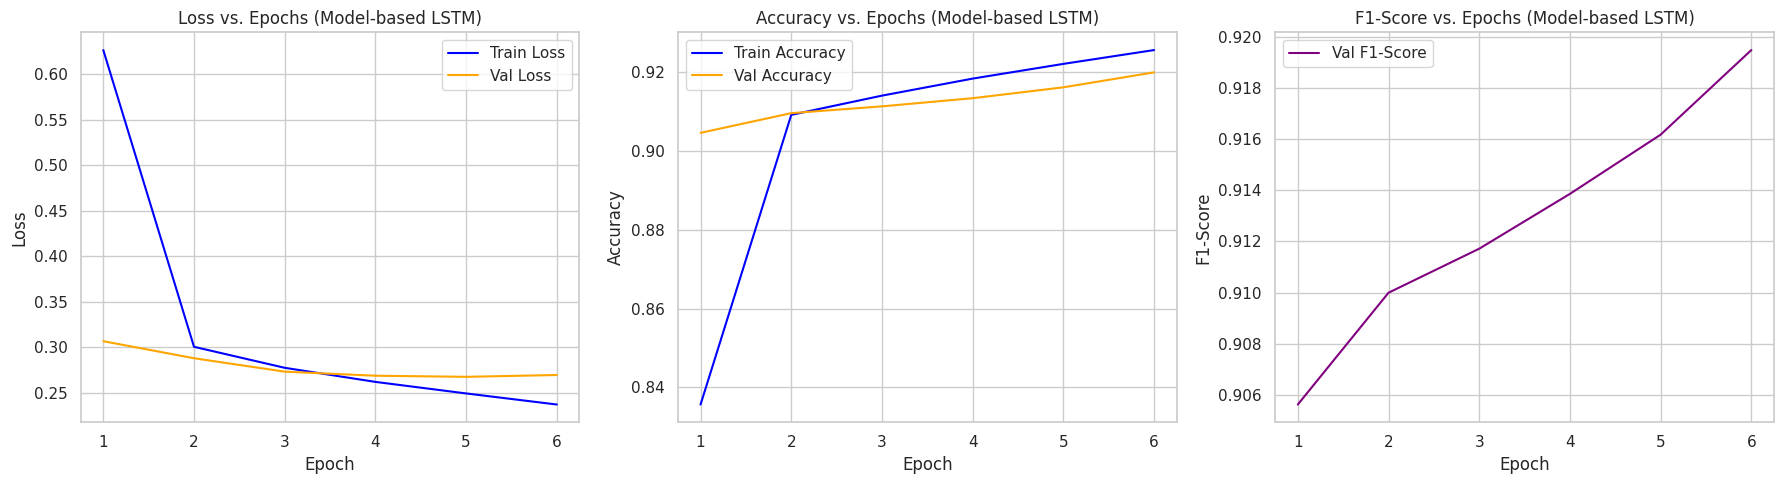

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st plot
sns.lineplot(x=range(1, len(train_losses) + 1), y=train_losses, label='Train Loss', color='blue')
sns.lineplot(x=range(1, len(val_losses) + 1), y=val_losses, label='Val Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs (Model-based LSTM)')
plt.legend()

plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd plot
sns.lineplot(x=range(1, len(train_accuracies) + 1), y=train_accuracies, label='Train Accuracy', color='blue')
sns.lineplot(x=range(1, len(val_accuracies) + 1), y=val_accuracies, label='Val Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs (Model-based LSTM)')
plt.legend()

plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd plot
sns.lineplot(x=range(1, len(val_f1s) + 1), y=val_f1s, label='Val F1-Score', color='purple')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('F1-Score vs. Epochs (Model-based LSTM)')
plt.legend()

plt.tight_layout()
plt.show()

### Optimization phase

II.3.1 Optimimzer selection

In [ ]:
learning_rate = 1e-4

optimizers = {
    'RMSprop': optim.RMSprop,
    'Adam': optim.Adam,
    'AdamW': optim.AdamW,
}

for optimizer_name, optimizer_class in optimizers.items():
    print(f"\n🔹 Training with optimizer: {optimizer_name}")

    model = GloVe_GRU_BahdanauAttention(embedding_matrix=embedding_matrix, hidden_dim=200, num_layers=1, dropout_prob=0.8).to(device)
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)
    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge', project='Multi_Class_Optimizer_Comparison_gru_glove300d_Attention_Weighted_Training', name=f"{optimizer_name}_run", config={
        'learning_rate': learning_rate,
        'num_epochs': num_epochs,
        'optimizer': optimizer_name,
        'model': 'GRU_Model',
        'embedding_dim': 300,
        'hidden_dim': 200,
        'dropout_prob': 0.5
    })

    print(model)
    num_params = count_parameters(model)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    # Progress bar for training
    with tqdm(total=num_epochs, desc=f"Optimizer: {optimizer_name}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(f"Optimizer: {optimizer_name} | Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train ACC: {train_acc:.2%}, Val ACC: {val_acc:.2%}, Time: {epoch_duration / 60:.2f} min")
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1,
            })

    wandb.finish()


🔹 Training with optimizer: RMSprop


GloVe_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 200, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=400, out_features=200, bias=True)
    (v): Linear(in_features=200, out_features=1, bias=False)
  )
  (fc): Linear(in_features=400, out_features=9, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)
Total trainable parameters: 12687009


Optimizer: RMSprop | Epoch 6/6 - Train Loss: 0.2307, Val Loss: 0.2589, Train ACC: 92.76%, Val ACC: 91.84%, Time: 0.45 min: 100%|██████████| 6/6 [02:33<00:00, 25.55s/epoch]


train_acc,▁▇▇▇██
train_loss,█▂▂▁▁▁
val_acc,▁▄▅▆▇█
val_f1,▁▅▅▆██
val_loss,█▄▃▂▂▁
train_acc,0.92759
train_loss,0.23073
val_acc,0.91842
val_f1,0.91809
val_loss,0.25885



🔹 Training with optimizer: Adam


GloVe_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 200, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=400, out_features=200, bias=True)
    (v): Linear(in_features=200, out_features=1, bias=False)
  )
  (fc): Linear(in_features=400, out_features=9, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)
Total trainable parameters: 12687009


Optimizer: Adam | Epoch 6/6 - Train Loss: 0.2265, Val Loss: 0.2604, Train ACC: 93.04%, Val ACC: 91.60%, Time: 0.46 min: 100%|██████████| 6/6 [02:44<00:00, 27.35s/epoch]


train_acc,▁▇████
train_loss,█▂▁▁▁▁
val_acc,▁▃▂▆██
val_f1,▁▄▃▆██
val_loss,█▄▃▂▁▁
train_acc,0.93044
train_loss,0.22655
val_acc,0.91601
val_f1,0.91592
val_loss,0.26037



🔹 Training with optimizer: AdamW


GloVe_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 200, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=400, out_features=200, bias=True)
    (v): Linear(in_features=200, out_features=1, bias=False)
  )
  (fc): Linear(in_features=400, out_features=9, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)
Total trainable parameters: 12687009


Optimizer: AdamW | Epoch 6/6 - Train Loss: 0.2243, Val Loss: 0.2585, Train ACC: 92.90%, Val ACC: 91.84%, Time: 0.46 min: 100%|██████████| 6/6 [02:44<00:00, 27.34s/epoch]


train_acc,▁▇████
train_loss,█▂▁▁▁▁
val_acc,▁▃▅▇▆█
val_f1,▁▄▅█▇█
val_loss,█▄▃▂▁▁
train_acc,0.929
train_loss,0.22431
val_acc,0.91842
val_f1,0.91803
val_loss,0.25852


---
RMSprop is selected as optimizer.

II.3.2 Learning rate value selection

In [ ]:
learning_rates = [9e-5, 7e-5, 8e-5]

for lr in learning_rates:
    print(f"\n🔹 Training with RMSprop and learning rate: {lr}")

    model = GloVe_GRU_BahdanauAttention(embedding_matrix=embedding_matrix, hidden_dim=200, num_layers=1, dropout_prob=0.8).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge', project='Multi_Class_learning_rate_tuning_gru_glove300d_Attention_Weighted_Training', name=f"RMSprop_lr_{lr}", config={
        'learning_rate': lr,
        'num_epochs': num_epochs,
        'optimizer': 'RMPprop',
        'model': 'GRU_Model',
        'embedding_dim': 300,
        'hidden_dim': 200,
        'dropout_prob': 0.5
    })

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []
    with tqdm(total=num_epochs, desc=f"LR: {lr}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(f"LR: {lr} | Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train ACSA: {train_acc:.2%}, Val ACSA: {val_acc:.2%}, Time: {epoch_duration / 60:.2f} min")
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1
            })

    wandb.finish()


🔹 Training with RMSprop and learning rate: 9e-05


LR: 9e-05 | Epoch 6/6 - Train Loss: 0.2348, Val Loss: 0.2646, Train ACSA: 92.68%, Val ACSA: 91.64%, Time: 0.46 min: 100%|██████████| 6/6 [02:43<00:00, 27.33s/epoch]


train_acc,▁▇████
train_loss,█▂▁▁▁▁
val_acc,▁▄▅▇██
val_f1,▁▄▆▇██
val_loss,█▄▂▂▂▁
train_acc,0.92678
train_loss,0.23477
val_acc,0.91635
val_f1,0.91626
val_loss,0.26463



🔹 Training with RMSprop and learning rate: 7e-05


LR: 7e-05 | Epoch 6/6 - Train Loss: 0.2474, Val Loss: 0.2668, Train ACSA: 92.39%, Val ACSA: 91.41%, Time: 0.46 min: 100%|██████████| 6/6 [02:44<00:00, 27.34s/epoch]


train_acc,▁▇████
train_loss,█▂▁▁▁▁
val_acc,▁▅▇▇██
val_f1,▁▅▇▇██
val_loss,█▃▂▁▁▁
train_acc,0.92394
train_loss,0.24741
val_acc,0.91411
val_f1,0.91416
val_loss,0.26676



🔹 Training with RMSprop and learning rate: 8e-05


LR: 8e-05 | Epoch 6/6 - Train Loss: 0.2411, Val Loss: 0.2669, Train ACSA: 92.53%, Val ACSA: 91.77%, Time: 0.45 min: 100%|██████████| 6/6 [02:43<00:00, 27.32s/epoch]


train_acc,▁▇████
train_loss,█▂▁▁▁▁
val_acc,▁▄▃▅▇█
val_f1,▁▄▄▅▇█
val_loss,█▃▂▂▁▁
train_acc,0.92527
train_loss,0.24105
val_acc,0.91773
val_f1,0.91736
val_loss,0.26694


---
Learning rate value is set to $10^{-4}$.

II.3.3 Hidden dimension value selection

In [ ]:
hidden_dims = [100, 250, 400]
learning_rate = 1e-4

for hidden_dim in hidden_dims:
    print(f"\n🔹 Training with hidden_dim: {hidden_dim}\n")
    run_name = f"GRU_Hidden_{hidden_dim}"

    model = GloVe_GRU_BahdanauAttention(embedding_matrix=embedding_matrix, hidden_dim=200, num_layers=1, dropout_prob=0.8).to(device)
    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project="Multi_Class_GRU-Hidden-Tuning-glove300d_Attention_Weighted_Training",
        name=run_name,
        config={
            "embedding_dim": EMBEDDING_DIM,
            "learning_rate": learning_rate,
            "epochs": num_epochs,
            "hidden_dim": 200,
            "dropout": 0.4,
            "optimizer": "RMSprop"
        }
    )

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    with tqdm(total=num_epochs, desc=f"Training with Hidden={hidden_dim}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with hidden_dim: 100



Epoch 6/6 - Train Loss: 0.2384, Val Loss: 0.2622, Train Acc: 92.50%, Val Acc: 91.34%, Val F-1: 91.40%,, Time: 0.46 min: 100%|██████████| 6/6 [02:42<00:00, 27.14s/epoch]


train_acc,▁▇▇▇██
train_loss,█▂▂▁▁▁
val_acc,▁▄▆█▆▇
val_f1,▁▃▆█▆▇
val_loss,█▄▃▂▂▁
train_acc,0.92501
train_loss,0.23843
val_acc,0.91342
val_f1,0.91395
val_loss,0.2622



🔹 Training with hidden_dim: 250



Epoch 6/6 - Train Loss: 0.2363, Val Loss: 0.2588, Train Acc: 92.64%, Val Acc: 91.65%, Val F-1: 91.66%,, Time: 0.46 min: 100%|██████████| 6/6 [02:44<00:00, 27.35s/epoch]


train_acc,▁▇▇▇██
train_loss,█▂▂▁▁▁
val_acc,▁▂▃▅██
val_f1,▁▂▃▅██
val_loss,█▄▃▂▂▁
train_acc,0.92637
train_loss,0.23632
val_acc,0.91652
val_f1,0.91661
val_loss,0.25882



🔹 Training with hidden_dim: 400



Epoch 6/6 - Train Loss: 0.2368, Val Loss: 0.2625, Train Acc: 92.59%, Val Acc: 91.76%, Val F-1: 91.75%,, Time: 0.46 min: 100%|██████████| 6/6 [02:44<00:00, 27.37s/epoch]


train_acc,▁▇▇▇██
train_loss,█▂▂▁▁▁
val_acc,▁▄▅▆▇█
val_f1,▁▃▅▅▇█
val_loss,█▅▃▂▁▁
train_acc,0.92593
train_loss,0.23681
val_acc,0.91756
val_f1,0.91749
val_loss,0.26246


---
Hidden dimension value is set to 250.

II.3.4 Depth value selection

In [ ]:
depth_values = [1, 2, 3]

for num_layers in depth_values:
    print(f"\n🔹 Training with GRU Depth (num_layers): {num_layers}\n")
    run_name = f"GRU_Depth_{num_layers}"
    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project="Multi-Class-GRU-Depth-Tuning-glove300d_Attention_Weighted_Training",
        name=run_name,
        config={
            "num_layers": num_layers,
            "learning_rate": learning_rate,
            "hidden_dim":200,
            "dropout":0.8,
            "optimizer": "RMSprop"
        }
    )
    model = GloVe_GRU_BahdanauAttention(embedding_matrix=embedding_matrix, hidden_dim=200, num_layers=1, dropout_prob=0.8).to(device)
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    with tqdm(total=num_epochs, desc=f"Training with GRU Depth={num_layers}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with GRU Depth (num_layers): 1



Epoch 6/6 - Train Loss: 0.2342, Val Loss: 0.2602, Train Acc: 92.67%, Val Acc: 91.76%, Val F-1: 91.70%,, Time: 0.45 min: 100%|██████████| 6/6 [02:43<00:00, 27.30s/epoch]


train_acc,▁▇▇▇██
train_loss,█▂▂▁▁▁
val_acc,▁▃▅▄▇█
val_f1,▁▃▆▄▇█
val_loss,█▄▃▂▁▁
train_acc,0.92667
train_loss,0.2342
val_acc,0.91756
val_f1,0.91702
val_loss,0.26015



🔹 Training with GRU Depth (num_layers): 2



Epoch 6/6 - Train Loss: 0.2357, Val Loss: 0.2571, Train Acc: 92.61%, Val Acc: 91.81%, Val F-1: 91.77%,, Time: 0.48 min: 100%|██████████| 6/6 [02:46<00:00, 27.75s/epoch]


train_acc,▁▇▇███
train_loss,█▂▂▁▁▁
val_acc,▁▄▅▅▅█
val_f1,▁▄▅▆▆█
val_loss,█▄▃▃▂▁
train_acc,0.92612
train_loss,0.23573
val_acc,0.91808
val_f1,0.91771
val_loss,0.2571



🔹 Training with GRU Depth (num_layers): 3



Epoch 6/6 - Train Loss: 0.2355, Val Loss: 0.2656, Train Acc: 92.65%, Val Acc: 91.55%, Val F-1: 91.56%,, Time: 0.57 min: 100%|██████████| 6/6 [03:00<00:00, 30.13s/epoch]


train_acc,▁▇▇███
train_loss,█▂▂▁▁▁
val_acc,▁▃▅▇▅█
val_f1,▁▃▅▇▅█
val_loss,█▄▃▂▃▁
train_acc,0.92652
train_loss,0.2355
val_acc,0.91549
val_f1,0.91563
val_loss,0.26562


---
Depth value is set to 1.

II.3.5 Batch size value selection

In [ ]:
batch_sizes = [8, 16, 64]

for batch_size in batch_sizes:
    print(f"\n🔹 Training with batch size: {batch_size}")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    GloVe_GRU_BahdanauAttention(embedding_matrix=embedding_matrix, hidden_dim=200, num_layers=1, dropout_prob=0.8).to(device)
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project="Multi-Class-batch_size_comparison_gru_glove300d_Attention_Weighted_Training",
        name=f"GRU_Batch_{batch_size}",
        config={
            "batch_size": batch_size,
            "learning_rate": learning_rate,
            "num_epochs": num_epochs,
            "optimizer": "RMSprop",
            "hidden_dim": 200,
            "dropout_prob": 0.8
        }
    )

    print(model)
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    with tqdm(total=num_epochs, desc=f"Training with Embedding={hidden_dim}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with batch size: 8


GloVe_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 200, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=400, out_features=200, bias=True)
    (v): Linear(in_features=200, out_features=1, bias=False)
  )
  (fc): Linear(in_features=400, out_features=9, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)
Total trainable parameters: 12687009


Epoch 6/6 - Train Loss: 0.1485, Val Loss: 0.3740, Train Acc: 96.11%, Val Acc: 91.34%, Val F-1: 91.37%,, Time: 1.62 min: 100%|██████████| 6/6 [10:12<00:00, 102.15s/epoch]


train_acc,▁▃▄▅▇█
train_loss,█▇▅▄▂▁
val_acc,▃▆▆█▅▁
val_f1,▃▇▇█▅▁
val_loss,▁▁▄▃██
train_acc,0.96112
train_loss,0.14854
val_acc,0.91342
val_f1,0.91366
val_loss,0.37404



🔹 Training with batch size: 16


GloVe_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 200, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=400, out_features=200, bias=True)
    (v): Linear(in_features=200, out_features=1, bias=False)
  )
  (fc): Linear(in_features=400, out_features=9, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)
Total trainable parameters: 12687009


Epoch 6/6 - Train Loss: 0.0685, Val Loss: 0.4432, Train Acc: 98.09%, Val Acc: 91.07%, Val F-1: 91.12%,, Time: 0.88 min: 100%|██████████| 6/6 [05:14<00:00, 52.45s/epoch]


train_acc,▁▃▅▆▇█
train_loss,█▆▄▃▂▁
val_acc,▆█▁▄▁▁
val_f1,▆█▁▄▁▁
val_loss,▁▁▃▅█▇
train_acc,0.98093
train_loss,0.06846
val_acc,0.91066
val_f1,0.91117
val_loss,0.4432



🔹 Training with batch size: 64


GloVe_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 200, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=400, out_features=200, bias=True)
    (v): Linear(in_features=200, out_features=1, bias=False)
  )
  (fc): Linear(in_features=400, out_features=9, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)
Total trainable parameters: 12687009


Epoch 6/6 - Train Loss: 0.0388, Val Loss: 0.4388, Train Acc: 98.71%, Val Acc: 90.67%, Val F-1: 90.70%,, Time: 0.46 min: 100%|██████████| 6/6 [02:45<00:00, 27.52s/epoch]


train_acc,▁▃▅▆▆█
train_loss,█▆▄▃▂▁
val_acc,█▅▅▁▅▂
val_f1,█▅▅▁▅▁
val_loss,▃▄█▂▁▃
train_acc,0.98706
train_loss,0.03876
val_acc,0.90669
val_f1,0.90695
val_loss,0.43881


---
Batch size value is set to 16.

---
#III. **Borderline-SMOTE**
---

Borderline-SMOTE is a variant of SMOTE that focuses on generating synthetic examples only around the decision boundaries between classes.
It identifies points close to the boundary between the minority class and other classes, and generates synthetic samples from these hard-to-classify points, rather than doing so randomly over the whole minority class.

In [ ]:
batch_size = 16

bsmote = BorderlineSMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = bsmote.fit_resample(X_train_tensor, y_train_tensor)

In [ ]:
X_val_resampled, y_val_resampled = X_val_tensor, y_val_tensor
X_test_resampled, y_test_resampled = X_test_tensor, y_test_tensor

train_dataset = TextDataset(X_train_resampled, y_train_resampled, raw_text_data=X_train)
val_dataset = TextDataset(X_val_tensor, y_val, raw_text_data=X_val)
test_dataset = TextDataset(X_test_tensor, y_test, raw_text_data=X_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

<ipython-input-8-35ba822a06f8>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)


---
## III.1 **Borderline-SMOTE - CNN-LSTM**

### Validation phase

In [ ]:
model = CNN_LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=280, hidden_dim=200, num_layers=1, dropout_prob=0.3).to(device)

print(model)
num_params = count_parameters(model)
print()
print(f"Total trainable parameters: {num_params}")

CNN_LSTM_Model(
  (embedding): Embedding(40002, 280)
  (conv1): Conv1d(280, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(100, 200, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=200, out_features=9, bias=True)
)

Total trainable parameters: 11558169


In [ ]:
learning_rate = 1e-3
num_epochs = 10
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
val_f1s = []

with tqdm(total=num_epochs, desc="Training Progress", unit="epoch") as pbar:
    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1s.append(val_f1)

        end_time = time.time()
        epoch_duration = end_time - start_time

        pbar.set_description(
            f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
            f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F1: {val_f1:.2%}, Time: {epoch_duration / 60:.2f} min"
        )
        pbar.update(1)

Epoch 10/10 - Train Loss: 0.1776, Val Loss: 0.5281, Train Acc: 94.97%, Val Acc: 88.91%, Val F1: 89.00%, Time: 0.52 min: 100%|██████████| 10/10 [04:58<00:00, 29.82s/epoch]


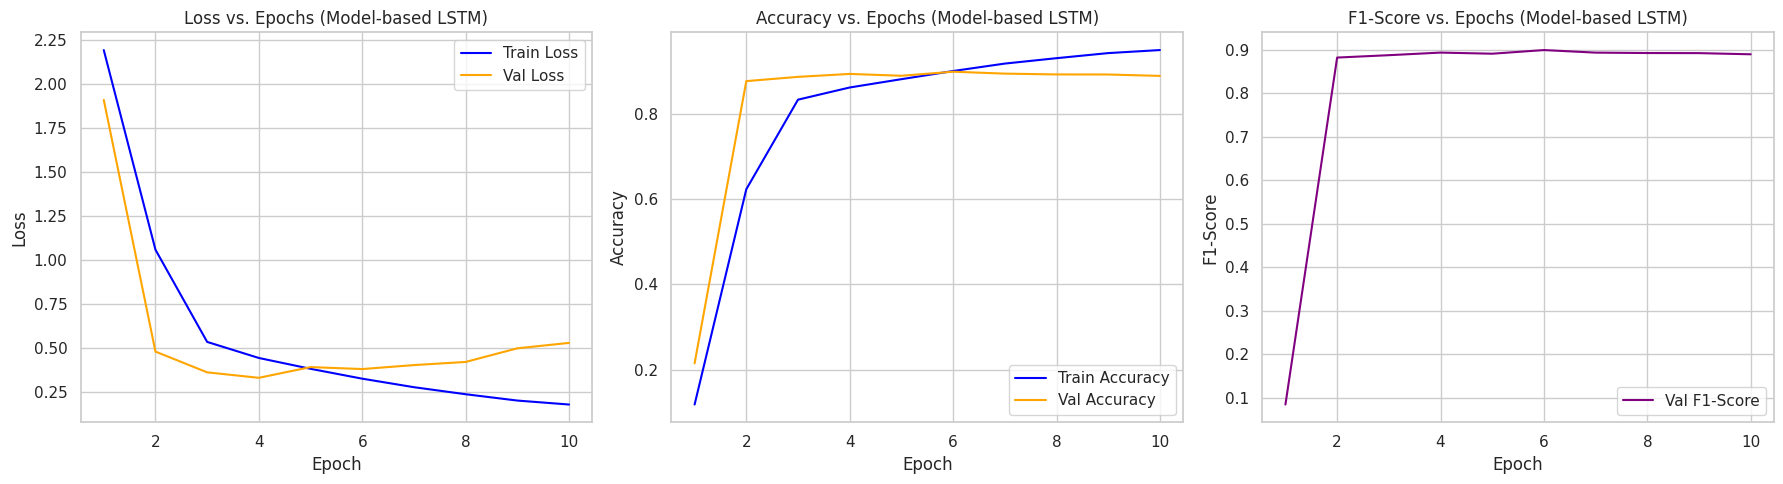

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st plot
sns.lineplot(x=range(1, len(train_losses) + 1), y=train_losses, label='Train Loss', color='blue')
sns.lineplot(x=range(1, len(val_losses) + 1), y=val_losses, label='Val Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs (Model-based LSTM)')
plt.legend()

plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd plot
sns.lineplot(x=range(1, len(train_accuracies) + 1), y=train_accuracies, label='Train Accuracy', color='blue')
sns.lineplot(x=range(1, len(val_accuracies) + 1), y=val_accuracies, label='Val Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs (Model-based LSTM)')
plt.legend()

plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd plot
sns.lineplot(x=range(1, len(val_f1s) + 1), y=val_f1s, label='Val F1-Score', color='purple')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('F1-Score vs. Epochs (Model-based LSTM)')
plt.legend()

plt.tight_layout()
plt.show()

### Optimization phase

III.1.1 Optimizer selection

In [ ]:
num_epochs = 10
learning_rate = 1e-3
loss_function = torch.nn.CrossEntropyLoss()

optimizers = {
    'Adam': optim.Adam,
    'RMSprop': optim.RMSprop,
    'AdamW': optim.AdamW,
}

for optimizer_name, optimizer_class in optimizers.items():
    print(f"\n🔹 Training with optimizer: {optimizer_name}")

    model = CNN_LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=280, hidden_dim=200, num_layers=1, dropout_prob=0.3).to(device)
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)

    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge', project='Multi_Class_Optimizer_Tuning_cnn_lstm_Borderline-SMOTE', name=f"{optimizer_name}_run", config={
        'learning_rate': learning_rate,
        'num_epochs': num_epochs,
        'optimizer': optimizer_name,
        'model': 'CNN_LSTM_Model',
        'embedding_dim': 128,
        'hidden_dim': 167,
        'dropout_prob': 0.5
    })

    print(model)
    num_params = count_parameters(model)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    # Progress bar for training
    with tqdm(total=num_epochs, desc=f"Optimizer: {optimizer_name}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(f"Optimizer: {optimizer_name} | Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train ACC: {train_acc:.2%}, Val ACC: {val_acc:.2%}, Time: {epoch_duration / 60:.2f} min")
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1,
            })

    wandb.finish()


🔹 Training with optimizer: Adam


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: wilfried-mvomoeto (wilfried-mvomoeto-university-of-li-ge) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


CNN_LSTM_Model(
  (embedding): Embedding(40002, 280)
  (conv1): Conv1d(280, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(100, 200, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=200, out_features=9, bias=True)
)
Total trainable parameters: 11558169


Optimizer: Adam | Epoch 10/10 - Train Loss: 2.1841, Val Loss: 2.2171, Train ACC: 11.48%, Val ACC: 11.45%, Time: 0.49 min: 100%|██████████| 10/10 [05:44<00:00, 34.41s/epoch]


train_acc,▁▂▁▂▃▃▆▄█▆
train_loss,██▇▆▄▃▂▂▁▁
val_acc,▇▇█▇█▁▇▇▅▇
val_f1,▇██▇█▁▇▇▅▇
val_loss,▁▁▂▂▃▅▆▅▆█
train_acc,0.11482
train_loss,2.18405
val_acc,0.11452
val_f1,0.02472
val_loss,2.21706



🔹 Training with optimizer: RMSprop


CNN_LSTM_Model(
  (embedding): Embedding(40002, 280)
  (conv1): Conv1d(280, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(100, 200, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=200, out_features=9, bias=True)
)
Total trainable parameters: 11558169


Optimizer: RMSprop | Epoch 10/10 - Train Loss: 0.2492, Val Loss: 0.4532, Train ACC: 92.70%, Val ACC: 88.88%, Time: 0.46 min: 100%|██████████| 10/10 [04:37<00:00, 27.71s/epoch]


train_acc,▁▁▁▆▇▇████
train_loss,███▃▂▂▁▁▁▁
val_acc,▁▁▃███████
val_f1,▁▁▃███████
val_loss,██▅▁▁▁▁▁▁▁
train_acc,0.92701
train_loss,0.24918
val_acc,0.88875
val_f1,0.89039
val_loss,0.45319



🔹 Training with optimizer: AdamW


CNN_LSTM_Model(
  (embedding): Embedding(40002, 280)
  (conv1): Conv1d(280, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(100, 200, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=200, out_features=9, bias=True)
)
Total trainable parameters: 11558169


Optimizer: AdamW | Epoch 10/10 - Train Loss: 2.1853, Val Loss: 2.2079, Train ACC: 11.30%, Val ACC: 11.61%, Time: 0.50 min: 100%|██████████| 10/10 [05:02<00:00, 30.22s/epoch]


train_acc,▁▄▃▅▃█▇▃█▅
train_loss,█▇▇▆▅▄▃▂▁▁
val_acc,▁▅▇▇▇▇▅█▇▇
val_f1,▁▄▇▇▇▇▄█▇▇
val_loss,▂▁▁▄▃▃▄▅█▆
train_acc,0.113
train_loss,2.18534
val_acc,0.11607
val_f1,0.02646
val_loss,2.20786


---
RMSprop is selected as optimizer.

III.1.2 Learning rate value selection

In [ ]:
learning_rates = [8e-4, 1e-3, 7e-4]

for lr in learning_rates:
    print(f"\n🔹 Training with RMSprop and learning rate: {lr}")

    model = CNN_LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=280, hidden_dim=200, num_layers=1, dropout_prob=0.3).to(device)
    optimizer = optim.RMSprop(model.parameters(), lr=lr)

    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',, project='Multi_Class_learning_rate_tuning_cnn_lstm_Borderline-SMOTE', name=f"RMSprop_lr_{lr}", config={
        'learning_rate': lr,
        'num_epochs': num_epochs,
        'optimizer': 'RMSprop',
        'model': 'LSTM_CNN_Model',
        'embedding_dim': 250,
        'hidden_dim': 167,
        'dropout_prob': 0.5
    })

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []
    with tqdm(total=num_epochs, desc=f"LR: {lr}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(f"LR: {lr} | Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train ACSA: {train_acc:.2%}, Val ACSA: {val_acc:.2%}, Time: {epoch_duration / 60:.2f} min")
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1
            })

    wandb.finish()


🔹 Training with RMSprop and learning rate: 0.0008


LR: 0.0008 | Epoch 10/10 - Train Loss: 2.1851, Val Loss: 2.2137, Train ACSA: 11.78%, Val ACSA: 9.71%, Time: 0.51 min: 100%|██████████| 10/10 [05:24<00:00, 32.44s/epoch]


train_acc,▂▁▁▅▅▆▇▆▅█
train_loss,█▇▆▄▃▂▁▃▁▁
val_acc,▁██▆▆▆▁██▁
val_f1,▂██▆▆▆▂▇█▁
val_loss,▁▁▁▃▄▅▇▆██
train_acc,0.11784
train_loss,2.18508
val_acc,0.0971
val_f1,0.0182
val_loss,2.21372



🔹 Training with RMSprop and learning rate: 0.001


LR: 0.001 | Epoch 10/10 - Train Loss: 0.2496, Val Loss: 0.4440, Train ACSA: 92.82%, Val ACSA: 88.89%, Time: 0.55 min: 100%|██████████| 10/10 [05:10<00:00, 31.10s/epoch]


train_acc,▁▁▃▇▇▇████
train_loss,██▆▃▂▂▁▁▁▁
val_acc,▁▁▆███████
val_f1,▁▁▆███████
val_loss,██▄▁▁▁▁▁▁▁
train_acc,0.92817
train_loss,0.24959
val_acc,0.88893
val_f1,0.88933
val_loss,0.44403



🔹 Training with RMSprop and learning rate: 0.0007


LR: 0.0007 | Epoch 10/10 - Train Loss: 2.1856, Val Loss: 2.2155, Train ACSA: 11.34%, Val ACSA: 11.61%, Time: 0.46 min: 100%|██████████| 10/10 [04:51<00:00, 29.11s/epoch]


train_acc,▁▄▃▃▃▆▅▇█▄
train_loss,█▇▆▅▃▂▂▂▁▂
val_acc,▇▅█▁▁▇▅▇▇▇
val_f1,▇▄█▁▁▇▄▇▇▇
val_loss,▁▁▁▄▅▄▇▇▆█
train_acc,0.1134
train_loss,2.18559
val_acc,0.11607
val_f1,0.02789
val_loss,2.21554


---

III.1.3 Embedding dimension value selection

In [ ]:
embedding_dims = [100, 250, 320]
learning_rate = 1e-3

for embedding_dim in embedding_dims:
    print(f"\n🔹 Training with embedding_dim: {embedding_dim}\n")
    run_name = f"CNN_LSTM_Embedding_{embedding_dim}"
    model = CNN_LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=embedding_dim, hidden_dim=200, num_layers=1, dropout_prob=0.3).to(device)
    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project="Multi_Class_CNN_LSTM_Embedding_Tuning_Borderline-SMOTE",
        name=run_name,
        config={
            "embedding_dim": embedding_dim,
            "learning_rate": learning_rate,
            "epochs": num_epochs,
            "hidden_dim": 167,
            "dropout": 0.5,
            "optimizer": "AdamW"
        }
    )

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    with tqdm(total=num_epochs, desc=f"Training with Embedding={embedding_dim}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with embedding_dim: 100



Epoch 10/10 - Train Loss: 2.1851, Val Loss: 2.2190, Train Acc: 11.65%, Val Acc: 12.25%, Val F-1: 2.75%,, Time: 0.37 min: 100%|██████████| 10/10 [03:39<00:00, 21.91s/epoch]


train_acc,▃▅▁▅▂▄▇▃██
train_loss,█▇▆▅▄▂▂▁▁▁
val_acc,▇▁█▅▇█▅▇▄█
val_f1,▇▁▇▄▇█▄▇▄▇
val_loss,▁▂▂▃▃▄▆▅█▇
train_acc,0.11648
train_loss,2.1851
val_acc,0.12246
val_f1,0.02753
val_loss,2.21896



🔹 Training with embedding_dim: 250



Epoch 10/10 - Train Loss: 2.1844, Val Loss: 2.2063, Train Acc: 12.19%, Val Acc: 12.94%, Val F-1: 5.06%,, Time: 0.44 min: 100%|██████████| 10/10 [04:24<00:00, 26.47s/epoch]


train_acc,▁▁▂▄▃▅▅▅▃█
train_loss,█▇▇▄▃▂▂▁▁▁
val_acc,▅▇▅▆▁▇▁▅▆█
val_f1,▂▃▃▃▁▃▁▂▃█
val_loss,▂▁▃▃▄▄▆█▇▅
train_acc,0.12188
train_loss,2.18439
val_acc,0.12935
val_f1,0.05064
val_loss,2.20627



🔹 Training with embedding_dim: 320



Epoch 10/10 - Train Loss: 0.1705, Val Loss: 0.5185, Train Acc: 95.38%, Val Acc: 88.91%, Val F-1: 88.95%,, Time: 0.48 min: 100%|██████████| 10/10 [04:48<00:00, 28.84s/epoch]


train_acc,▁▆▇▇▇█████
train_loss,█▄▂▂▂▁▁▁▁▁
val_acc,▁█████████
val_f1,▁█████████
val_loss,█▁▁▁▁▁▁▂▂▂
train_acc,0.95376
train_loss,0.17053
val_acc,0.8891
val_f1,0.88954
val_loss,0.51853


---
Embedding dimension value is set to 280.

III. Depth value selection

In [ ]:
depth_values = [1, 2, 3]
learning_rate = 1e-3

for num_layers in depth_values:
    print(f"\n🔹 Training with GRU Depth (num_layers): {num_layers}\n")

    run_name = f"CNN_LSTM_Depth_{num_layers}"
    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project="Multi-Class-CNN-LSTM-Depth-Tuning_Borderline-SMOTE",
        name=run_name,
        config={
            "num_layers": num_layers,
            "learning_rate": learning_rate,
            "hidden_dim":167,
            "dropout":0.5,
            "optimizer": "AdamW"
        }
    )
    model = CNN_LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=280, hidden_dim=200, num_layers=num_layers, dropout_prob=0.3).to(device)
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    with tqdm(total=num_epochs, desc=f"Training with CNN-LSTM Depth={num_layers}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with GRU Depth (num_layers): 1



Epoch 10/10 - Train Loss: 0.2200, Val Loss: 0.4334, Train Acc: 93.56%, Val Acc: 88.86%, Val F-1: 88.94%,, Time: 0.46 min: 100%|██████████| 10/10 [04:36<00:00, 27.64s/epoch]


train_acc,▁▁▄▇▇▇████
train_loss,██▅▂▂▂▁▁▁▁
val_acc,▁▁████████
val_f1,▁▁████████
val_loss,██▁▁▁▁▁▁▁▁
train_acc,0.93559
train_loss,0.21998
val_acc,0.88858
val_f1,0.8894
val_loss,0.43342



🔹 Training with GRU Depth (num_layers): 2



Epoch 10/10 - Train Loss: 0.2919, Val Loss: 0.4074, Train Acc: 91.69%, Val Acc: 89.34%, Val F-1: 89.41%,, Time: 0.64 min: 100%|██████████| 10/10 [06:21<00:00, 38.15s/epoch]


train_acc,▁▁▅▇▇█████
train_loss,██▅▂▂▂▁▁▁▁
val_acc,▁▂▇███████
val_f1,▁▂▇███████
val_loss,█▇▂▁▁▁▁▁▁▁
train_acc,0.91693
train_loss,0.29186
val_acc,0.89341
val_f1,0.89408
val_loss,0.4074



🔹 Training with GRU Depth (num_layers): 3



Epoch 10/10 - Train Loss: 0.6794, Val Loss: 0.5072, Train Acc: 79.77%, Val Acc: 84.99%, Val F-1: 85.61%,, Time: 0.84 min: 100%|██████████| 10/10 [11:17<00:00, 67.71s/epoch]


train_acc,▁▁▁▁▁▁▁▃▆█
train_loss,███████▆▂▁
val_acc,▁▁▁▁▁▁▁▅██
val_f1,▁▁▁▁▁▁▁▅▇█
val_loss,███████▃▁▁
train_acc,0.79767
train_loss,0.67938
val_acc,0.84995
val_f1,0.85613
val_loss,0.50722


---
Depth value is set to 1.

III.1.4 Batch size value selection

In [ ]:
batch_sizes = [8, 16, 64]

for batch_size in batch_sizes:
    print(f"\n🔹 Training with batch size: {batch_size}")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

    model = CNN_LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=280, hidden_dim=200, num_layers=1, dropout_prob=0.3).to(device)
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project="Multi-Class-batch_size_comparison_lstm_Borderline-SMOTE",
        name=f"LSTM_Batch_{batch_size}",
        config={
            "batch_size": batch_size,
            "learning_rate": learning_rate,
            "num_epochs": num_epochs,
            "optimizer": "Adam",
            "hidden_dim": 167,
            "dropout_prob": 0.5
        }
    )

    print(model)
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    with tqdm(total=num_epochs, desc=f"Training with Embedding={embedding_dim}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with batch size: 8


CNN_LSTM_Model(
  (embedding): Embedding(40002, 280)
  (conv1): Conv1d(280, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(100, 200, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=200, out_features=9, bias=True)
)
Total trainable parameters: 11558169


Epoch 10/10 - Train Loss: 0.3854, Val Loss: 0.4037, Train Acc: 89.42%, Val Acc: 88.63%, Val F-1: 88.70%,, Time: 0.80 min: 100%|██████████| 10/10 [09:45<00:00, 58.55s/epoch]


train_acc,▁▁▁▁▄▇████
train_loss,████▅▂▂▁▁▁
val_acc,▁▁▁▃▆█████
val_f1,▁▁▁▃▇█████
val_loss,███▇▃▁▁▁▁▁
train_acc,0.89419
train_loss,0.38536
val_acc,0.88634
val_f1,0.88699
val_loss,0.40372



🔹 Training with batch size: 16


CNN_LSTM_Model(
  (embedding): Embedding(40002, 280)
  (conv1): Conv1d(280, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(100, 200, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=200, out_features=9, bias=True)
)
Total trainable parameters: 11558169


Epoch 10/10 - Train Loss: 0.3270, Val Loss: 0.4548, Train Acc: 90.53%, Val Acc: 88.70%, Val F-1: 88.79%,, Time: 0.47 min: 100%|██████████| 10/10 [04:36<00:00, 27.68s/epoch]


train_acc,▁▁▁▅▇▇████
train_loss,███▄▃▂▂▁▁▁
val_acc,▁▁▃▇██████
val_f1,▁▁▃▇██████
val_loss,██▅▂▂▁▁▁▁▁
train_acc,0.90533
train_loss,0.32703
val_acc,0.88703
val_f1,0.88787
val_loss,0.45483



🔹 Training with batch size: 64


CNN_LSTM_Model(
  (embedding): Embedding(40002, 280)
  (conv1): Conv1d(280, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(100, 200, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=200, out_features=9, bias=True)
)
Total trainable parameters: 11558169


Epoch 10/10 - Train Loss: 0.2976, Val Loss: 0.3878, Train Acc: 90.93%, Val Acc: 89.07%, Val F-1: 89.18%,, Time: 0.24 min: 100%|██████████| 10/10 [02:21<00:00, 14.11s/epoch]


train_acc,▁▁▁▃▆▇████
train_loss,███▅▃▂▂▁▁▁
val_acc,▁▁▂▅██████
val_f1,▁▁▂▅██████
val_loss,███▃▁▁▁▁▁▁
train_acc,0.90931
train_loss,0.29765
val_acc,0.89065
val_f1,0.89182
val_loss,0.38782


---
Batch size value is set to 16.

---
## III.2 **Borderline-SMOTE - GLOVE (300d) - GRU**

### Validation phase

In [ ]:
model = GRU_Model(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=335,
    num_layers=1,
    dropout_prob=0.3,
    embedding_weights=embedding_matrix,
    freeze_embeddings=False
).to(device)

print(model)
num_params = count_parameters(model)
print()
print(f"Total trainable parameters: {num_params}")

GRU_Model(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 335, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=335, out_features=9, bias=True)
)

Total trainable parameters: 12643809


In [ ]:
learning_rate = 1e-3
num_epochs = 10
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
val_f1s = []

with tqdm(total=num_epochs, desc="Training Progress", unit="epoch") as pbar:
    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1s.append(val_f1)

        end_time = time.time()
        epoch_duration = end_time - start_time

        pbar.set_description(
            f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
            f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F1: {val_f1:.2%}, Time: {epoch_duration / 60:.2f} min"
        )
        pbar.update(1)

Epoch 10/10 - Train Loss: 0.0669, Val Loss: 0.4130, Train Acc: 98.01%, Val Acc: 90.03%, Val F1: 90.14%, Time: 0.44 min: 100%|██████████| 10/10 [04:32<00:00, 27.29s/epoch]


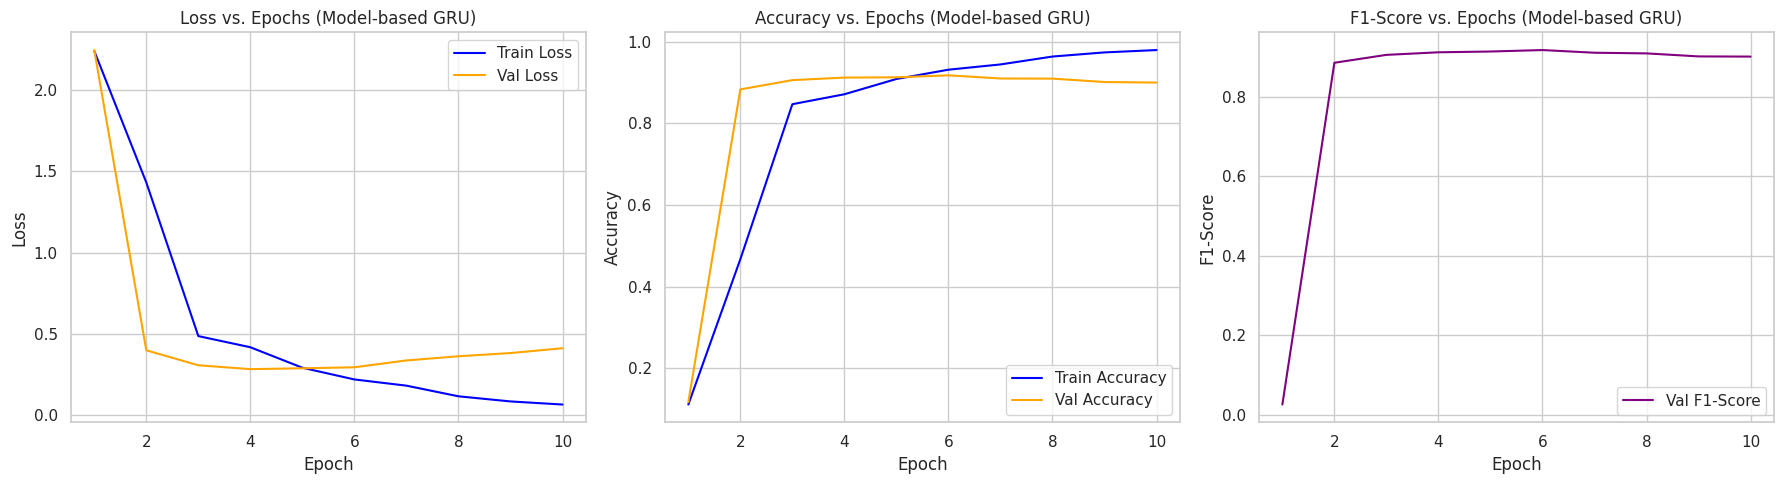

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st plot
sns.lineplot(x=range(1, len(train_losses) + 1), y=train_losses, label='Train Loss', color='blue')
sns.lineplot(x=range(1, len(val_losses) + 1), y=val_losses, label='Val Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs (Model-based GRU)')
plt.legend()

plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd plot
sns.lineplot(x=range(1, len(train_accuracies) + 1), y=train_accuracies, label='Train Accuracy', color='blue')
sns.lineplot(x=range(1, len(val_accuracies) + 1), y=val_accuracies, label='Val Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs (Model-based GRU)')
plt.legend()

plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd plot
sns.lineplot(x=range(1, len(val_f1s) + 1), y=val_f1s, label='Val F1-Score', color='purple')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('F1-Score vs. Epochs (Model-based GRU)')
plt.legend()

plt.tight_layout()
plt.show()

### Optimization phase

III.2.1 Optimizer selection

In [ ]:
num_epochs = 10
learning_rate = 1e-3
loss_function = torch.nn.CrossEntropyLoss()

optimizers = {
    'RMSprop': optim.RMSprop,
    'Adam': optim.Adam,
    'AdamW': optim.AdamW,
}

for optimizer_name, optimizer_class in optimizers.items():
    print(f"\n🔹 Training with optimizer: {optimizer_name}")

    model = GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, hidden_dim=335, num_layers=1,dropout_prob=0.3, embedding_weights=embedding_matrix, freeze_embeddings=False).to(device)
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)
    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge', project='Multi_Class_Optimizer_Comparison_gru_glove300d_Borderline-SMOTE', name=f"{optimizer_name}_run", config={
        'learning_rate': learning_rate,
        'num_epochs': num_epochs,
        'optimizer': optimizer_name,
        'model': 'GRU_Model',
        'embedding_dim': 300,
        'hidden_dim': 350,
        'dropout_prob': 0.5
    })

    print(model)
    num_params = count_parameters(model)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    # Progress bar for training
    with tqdm(total=num_epochs, desc=f"Optimizer: {optimizer_name}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(f"Optimizer: {optimizer_name} | Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train ACC: {train_acc:.2%}, Val ACC: {val_acc:.2%}, Time: {epoch_duration / 60:.2f} min")
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1,
            })

    wandb.finish()


🔹 Training with optimizer: RMSprop


train_acc,▁▂▃▅▆▂█
train_loss,▆▄▃▁▁█▃
val_acc,█▇▁█▁█▇
val_f1,█▇▁█▁██
val_loss,▁▂▃▅█▄▃
train_acc,0.11933
train_loss,2.19179
val_acc,0.1159
val_f1,0.02979
val_loss,2.19932


GRU_Model(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 335, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=335, out_features=9, bias=True)
)
Total trainable parameters: 12643809


Optimizer: RMSprop | Epoch 10/10 - Train Loss: 0.2813, Val Loss: 0.2708, Train ACC: 91.09%, Val ACC: 92.03%, Time: 0.44 min: 100%|██████████| 10/10 [04:24<00:00, 26.49s/epoch]


train_acc,▁▁▁▁▁▁▁▇██
train_loss,███████▂▁▁
val_acc,▁▁▁▁▁▁▂███
val_f1,▁▁▁▁▁▁▂███
val_loss,███████▁▁▁
train_acc,0.91087
train_loss,0.28129
val_acc,0.92032
val_f1,0.9198
val_loss,0.27084



🔹 Training with optimizer: Adam


GRU_Model(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 335, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=335, out_features=9, bias=True)
)
Total trainable parameters: 12643809


Optimizer: Adam | Epoch 10/10 - Train Loss: nan, Val Loss: nan, Train ACC: 11.11%, Val ACC: 12.21%, Time: 0.39 min: 100%|██████████| 10/10 [04:01<00:00, 24.12s/epoch]


train_acc,▁▄█▃▃▃▃▃▃▃
train_loss,█▁
val_acc,█▁████████
val_f1,█▁▆▆▆▆▆▆▆▆
val_loss,█▁
train_acc,0.11111
train_loss,nan
val_acc,0.12211
val_f1,0.02658
val_loss,nan



🔹 Training with optimizer: AdamW


GRU_Model(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 335, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=335, out_features=9, bias=True)
)
Total trainable parameters: 12643809


Optimizer: AdamW | Epoch 10/10 - Train Loss: 2.1856, Val Loss: 2.2050, Train ACC: 11.81%, Val ACC: 11.64%, Time: 0.45 min: 100%|██████████| 10/10 [04:29<00:00, 26.93s/epoch]


train_acc,▁▂▇▄▅▃▆▇▇█
train_loss,█▆▄█▅▂▁▁▁▁
val_acc,▁▇▇█▇██▁▇▇
val_f1,▁▇▇█▆██▂▇▇
val_loss,▂▂▃▄▁▄▄▇█▆
train_acc,0.11814
train_loss,2.18558
val_acc,0.11642
val_f1,0.0268
val_loss,2.205


---

III.2.2 Learning rate value selection

In [ ]:
learning_rates = [1e-3, 2e-3, 5e-3]

for lr in learning_rates:
    print(f"\n🔹 Training with RMSprop and learning rate: {lr}")

    model = GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, hidden_dim=335, num_layers=1,dropout_prob=0.3, embedding_weights=embedding_matrix, freeze_embeddings=False).to(device)
    optimizer = optim.RMSprop(model.parameters(), lr=lr)
    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge', project='Multi_Class_learning_rate_tuning_gru_glove300d_Borderline-SMOTE', name=f"RMSprop_lr_{lr}", config={
        'learning_rate': lr,
        'num_epochs': num_epochs,
        'optimizer': 'RMPprop',
        'model': 'GRU_Model',
        'embedding_dim': 300,
        'hidden_dim': 350,
        'dropout_prob': 0.5
    })

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []
    with tqdm(total=num_epochs, desc=f"LR: {lr}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(f"LR: {lr} | Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train ACSA: {train_acc:.2%}, Val ACSA: {val_acc:.2%}, Time: {epoch_duration / 60:.2f} min")
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1
            })

    wandb.finish()


🔹 Training with RMSprop and learning rate: 0.001


LR: 0.001 | Epoch 10/10 - Train Loss: 2.1856, Val Loss: 2.2084, Train ACSA: 11.60%, Val ACSA: 7.19%, Time: 0.44 min: 100%|██████████| 10/10 [04:24<00:00, 26.46s/epoch]


train_acc,▂▁█▇▇▃▄▆▆▆
train_loss,▇▅▇▃▁▁▁█▁▁
val_acc,██▇▁█▇▇█▇▁
val_f1,▃▃▃▁▃█▃▃▃▁
val_loss,▂▁█▄▃▅▅▄▄▅
train_acc,0.11602
train_loss,2.18562
val_acc,0.07192
val_f1,0.01184
val_loss,2.20845



🔹 Training with RMSprop and learning rate: 0.002


LR: 0.002 | Epoch 10/10 - Train Loss: 0.0421, Val Loss: 0.4527, Train ACSA: 98.59%, Val ACSA: 90.72%, Time: 0.44 min: 100%|██████████| 10/10 [04:25<00:00, 26.56s/epoch]


train_acc,▁▅▆▇██████
train_loss,█▄▃▂▂▁▁▁▁▁
val_acc,▁█▇▅▄▂▃▄▃▃
val_f1,▁█▇▅▄▂▃▄▃▃
val_loss,▃▁▂▄▅▆▆▇██
train_acc,0.98588
train_loss,0.04206
val_acc,0.90721
val_f1,0.90776
val_loss,0.45274



🔹 Training with RMSprop and learning rate: 0.005


LR: 0.005 | Epoch 10/10 - Train Loss: nan, Val Loss: nan, Train ACSA: 11.11%, Val ACSA: 12.21%, Time: 0.38 min: 100%|██████████| 10/10 [03:48<00:00, 22.88s/epoch]


train_acc,█▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁
val_f1,▁▁▁▁▁▁▁▁▁▁
train_acc,0.11111
train_loss,nan
val_acc,0.12211
val_f1,0.02658
val_loss,nan


---

III.1.3 Hidden dimension value selection

In [ ]:
hidden_dims = [100, 250, 400]
learning_rate = 1e-3

for hidden_dim in hidden_dims:
    print(f"\n🔹 Training with hidden_dim: {hidden_dim}\n")
    run_name = f"GRU_Hidden_{hidden_dim}"

    model = GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, hidden_dim=335, num_layers=1,dropout_prob=0.3, embedding_weights=embedding_matrix, freeze_embeddings=False).to(device)
    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project="Multi_Class_GRU-Hidden-Tuning-glove300d_Attention_Borderline-SMOTE",
        name=run_name,
        config={
            "embedding_dim": EMBEDDING_DIM,
            "learning_rate": learning_rate,
            "epochs": num_epochs,
            "hidden_dim": 200,
            "dropout": 0.4,
            "optimizer": "RMSprop"
        }
    )

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    with tqdm(total=num_epochs, desc=f"Training with Hidden={hidden_dim}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with hidden_dim: 100



Epoch 10/10 - Train Loss: 2.1961, Val Loss: 2.2033, Train Acc: 11.21%, Val Acc: 11.56%, Val F-1: 2.47%,, Time: 0.44 min: 100%|██████████| 10/10 [04:24<00:00, 26.49s/epoch]


train_acc,▁█▃▇▄▄▆█▃▄
train_loss,▃▂▃▂▂▅▁█▂▂
val_acc,█▁█▆▆▁▆▆▆▆
val_f1,█▂█▆▅▁▅▆▆▅
val_loss,▁▂▂▂▅▃█▂▅▄
train_acc,0.11207
train_loss,2.19613
val_acc,0.11556
val_f1,0.02472
val_loss,2.20333



🔹 Training with hidden_dim: 250



Epoch 10/10 - Train Loss: 0.2598, Val Loss: 0.3634, Train Acc: 92.15%, Val Acc: 90.08%, Val F-1: 90.12%,, Time: 0.45 min: 100%|██████████| 10/10 [04:27<00:00, 26.78s/epoch]


train_acc,▁▁▁▁▁▃▇███
train_loss,█████▆▃▂▁▁
val_acc,▁▁▁▁▁▆████
val_f1,▁▁▁▁▁▅████
val_loss,█████▃▁▁▁▁
train_acc,0.92151
train_loss,0.25976
val_acc,0.90083
val_f1,0.90118
val_loss,0.36339



🔹 Training with hidden_dim: 400



Epoch 10/10 - Train Loss: 2.1920, Val Loss: 2.2059, Train Acc: 11.38%, Val Acc: 11.57%, Val F-1: 2.48%,, Time: 0.45 min: 100%|██████████| 10/10 [04:27<00:00, 26.75s/epoch]


train_acc,▁▂▁▄██▃▅▄▄
train_loss,▃▃▂▆█▁▂▆▂▂
val_acc,▄▄▃▃█▁▄▁▄▄
val_f1,▃▃▂▂█▁▃▁▂▃
val_loss,▇▆▇▇▁▇▇█▇▇
train_acc,0.1138
train_loss,2.19197
val_acc,0.11573
val_f1,0.02476
val_loss,2.20591


---

III.2.4 Depth value selection

In [ ]:
depth_values = [1, 2, 3]

for num_layers in depth_values:
    print(f"\n🔹 Training with GRU Depth (num_layers): {num_layers}\n")
    run_name = f"GRU_Depth_{num_layers}"
    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project="Multi-Class-GRU-Depth-Tuning-glove300d_Borderline-SMOTE",
        name=run_name,
        config={
            "num_layers": num_layers,
            "learning_rate": learning_rate,
            "hidden_dim":350,
            "dropout":0.4,
            "optimizer": "RMSprop"
        }
    )
    model = GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, hidden_dim=335, num_layers=1,dropout_prob=0.3, embedding_weights=embedding_matrix, freeze_embeddings=False).to(device)
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    with tqdm(total=num_epochs, desc=f"Training with GRU Depth={num_layers}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with GRU Depth (num_layers): 1



Epoch 10/10 - Train Loss: 0.2683, Val Loss: 0.2798, Train Acc: 91.54%, Val Acc: 91.53%, Val F-1: 91.49%,, Time: 0.44 min: 100%|██████████| 10/10 [04:24<00:00, 26.50s/epoch]


train_acc,▁▁▁▁▁▁▂▇██
train_loss,██████▇▂▁▁
val_acc,▁▁▁▁▁▁▇███
val_f1,▁▁▁▁▁▂▇███
val_loss,██████▃▁▁▁
train_acc,0.91541
train_loss,0.26826
val_acc,0.91532
val_f1,0.91486
val_loss,0.27981



🔹 Training with GRU Depth (num_layers): 2



Epoch 10/10 - Train Loss: 2.2020, Val Loss: 2.2124, Train Acc: 11.36%, Val Acc: 9.87%, Val F-1: 2.09%,, Time: 0.44 min: 100%|██████████| 10/10 [04:24<00:00, 26.45s/epoch]


train_acc,▂▃▁▂▅▄▅█▆▃
train_loss,▆▄█▇▃▂▂▁▆▇
val_acc,▁▇▇▇▇█▅█▇▅
val_f1,▁▃▃▃▄▄▂▄█▂
val_loss,▄▁▂▃▃▂▅▅▃█
train_acc,0.11363
train_loss,2.20203
val_acc,0.09865
val_f1,0.02093
val_loss,2.21239



🔹 Training with GRU Depth (num_layers): 3



Epoch 10/10 - Train Loss: 0.0524, Val Loss: 0.4440, Train Acc: 98.37%, Val Acc: 90.84%, Val F-1: 90.87%,, Time: 0.44 min: 100%|██████████| 10/10 [04:25<00:00, 26.58s/epoch]


train_acc,▁▄▇▇▇█████
train_loss,█▆▂▂▂▁▁▁▁▁
val_acc,▁█████████
val_f1,▁█████████
val_loss,█▁▁▁▁▁▁▂▁▂
train_acc,0.98366
train_loss,0.05244
val_acc,0.90842
val_f1,0.90867
val_loss,0.44403


---

III.2.5 Batch value selection

In [ ]:
batch_sizes = [8, 16, 64]

for batch_size in batch_sizes:
    print(f"\n🔹 Training with batch size: {batch_size}")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

    model = GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, hidden_dim=335, num_layers=1,dropout_prob=0.3, embedding_weights=embedding_matrix, freeze_embeddings=False).to(device)
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project="Multi-Class-batch_size_comparison_gru_glove300d_Borderline-SMOTE",
        name=f"GRU_Batch_{batch_size}",
        config={
            "batch_size": batch_size,
            "learning_rate": learning_rate,
            "num_epochs": num_epochs,
            "optimizer": "RMSprop",
            "hidden_dim": 250,
            "dropout_prob": 0.4
        }
    )

    print(model)
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    with tqdm(total=num_epochs, desc=f"Training with Embedding={hidden_dim}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with batch size: 8


GRU_Model(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 335, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=335, out_features=9, bias=True)
)
Total trainable parameters: 12643809


Epoch 10/10 - Train Loss: 0.0728, Val Loss: 0.4546, Train Acc: 98.18%, Val Acc: 90.96%, Val F-1: 90.94%,, Time: 1.44 min: 100%|██████████| 10/10 [14:26<00:00, 86.61s/epoch]


train_acc,▁▇▇███████
train_loss,█▃▂▂▁▁▁▁▁▁
val_acc,▁█████████
val_f1,▁█████████
val_loss,█▁▁▁▁▂▂▂▂▂
train_acc,0.98184
train_loss,0.0728
val_acc,0.90962
val_f1,0.90938
val_loss,0.45464



🔹 Training with batch size: 16


GRU_Model(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 335, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=335, out_features=9, bias=True)
)
Total trainable parameters: 12643809


Epoch 10/10 - Train Loss: 0.0588, Val Loss: 0.4255, Train Acc: 98.37%, Val Acc: 90.76%, Val F-1: 90.70%,, Time: 0.88 min: 100%|██████████| 10/10 [08:47<00:00, 52.75s/epoch]


train_acc,▁▁▅▇██████
train_loss,██▅▂▂▁▁▁▁▁
val_acc,▁▁████████
val_f1,▁▁████████
val_loss,██▁▁▁▁▁▂▂▂
train_acc,0.98366
train_loss,0.05876
val_acc,0.90755
val_f1,0.907
val_loss,0.42549



🔹 Training with batch size: 64


GRU_Model(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 335, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=335, out_features=9, bias=True)
)
Total trainable parameters: 12643809


Epoch 10/10 - Train Loss: 0.0759, Val Loss: 0.4124, Train Acc: 97.82%, Val Acc: 90.63%, Val F-1: 90.62%,, Time: 0.45 min: 100%|██████████| 10/10 [04:30<00:00, 27.04s/epoch]


train_acc,▁▁▁▁▆▇▇███
train_loss,████▃▂▂▁▁▁
val_acc,▁▁▁▅██████
val_f1,▁▁▁▅██████
val_loss,███▅▁▁▁▁▁▂
train_acc,0.97822
train_loss,0.0759
val_acc,0.90635
val_f1,0.90617
val_loss,0.41241


---

---
## III.2 **Borderline-SMOTE - GLOVE (300d) - GRU - Bahdanau Attention**

### Validation phase

In [ ]:
model = GloVe_GRU_BahdanauAttention(embedding_matrix=embedding_matrix, hidden_dim=200, num_layers=1, dropout_prob=0.8).to(device)
print(model)

num_params = count_parameters(model)
print(f"Total trainable parameters: {num_params}")

GloVe_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 200, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=400, out_features=200, bias=True)
    (v): Linear(in_features=200, out_features=1, bias=False)
  )
  (fc): Linear(in_features=400, out_features=9, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)
Total trainable parameters: 12687009


In [ ]:
learning_rate = 1e-4
num_epochs = 6
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-5)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
val_f1s = []

with tqdm(total=num_epochs, desc="Training Progress", unit="epoch") as pbar:
    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1s.append(val_f1)

        end_time = time.time()
        epoch_duration = end_time - start_time

        pbar.set_description(
            f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
            f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F1: {val_f1:.2%}, Time: {epoch_duration / 60:.2f} min"
        )
        pbar.update(1)

Epoch 6/6 - Train Loss: 0.4310, Val Loss: 0.2848, Train Acc: 86.38%, Val Acc: 91.26%, Val F1: 91.19%, Time: 0.51 min: 100%|██████████| 6/6 [03:01<00:00, 30.30s/epoch]


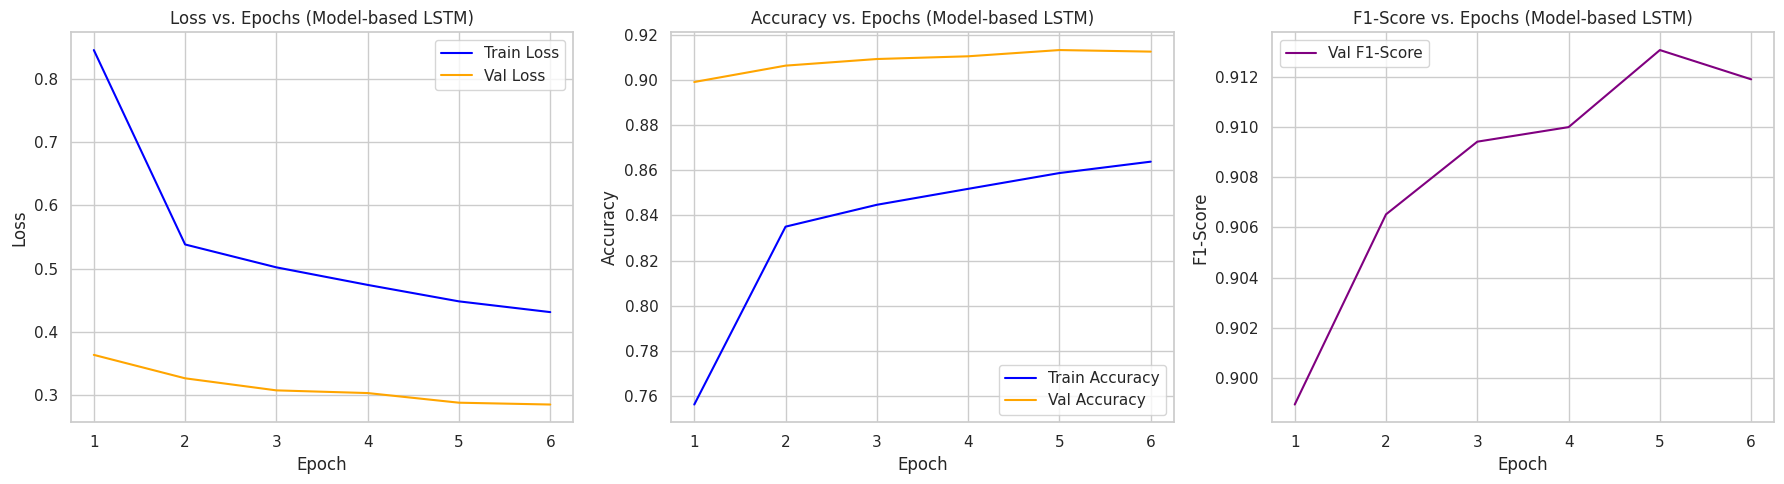

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st plot
sns.lineplot(x=range(1, len(train_losses) + 1), y=train_losses, label='Train Loss', color='blue')
sns.lineplot(x=range(1, len(val_losses) + 1), y=val_losses, label='Val Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs (Model-based LSTM)')
plt.legend()

plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd plot
sns.lineplot(x=range(1, len(train_accuracies) + 1), y=train_accuracies, label='Train Accuracy', color='blue')
sns.lineplot(x=range(1, len(val_accuracies) + 1), y=val_accuracies, label='Val Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs (Model-based LSTM)')
plt.legend()

plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd plot
sns.lineplot(x=range(1, len(val_f1s) + 1), y=val_f1s, label='Val F1-Score', color='purple')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('F1-Score vs. Epochs (Model-based LSTM)')
plt.legend()

plt.tight_layout()
plt.show()

### Optimization phase

III.3.1 Optimizer selection

In [ ]:
learning_rate = 1e-4
loss_function = torch.nn.CrossEntropyLoss()

optimizers = {
    'RMSprop': optim.RMSprop,
    'Adam': optim.Adam,
    'AdamW': optim.AdamW,
}

for optimizer_name, optimizer_class in optimizers.items():
    print(f"\n🔹 Training with optimizer: {optimizer_name}")

    model = GloVe_GRU_BahdanauAttention(embedding_matrix=embedding_matrix, hidden_dim=200, num_layers=1, dropout_prob=0.8).to(device)
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)
    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge', project='Multi_Class_Optimizer_Comparison_gru_glove300d_Attention_Borderline-SMOTE', name=f"{optimizer_name}_run", config={
        'learning_rate': learning_rate,
        'num_epochs': num_epochs,
        'optimizer': optimizer_name,
        'model': 'GRU_Model',
        'embedding_dim': 300,
        'hidden_dim': 200,
        'dropout_prob': 0.5
    })

    print(model)
    num_params = count_parameters(model)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    # Progress bar for training
    with tqdm(total=num_epochs, desc=f"Optimizer: {optimizer_name}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(f"Optimizer: {optimizer_name} | Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train ACC: {train_acc:.2%}, Val ACC: {val_acc:.2%}, Time: {epoch_duration / 60:.2f} min")
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1,
            })

    wandb.finish()


🔹 Training with optimizer: RMSprop


GloVe_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 200, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=400, out_features=200, bias=True)
    (v): Linear(in_features=200, out_features=1, bias=False)
  )
  (fc): Linear(in_features=400, out_features=9, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)
Total trainable parameters: 12687009


Optimizer: RMSprop | Epoch 6/6 - Train Loss: 0.3702, Val Loss: 0.2805, Train ACC: 88.47%, Val ACC: 91.93%, Time: 0.91 min: 100%|██████████| 6/6 [05:29<00:00, 54.90s/epoch]


train_acc,▁▅▆▇▇█
train_loss,█▄▃▂▂▁
val_acc,▁▃▇▇██
val_f1,▁▃▇▇██
val_loss,█▄▂▁▁▁
train_acc,0.88475
train_loss,0.37021
val_acc,0.91928
val_f1,0.91903
val_loss,0.28047



🔹 Training with optimizer: Adam


GloVe_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 200, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=400, out_features=200, bias=True)
    (v): Linear(in_features=200, out_features=1, bias=False)
  )
  (fc): Linear(in_features=400, out_features=9, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)
Total trainable parameters: 12687009


Optimizer: Adam | Epoch 6/6 - Train Loss: 0.3443, Val Loss: 0.2807, Train ACC: 89.49%, Val ACC: 91.69%, Time: 0.94 min: 100%|██████████| 6/6 [05:37<00:00, 56.32s/epoch]


train_acc,▁▆▆▇▇█
train_loss,█▃▃▂▁▁
val_acc,▁▃▅██▇
val_f1,▁▃▄██▇
val_loss,█▅▄▁▁▃
train_acc,0.89486
train_loss,0.34431
val_acc,0.91687
val_f1,0.91648
val_loss,0.2807



🔹 Training with optimizer: AdamW


GloVe_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 200, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=400, out_features=200, bias=True)
    (v): Linear(in_features=200, out_features=1, bias=False)
  )
  (fc): Linear(in_features=400, out_features=9, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)
Total trainable parameters: 12687009


Optimizer: AdamW | Epoch 6/6 - Train Loss: 0.3446, Val Loss: 0.2893, Train ACC: 89.31%, Val ACC: 91.67%, Time: 0.96 min: 100%|██████████| 6/6 [05:43<00:00, 57.27s/epoch]


train_acc,▁▆▆▇██
train_loss,█▃▃▂▁▁
val_acc,▁▄▆█▇▇
val_f1,▁▄▆█▇▇
val_loss,█▄▂▁▂▃
train_acc,0.89313
train_loss,0.3446
val_acc,0.9167
val_f1,0.91621
val_loss,0.28932


---

III.3.2 Learning rate value selection

In [ ]:
learning_rates = [9e-5, 7e-5, 8e-5]

for lr in learning_rates:
    print(f"\n🔹 Training with RMSprop and learning rate: {lr}")

    model = GloVe_GRU_BahdanauAttention(embedding_matrix=embedding_matrix, hidden_dim=200, num_layers=1, dropout_prob=0.8).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge', project='Multi_Class_learning_rate_tuning_gru_glove300d_Attention_Borderline-SMOTE', name=f"RMSprop_lr_{lr}", config={
        'learning_rate': lr,
        'num_epochs': num_epochs,
        'optimizer': 'RMPprop',
        'model': 'GRU_Model',
        'embedding_dim': 300,
        'hidden_dim': 200,
        'dropout_prob': 0.5
    })

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []
    with tqdm(total=num_epochs, desc=f"LR: {lr}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(f"LR: {lr} | Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train ACSA: {train_acc:.2%}, Val ACSA: {val_acc:.2%}, Time: {epoch_duration / 60:.2f} min")
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1
            })

    wandb.finish()


🔹 Training with RMSprop and learning rate: 9e-05


LR: 9e-05 | Epoch 6/6 - Train Loss: 0.3701, Val Loss: 0.2731, Train ACSA: 88.70%, Val ACSA: 91.84%, Time: 0.96 min: 100%|██████████| 6/6 [05:46<00:00, 57.67s/epoch]


train_acc,▁▆▆▇██
train_loss,█▃▂▂▁▁
val_acc,▁▅▇█▇█
val_f1,▁▅▆█▆█
val_loss,█▄▂▂▁▁
train_acc,0.887
train_loss,0.37009
val_acc,0.91842
val_f1,0.91826
val_loss,0.27308



🔹 Training with RMSprop and learning rate: 7e-05


LR: 7e-05 | Epoch 6/6 - Train Loss: 0.3933, Val Loss: 0.2743, Train ACSA: 87.75%, Val ACSA: 91.93%, Time: 0.96 min: 100%|██████████| 6/6 [05:45<00:00, 57.65s/epoch]


train_acc,▁▆▇▇██
train_loss,█▃▂▂▁▁
val_acc,▁▄▅▅▆█
val_f1,▁▄▅▅▆█
val_loss,█▅▃▂▂▁
train_acc,0.87745
train_loss,0.39335
val_acc,0.91928
val_f1,0.91906
val_loss,0.27427



🔹 Training with RMSprop and learning rate: 8e-05


LR: 8e-05 | Epoch 6/6 - Train Loss: 0.3838, Val Loss: 0.2754, Train ACSA: 88.03%, Val ACSA: 91.98%, Time: 0.96 min: 100%|██████████| 6/6 [05:45<00:00, 57.65s/epoch]


train_acc,▁▆▇▇██
train_loss,█▃▂▂▁▁
val_acc,▁▅▅▇██
val_f1,▁▅▅▇██
val_loss,█▅▃▂▁▂
train_acc,0.8803
train_loss,0.3838
val_acc,0.9198
val_f1,0.91933
val_loss,0.27539


---

III.3.3 Hidden dimension value selection

In [ ]:
hidden_dims = [100, 250, 400]
learning_rate = 1e-4

for hidden_dim in hidden_dims:
    print(f"\n🔹 Training with hidden_dim: {hidden_dim}\n")
    run_name = f"GRU_Hidden_{hidden_dim}"

    model = GloVe_GRU_BahdanauAttention(embedding_matrix=embedding_matrix, hidden_dim=200, num_layers=1, dropout_prob=0.8).to(device)
    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project="Multi_Class_GRU-Hidden-Tuning-glove300d_Attention_Borderline-SMOTE",
        name=run_name,
        config={
            "embedding_dim": EMBEDDING_DIM,
            "learning_rate": learning_rate,
            "epochs": num_epochs,
            "hidden_dim": 200,
            "dropout": 0.4,
            "optimizer": "RMSprop"
        }
    )

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    with tqdm(total=num_epochs, desc=f"Training with Hidden={hidden_dim}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with hidden_dim: 100



Epoch 6/6 - Train Loss: 0.4299, Val Loss: 0.2791, Train Acc: 86.45%, Val Acc: 91.51%, Val F-1: 91.49%,, Time: 0.48 min: 100%|██████████| 6/6 [02:55<00:00, 29.20s/epoch]


train_acc,▁▆▇▇██
train_loss,█▃▂▂▁▁
val_acc,▁▄▅▆▇█
val_f1,▁▄▅▆▇█
val_loss,█▅▄▂▂▁
train_acc,0.86446
train_loss,0.42994
val_acc,0.91514
val_f1,0.9149
val_loss,0.27913



🔹 Training with hidden_dim: 250



Epoch 6/6 - Train Loss: 0.4333, Val Loss: 0.2889, Train Acc: 86.48%, Val Acc: 91.24%, Val F-1: 91.19%,, Time: 0.48 min: 100%|██████████| 6/6 [02:54<00:00, 29.14s/epoch]


train_acc,▁▆▇▇▇█
train_loss,█▃▂▂▁▁
val_acc,▁▄▆███
val_f1,▁▄▆███
val_loss,█▅▃▁▁▁
train_acc,0.86476
train_loss,0.43325
val_acc,0.91238
val_f1,0.91186
val_loss,0.2889



🔹 Training with hidden_dim: 400



Epoch 5/6 - Train Loss: 0.4467, Val Loss: 0.2823, Train Acc: 85.94%, Val Acc: 91.53%, Val F-1: 91.49%,, Time: 0.49 min:  83%|████████▎ | 5/6 [02:25<00:29, 29.15s/epoch]

---

III.3.4 Depth value selection

In [ ]:
depth_values = [1, 2, 3]

for num_layers in depth_values:
    print(f"\n🔹 Training with GRU Depth (num_layers): {num_layers}\n")
    run_name = f"GRU_Depth_{num_layers}"
    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project="Multi-Class-GRU-Depth-Tuning-glove300d_Attention_Borderline-SMOTE",
        name=run_name,
        config={
            "num_layers": num_layers,
            "learning_rate": learning_rate,
            "hidden_dim":200,
            "dropout":0.8,
            "optimizer": "RMSprop"
        }
    )
    model = GloVe_GRU_BahdanauAttention(embedding_matrix=embedding_matrix, hidden_dim=200, num_layers=1, dropout_prob=0.8).to(device)
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    with tqdm(total=num_epochs, desc=f"Training with GRU Depth={num_layers}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with GRU Depth (num_layers): 1



Epoch 6/6 - Train Loss: 0.3919, Val Loss: 0.2714, Train Acc: 87.76%, Val Acc: 92.14%, Val F-1: 92.10%,, Time: 0.92 min: 100%|██████████| 6/6 [05:32<00:00, 55.49s/epoch]


train_acc,▁▅▆▇██
train_loss,█▃▃▂▁▁
val_acc,▁▄▅▆▆█
val_f1,▁▄▅▆▆█
val_loss,█▄▃▁▁▁
train_acc,0.87762
train_loss,0.39189
val_acc,0.92135
val_f1,0.92095
val_loss,0.27139



🔹 Training with GRU Depth (num_layers): 2



Epoch 6/6 - Train Loss: 0.3904, Val Loss: 0.2746, Train Acc: 87.90%, Val Acc: 92.07%, Val F-1: 92.08%,, Time: 0.96 min: 100%|██████████| 6/6 [05:34<00:00, 55.82s/epoch]


train_acc,▁▅▆▇▇█
train_loss,█▄▃▂▁▁
val_acc,▁▃▆▅▇█
val_f1,▁▃▆▅▇█
val_loss,█▅▃▂▂▁
train_acc,0.87904
train_loss,0.39035
val_acc,0.92066
val_f1,0.92083
val_loss,0.27463



🔹 Training with GRU Depth (num_layers): 3



Epoch 6/6 - Train Loss: 0.3960, Val Loss: 0.2728, Train Acc: 87.71%, Val Acc: 91.79%, Val F-1: 91.74%,, Time: 0.92 min: 100%|██████████| 6/6 [05:33<00:00, 55.54s/epoch]


train_acc,▁▆▆▇██
train_loss,█▃▂▂▁▁
val_acc,▁▃▅▇▆█
val_f1,▁▄▅▇▇█
val_loss,█▄▃▁▂▁
train_acc,0.87712
train_loss,0.39598
val_acc,0.9179
val_f1,0.91738
val_loss,0.27279


---

III.3.5 Batch size value selection

In [ ]:
batch_sizes = [8, 16, 64]

for batch_size in batch_sizes:
    print(f"\n🔹 Training with batch size: {batch_size}")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

    GloVe_GRU_BahdanauAttention(embedding_matrix=embedding_matrix, hidden_dim=200, num_layers=1, dropout_prob=0.8).to(device)
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project="Multi-Class-batch_size_comparison_gru_glove300d_Attention_Borderline-SMOTE",
        name=f"GRU_Batch_{batch_size}",
        config={
            "batch_size": batch_size,
            "learning_rate": learning_rate,
            "num_epochs": num_epochs,
            "optimizer": "RMSprop",
            "hidden_dim": 200,
            "dropout_prob": 0.8
        }
    )

    print(model)
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    with tqdm(total=num_epochs, desc=f"Training with Embedding={hidden_dim}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with batch size: 8


GloVe_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 200, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=400, out_features=200, bias=True)
    (v): Linear(in_features=200, out_features=1, bias=False)
  )
  (fc): Linear(in_features=400, out_features=9, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)
Total trainable parameters: 12687009


Epoch 6/6 - Train Loss: 0.1978, Val Loss: 0.3859, Train Acc: 94.57%, Val Acc: 91.41%, Val F-1: 91.43%,, Time: 1.78 min: 100%|██████████| 6/6 [10:37<00:00, 106.21s/epoch]


train_acc,▁▂▄▅▇█
train_loss,█▇▅▄▂▁
val_acc,▄▄▅█▇▁
val_f1,▄▄▄█▇▁
val_loss,▁▁▂▄▆█
train_acc,0.9457
train_loss,0.19777
val_acc,0.91411
val_f1,0.91425
val_loss,0.38586



🔹 Training with batch size: 16


GloVe_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 200, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=400, out_features=200, bias=True)
    (v): Linear(in_features=200, out_features=1, bias=False)
  )
  (fc): Linear(in_features=400, out_features=9, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)
Total trainable parameters: 12687009


Epoch 6/6 - Train Loss: 0.0768, Val Loss: 0.5015, Train Acc: 97.77%, Val Acc: 90.67%, Val F-1: 90.70%,, Time: 0.95 min: 100%|██████████| 6/6 [05:43<00:00, 57.25s/epoch]


train_acc,▁▄▅▆██
train_loss,█▆▄▃▂▁
val_acc,█▃▄▅▄▁
val_f1,█▃▃▄▄▁
val_loss,▁▃▅▅▆█
train_acc,0.97766
train_loss,0.07679
val_acc,0.90669
val_f1,0.90702
val_loss,0.50152



🔹 Training with batch size: 64


GloVe_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 200, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=400, out_features=200, bias=True)
    (v): Linear(in_features=200, out_features=1, bias=False)
  )
  (fc): Linear(in_features=400, out_features=9, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)
Total trainable parameters: 12687009


Epoch 6/6 - Train Loss: 0.0387, Val Loss: 0.5047, Train Acc: 98.61%, Val Acc: 90.39%, Val F-1: 90.37%,, Time: 0.50 min: 100%|██████████| 6/6 [02:58<00:00, 29.79s/epoch]


train_acc,▁▄▅▅█▇
train_loss,█▅▄▃▁▁
val_acc,█▁▂▄▃▅
val_f1,█▁▁▄▃▅
val_loss,▁▄▇▇█▇
train_acc,0.98608
train_loss,0.03869
val_acc,0.90393
val_f1,0.90374
val_loss,0.50472


---

---
# IV. **Test phase - Resampling Technique Comparison**
---

In [ ]:
def train_model(model, train_loader, test_loader, optimizer, criterion, num_epochs, model_name, technique_name, loss_gap_ratio=1.25, ax_accuracy_gap=5, device="cpu"):
    f1_scores = []
    balanced_accuracies = []
    recalls = []
    accuracies = []
    precisions = []

    model_metrics = {}
    saved_once = False
    best_model_wts = None
    best_f1 = 0

    with tqdm(total=num_epochs, desc=f"Training {model_name}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
            test_loss, test_acc, test_f1, test_balanced_acc, test_recall, test_precision = test_epoch(model, test_loader, criterion, device)

            wandb.log({
                "train_loss": train_loss,
                "test_loss": test_loss,
                "train_acc": train_acc,
                "test_acc": test_acc,
                "test_f1": test_f1,
                "test_balanced_acc": test_balanced_acc,
                "test_recall": test_recall,
                "test_precision": test_precision
            })

            f1_scores.append(test_f1)
            balanced_accuracies.append(test_balanced_acc)
            recalls.append(test_recall)
            accuracies.append(test_acc)
            precisions.append(test_precision)

            if (test_loss > train_loss * loss_gap_ratio or (train_acc > test_acc and train_acc - test_acc > ax_accuracy_gap / 100)) and not saved_once:
                best_model_wts = model.state_dict()
                torch.save(best_model_wts, f"{model_name}_{technique_name}_early_stopped.pth")
                saved_once = True
                break

            if test_f1 > best_f1:
                best_f1 = test_f1
                best_model_wts = model.state_dict()

            end_time = time.time()
            epoch_duration = end_time - start_time
            pbar.set_description(
                f"{model_name} Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, "
                f"Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%, Test F1: {test_f1:.2f}%, "
                f"Test Balanced Acc: {test_balanced_acc:.2f}%, Test Recall: {test_recall:.2f}%, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)

        if not saved_once:
            torch.save(best_model_wts, f"{model_name}_{technique_name}_final_best_model.pth")

    model_metrics[model_name] = {
        "f1_scores": f1_scores,
        "balanced_accuracies": balanced_accuracies,
        "recalls": recalls,
        "accuracies": accuracies,
        "precisions": precisions
    }

    return model_metrics

def train_model_with_class_weights(model, train_loader, test_loader, optimizer, class_weights, num_epochs, model_name, technique_name, loss_gap_ratio=1.25, ax_accuracy_gap=5, device="cpu"):
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    return train_model(model, train_loader, test_loader, optimizer, criterion, num_epochs, model_name, technique_name, loss_gap_ratio, ax_accuracy_gap, device)

def plot_comparison_histograms(metrics_dict, technique_names, model_family_name="Model", title=None):
    summary_metrics = {
        "Model": [],
        "F1 Score": [],
        "Balanced Accuracy": [],
        "Recall": [],
        "Precision": []
    }

    for model_name, metrics in metrics_dict.items():
        summary_metrics["Model"].append(model_name)
        summary_metrics["F1 Score"].append(max(metrics["f1_scores"]))
        summary_metrics["Balanced Accuracy"].append(max(metrics["balanced_accuracies"]))
        summary_metrics["Recall"].append(max(metrics["recalls"]))
        summary_metrics["Precision"].append(max(metrics["precisions"]))

    df_summary = pd.DataFrame(summary_metrics)
    df_melted = df_summary.melt(id_vars="Model", var_name="Metric", value_name="Score")

    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(10, 6))

    models = df_summary["Model"].tolist()
    palette = sns.color_palette("Set2", len(models))

    for i, metric in enumerate(df_melted["Metric"].unique()):
        data = df_melted[df_melted["Metric"] == metric]
        max_score = data["Score"].max()

        for j, (index, row) in enumerate(data.iterrows()):
            color = "crimson" if row["Score"] == max_score else palette[models.index(row["Model"])]
            bar = ax.bar(
                x=i - 0.3 + j * (0.6 / len(models)),
                height=row["Score"],
                width=0.6 / len(models),
                color=color,
                label=row["Model"] if i == 0 else "",
            )
            ax.text(
                x=bar[0].get_x() + bar[0].get_width() / 2,
                y=row["Score"] + 0.015,
                s=f"{row['Score']:.2f}",
                ha='center',
                va='bottom',
                fontsize=9,
                color='black',
                fontweight='bold' if row["Score"] == max_score else 'normal'
            )

    ax.set_xticks(range(len(df_melted["Metric"].unique())))
    ax.set_xticklabels(df_melted["Metric"].unique())
    ax.set_ylim(0, 1.05)
    ax.set_ylabel("Score")
    ax.set_title(title or f"Performance Metrics Overview of {model_family_name}")
    ax.grid(True, axis='y')

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), title=model_family_name, bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.tight_layout()
    plt.show()

In [ ]:
X_combined = torch.cat((X_train_tensor, X_val_tensor), dim=0)
y_combined = torch.cat((y_train_tensor, y_val_tensor), dim=0)
raw_text_combined = np.concatenate((X_train, X_val))

X_combined_np = X_combined.cpu().numpy()
y_combined_np = y_combined.cpu().numpy()

train_dataset_no_oversampling = TextDataset(X_combined, y_combined, raw_text_data=raw_text_combined)
train_loader_no_oversampling = DataLoader(train_dataset_no_oversampling, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled_np, y_resampled_np = smote.fit_resample(X_combined_np, y_combined_np)
X_resampled_tensor = torch.tensor(X_resampled_np, dtype=torch.float).to(device)
y_resampled_tensor = torch.tensor(y_resampled_np, dtype=torch.long).to(device)

train_dataset_smote = TextDataset(X_resampled_tensor, y_resampled_tensor, raw_text_data=raw_text_combined)
train_loader_smote = DataLoader(train_dataset_smote, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)

borderline_smote = BorderlineSMOTE(sampling_strategy='auto', random_state=42)
X_resampled_borderline_np, y_resampled_borderline_np = borderline_smote.fit_resample(X_combined_np, y_combined_np)
X_resampled_borderline_tensor = torch.tensor(X_resampled_borderline_np, dtype=torch.float).to(device)
y_resampled_borderline_tensor = torch.tensor(y_resampled_borderline_np, dtype=torch.long).to(device)

train_dataset_borderline_smote = TextDataset(X_resampled_borderline_tensor, y_resampled_borderline_tensor, raw_text_data=raw_text_combined)
train_loader_borderline_smote = DataLoader(train_dataset_borderline_smote, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)

<ipython-input-8-35ba822a06f8>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
<ipython-input-8-35ba822a06f8>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y_data, dtype=torch.long)
<ipython-input-8-35ba822a06f8>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)
<ipython-input-8-35ba822a06f8>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

###IV.1. CNN-LSTM

In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_tensor.cpu().numpy()), y=y_train_tensor.cpu().numpy())

embedding_dim_no_oversampling = 250
hidden_dim_no_oversampling = 167
dropout_prob_no_oversampling = 0.3
model_name_no_oversampling = "CNN_LSTM_No_Oversampling"
model_no_oversampling = CNN_LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=embedding_dim_no_oversampling, hidden_dim=hidden_dim_no_oversampling, num_layers=1, dropout_prob=dropout_prob_no_oversampling).to(device)
optimizer_no_oversampling = optim.AdamW(model_no_oversampling.parameters(), lr=7e-4)

embedding_dim_smote = 250
hidden_dim_smote = 200
dropout_prob_smote = 0.3
model_name_smote = "CNN_LSTM_SMOTE"
model_smote = CNN_LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=embedding_dim_smote, hidden_dim=hidden_dim_smote, num_layers=1, dropout_prob=dropout_prob_smote).to(device)
optimizer_smote = optim.AdamW(model_smote.parameters(), lr=7e-4)

embedding_dim_borderline_smote = 280
hidden_dim_borderline_smote = 200
dropout_prob_borderline_smote = 0.3
model_name_borderline_smote = "CNN_LSTM_Borderline_SMOTE"
model_borderline_smote = CNN_LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=embedding_dim_borderline_smote, hidden_dim=hidden_dim_borderline_smote, num_layers=1, dropout_prob=dropout_prob_borderline_smote).to(device)
optimizer_borderline_smote = optim.AdamW(model_borderline_smote.parameters(), lr=7e-4)

embedding_dim_class_weights = 250
hidden_dim_class_weights = 200
dropout_prob_class_weights = 0.3
model_name_class_weights = "CNN_LSTM_class_weights"
model_class_weights = CNN_LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=embedding_dim_class_weights, hidden_dim=hidden_dim_class_weights, num_layers=1, dropout_prob=dropout_prob_class_weights).to(device)
optimizer_class_weights = optim.Adam(model_class_weights.parameters(), lr=9e-4)

criterion = nn.CrossEntropyLoss()

wandb.init(entity='wilfried-mvomoeto-university-of-li-ge', project="Resampling Technique Comparison - CNN-LSTM", name="Borderline-SMOTE")

# Borderline-SMOTE
metrics_borderline_smote = train_model(
    model_borderline_smote,
    train_loader_borderline_smote,
    test_loader,
    optimizer_borderline_smote,
    criterion,
    num_epochs=40,
    model_name=model_name_borderline_smote,
    technique_name="Borderline-SMOTE",
    device=device
)

wandb.init(entity='wilfried-mvomoeto-university-of-li-ge', project="Resampling Technique Comparison - CNN-LSTM", name="Class Weights")

# Class Weights
metrics_class_weights = train_model_with_class_weights(
    model_class_weights,
    train_loader_no_oversampling,
    test_loader,
    optimizer_class_weights,
    class_weights_tensor,
    num_epochs=40,
    model_name=model_name_class_weights,
    technique_name="Class Weights",
    device=device
)

wandb.init(entity='wilfried-mvomoeto-university-of-li-ge', project="Resampling Technique Comparison - CNN-LSTM", name="No Oversampling")

# No Oversampling
metrics_no_oversampling = train_model(
    model_no_oversampling,
    train_loader_no_oversampling,
    test_loader,
    optimizer_no_oversampling,
    criterion,
    num_epochs=40,
    model_name=model_name_no_oversampling,
    technique_name="No Oversampling",
    device=device
)

wandb.init(entity='wilfried-mvomoeto-university-of-li-ge', project="Resampling Technique Comparison - CNN-LSTM", name="SMOTE")

# SMOTE
metrics_smote = train_model(
    model_smote,
    train_loader_smote,
    test_loader,
    optimizer_smote,
    criterion,
    num_epochs=40,
    model_name=model_name_smote,
    technique_name="SMOTE",
    device=device
)

# Dictionary of metrics for all techniques
metrics_dict = {
    "No Oversampling": metrics_no_oversampling[model_name_no_oversampling],
    "SMOTE": metrics_smote[model_name_smote],
    "Borderline-SMOTE": metrics_borderline_smote[model_name_borderline_smote],
    "Class Weights": metrics_class_weights[model_name_class_weights]
}

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: wilfried-mvomoeto (wilfried-mvomoeto-university-of-li-ge) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


CNN_LSTM_Borderline_SMOTE Epoch 15/40 - Train Loss: 0.3689, Test Loss: 0.4128, Train Acc: 0.89%, Test Acc: 0.88%, Test F1: 0.88%, Test Balanced Acc: 0.88%, Test Recall: 0.88%, Time: 0.61 min:  38%|███▊      | 15/40 [09:50<16:24, 39.37s/epoch]


test_acc,▁▁▁▁▁▁▁▁▁▄▅▇████
test_balanced_acc,▁▁▁▁▁▁▁▁▁▃▄▇████
test_f1,▁▁▁▁▁▁▁▁▁▄▄▇████
test_loss,█████████▅▄▂▁▁▁▁
test_precision,▁▂▁▁▁▁▁▁▂▄▅▇████
test_recall,▁▁▁▁▁▁▁▁▁▄▅▇████
train_acc,▁▁▁▁▁▁▁▁▁▂▄▆▇███
train_loss,█████████▇▅▃▂▁▁▁
test_acc,0.89151
test_balanced_acc,0.89526
test_f1,0.89248


CNN_LSTM_class_weights Epoch 24/40 - Train Loss: 0.2993, Test Loss: 0.3735, Train Acc: 0.91%, Test Acc: 0.88%, Test F1: 0.89%, Test Balanced Acc: 0.89%, Test Recall: 0.88%, Time: 0.52 min:  60%|██████    | 24/40 [13:03<08:42, 32.66s/epoch]


test_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▄▄▅█████
test_balanced_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▄▄▅█████
test_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▄▄▅█████
test_loss,████████████████▇▅▅▃▁▁▁▁▁
test_precision,▁▁▂▂▂▁▁▂▂▂▂▂▂▁▂▂▂▄▄▅█████
test_recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▄▄▅█████
train_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▄▅▆████
train_loss,█████████████████▆▅▄▃▁▁▁▁
test_acc,0.88099
test_balanced_acc,0.88367
test_f1,0.88094


CNN_LSTM_No_Oversampling Epoch 30/40 - Train Loss: 0.3147, Test Loss: 0.3768, Train Acc: 0.91%, Test Acc: 0.89%, Test F1: 0.89%, Test Balanced Acc: 0.89%, Test Recall: 0.89%, Time: 0.65 min:  75%|███████▌  | 30/40 [20:03<06:41, 40.10s/epoch]


test_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▄▇████
test_balanced_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▇████
test_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▇████
test_loss,███████████████████████▇▇▅▂▁▁▁▁
test_precision,▁▁▂▁▁▂▁▂▂▁▁▁▂▂▁▂▁▁▁▁▁▁▂▂▂▄▇████
test_recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▄▇████
train_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▅▇███
train_loss,███████████████████████▇▇▇▄▂▁▁▁
test_acc,0.89031
test_balanced_acc,0.8932
test_f1,0.89126


CNN_LSTM_SMOTE Epoch 22/40 - Train Loss: 0.4141, Test Loss: 0.5003, Train Acc: 0.87%, Test Acc: 0.87%, Test F1: 0.87%, Test Balanced Acc: 0.87%, Test Recall: 0.87%, Time: 0.59 min:  55%|█████▌    | 22/40 [13:27<11:00, 36.71s/epoch]


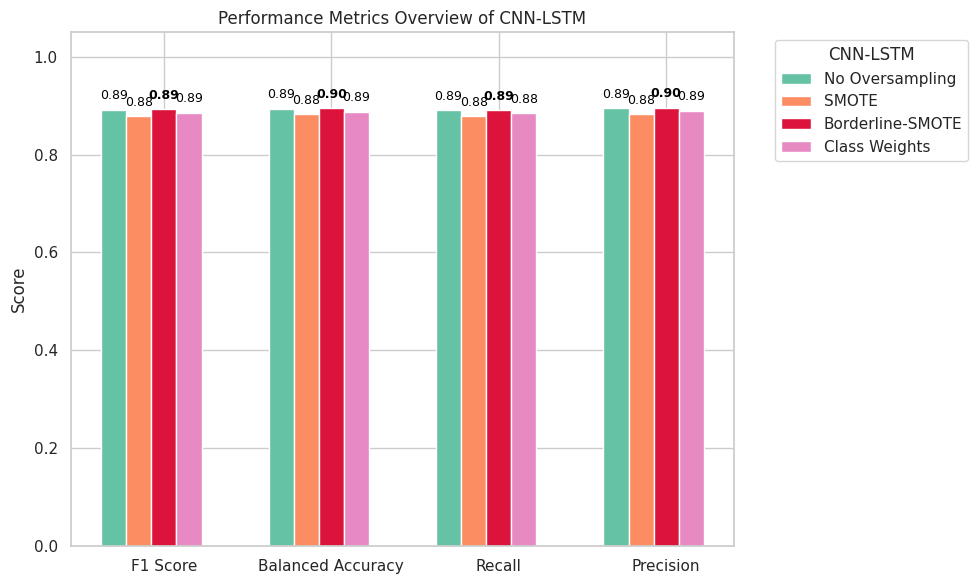

In [ ]:
plot_comparison_histograms(metrics_dict, technique_names=["No Oversampling", "SMOTE", "Borderline-SMOTE", "Class Weights"],model_family_name="CNN-LSTM", title=None)

---

###IV.2. Glove-GRU

In [ ]:
embedding_dim_gru_glove_no_oversampling = 300
hidden_dim_gru_glove_no_oversampling = 250
dropout_prob_gru_glove_no_oversampling = 0.3
model_name_gru_glove_no_oversampling = "GRU_Glove_No_Oversampling"
model_gru_glove_no_oversampling = GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=embedding_dim_gru_glove_no_oversampling,
                                            hidden_dim=hidden_dim_gru_glove_no_oversampling, num_layers=1,
                                            dropout_prob=dropout_prob_gru_glove_no_oversampling, embedding_weights=embedding_matrix,
                                            freeze_embeddings=False).to(device)
optimizer_gru_glove_no_oversampling = optim.AdamW(model_gru_glove_no_oversampling.parameters(), lr=7e-4)

embedding_dim_gru_glove_smote = 300
hidden_dim_gru_glove_smote = 250
dropout_prob_gru_glove_smote = 0.3
model_name_gru_glove_smote = "GRU_Glove_SMOTE"
model_gru_glove_smote = GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=embedding_dim_gru_glove_smote,
                                  hidden_dim=hidden_dim_gru_glove_smote, num_layers=1,
                                  dropout_prob=dropout_prob_gru_glove_smote, embedding_weights=embedding_matrix,
                                  freeze_embeddings=False).to(device)
optimizer_gru_glove_smote = optim.AdamW(model_gru_glove_smote.parameters(), lr=7e-4)

embedding_dim_gru_glove_borderline_smote = 300
hidden_dim_gru_glove_borderline_smote = 250
dropout_prob_gru_glove_borderline_smote = 0.3
model_name_gru_glove_borderline_smote = "GRU_Glove_Borderline_SMOTE"
model_gru_glove_borderline_smote = GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=embedding_dim_gru_glove_borderline_smote,
                                             hidden_dim=hidden_dim_gru_glove_borderline_smote, num_layers=1,
                                             dropout_prob=dropout_prob_gru_glove_borderline_smote, embedding_weights=embedding_matrix,
                                             freeze_embeddings=False).to(device)
optimizer_gru_glove_borderline_smote = optim.AdamW(model_gru_glove_borderline_smote.parameters(), lr=7e-4)

embedding_dim_gru_glove_class_weights = 300
hidden_dim_gru_glove_class_weights = 250
dropout_prob_gru_glove_class_weights = 0.3
model_name_gru_glove_class_weights = "GRU_Glove_class_weights"
model_gru_glove_class_weights = GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=embedding_dim_gru_glove_class_weights,
                                          hidden_dim=hidden_dim_gru_glove_class_weights, num_layers=1,
                                          dropout_prob=dropout_prob_gru_glove_class_weights, embedding_weights=embedding_matrix,
                                          freeze_embeddings=False).to(device)
optimizer_gru_glove_class_weights = optim.Adam(model_gru_glove_class_weights.parameters(), lr=9e-4)

criterion = nn.CrossEntropyLoss()

wandb.init(project="Resampling Technique Comparison - Glove-GRU", name="No Oversampling")

# No Oversampling
metrics_gru_glove_no_oversampling = train_model(
    model_gru_glove_no_oversampling,
    train_loader_no_oversampling,
    test_loader,
    optimizer_gru_glove_no_oversampling,
    criterion,
    num_epochs=40,
    model_name=model_name_gru_glove_no_oversampling,
    technique_name="No Oversampling",
    device=device
)

wandb.init(project="Resampling Technique Comparison - Glove-GRU", name="SMOTE")

# SMOTE
metrics_gru_glove_smote = train_model(
    model_gru_glove_smote,
    train_loader_smote,
    test_loader,
    optimizer_gru_glove_smote,
    criterion,
    num_epochs=40,
    model_name=model_name_gru_glove_smote,
    technique_name="SMOTE",
    device=device
)

wandb.init(project="Resampling Technique Comparison - Glove-GRU", name="Borderline-SMOTE")

# Borderline-SMOTE
metrics_gru_glove_borderline_smote = train_model(
    model_gru_glove_borderline_smote,
    train_loader_borderline_smote,
    test_loader,
    optimizer_gru_glove_borderline_smote,
    criterion,
    num_epochs=40,
    model_name=model_name_gru_glove_borderline_smote,
    technique_name="Borderline-SMOTE",
    device=device
)

wandb.init(project="Resampling Technique Comparison - Glove-GRU", name="Class Weights")

# Class Weights
metrics_gru_glove_class_weights = train_model_with_class_weights(
    model_gru_glove_class_weights,
    train_loader_no_oversampling,
    test_loader,
    optimizer_gru_glove_class_weights,
    class_weights_tensor,
    num_epochs=40,
    model_name=model_name_gru_glove_class_weights,
    technique_name="Class Weights",
    device=device
)

# Dictionary of metrics for all techniques
metrics_dict = {
    "No Oversampling (GRU-Glove)": metrics_gru_glove_no_oversampling[model_name_gru_glove_no_oversampling],
    "SMOTE (GRU-Glove)": metrics_gru_glove_smote[model_name_gru_glove_smote],
    "Borderline-SMOTE (GRU-Glove)": metrics_gru_glove_borderline_smote[model_name_gru_glove_borderline_smote],
    "Class Weights (GRU-Glove)": metrics_gru_glove_class_weights[model_name_gru_glove_class_weights],
}

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: wilfried-mvomoeto (wilfried-mvomoeto-university-of-li-ge) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


GRU_Glove_No_Oversampling Epoch 17/40 - Train Loss: 0.2942, Test Loss: 0.3044, Train Acc: 0.91%, Test Acc: 0.91%, Test F1: 0.91%, Test Balanced Acc: 0.91%, Test Recall: 0.91%, Time: 0.83 min:  42%|████▎     | 17/40 [14:53<20:08, 52.55s/epoch]


test_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁███
test_balanced_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁███
test_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁███
test_loss,███████████████▁▁▁
test_precision,▁▁▁▂▃▂▂▂▂▁▃▂▂▂▂███
test_recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁███
train_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅██
train_loss,███████████████▄▁▁
test_acc,0.91945
test_balanced_acc,0.92047
test_f1,0.91979


GRU_Glove_SMOTE Epoch 23/40 - Train Loss: 0.3634, Test Loss: 0.2907, Train Acc: 0.89%, Test Acc: 0.91%, Test F1: 0.91%, Test Balanced Acc: 0.92%, Test Recall: 0.91%, Time: 0.91 min:  57%|█████▊    | 23/40 [21:51<16:09, 57.02s/epoch]


test_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅███
test_balanced_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄███
test_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▅███
test_loss,████████████████████▅▁▁▁
test_precision,▂▁▂▂▁▂▂▂▃▃▂▁▂▂▂▃▁▁▂▂▆███
test_recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅███
train_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇██
train_loss,█████████████████████▂▁▁
test_acc,0.90548
test_balanced_acc,0.90793
test_f1,0.90565


GRU_Glove_Borderline_SMOTE Epoch 6/40 - Train Loss: 0.2668, Test Loss: 0.2786, Train Acc: 0.92%, Test Acc: 0.92%, Test F1: 0.92%, Test Balanced Acc: 0.92%, Test Recall: 0.92%, Time: 0.91 min:  15%|█▌        | 6/40 [06:21<36:01, 63.59s/epoch]


test_acc,▁▁▅████
test_balanced_acc,▁▁▅████
test_f1,▁▁▅████
test_loss,██▄▁▁▁▁
test_precision,▁▁▆████
test_recall,▁▁▅████
train_acc,▁▁▂▇███
train_loss,██▇▃▂▁▁
test_acc,0.91463
test_balanced_acc,0.91759
test_f1,0.91431


GRU_Glove_class_weights Epoch 3/40 - Train Loss: 0.2412, Test Loss: 0.2271, Train Acc: 0.92%, Test Acc: 0.93%, Test F1: 0.93%, Test Balanced Acc: 0.93%, Test Recall: 0.93%, Time: 0.81 min:   8%|▊         | 3/40 [03:14<40:04, 64.98s/epoch]


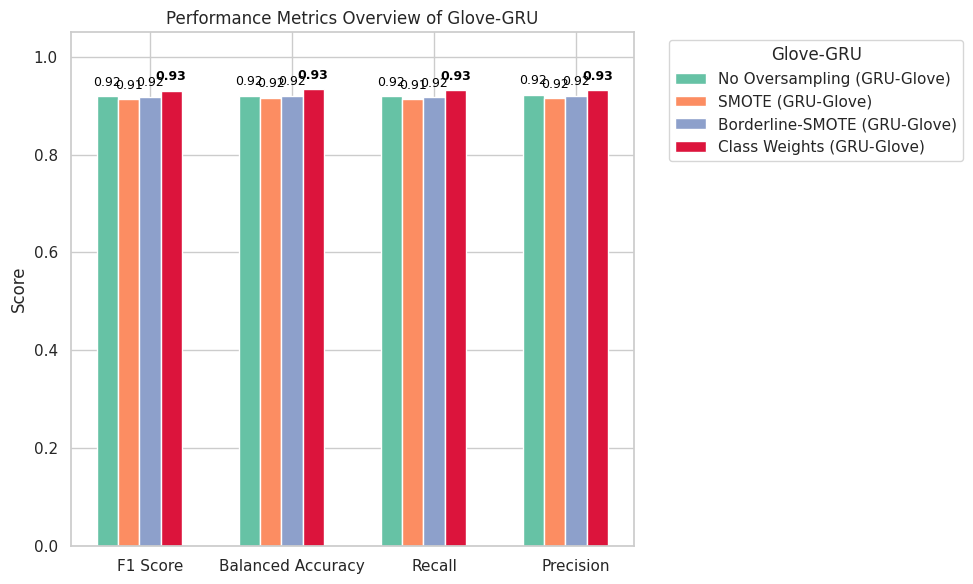

In [ ]:
plot_comparison_histograms(metrics_dict, technique_names=["No Oversampling", "SMOTE", "Borderline-SMOTE", "Class Weights"],model_family_name="Glove-GRU", title=None)

---

###IV.3. Glove (300d)-GRU

In [ ]:
embedding_dim_gru_glove_attention_no_oversampling = 300
hidden_dim_gru_glove_attention_no_oversampling = 250
dropout_prob_gru_glove_attention_no_oversampling = 0.3
model_name_gru_glove_attention_no_oversampling = "GRU_Glove_Attention_No_Oversampling"
model_gru_glove_attention_no_oversampling = GloVe_GRU_BahdanauAttention(embedding_matrix=embedding_matrix,
                                                                        hidden_dim=hidden_dim_gru_glove_attention_no_oversampling,
                                                                        num_classes=NUM_CLASSES, num_layers=1,
                                                                        dropout_prob=dropout_prob_gru_glove_attention_no_oversampling).to(device)
optimizer_gru_glove_attention_no_oversampling = optim.AdamW(model_gru_glove_attention_no_oversampling.parameters(), lr=7e-4)

embedding_dim_gru_glove_attention_smote = 300
hidden_dim_gru_glove_attention_smote = 250
dropout_prob_gru_glove_attention_smote = 0.3
model_name_gru_glove_attention_smote = "GRU_Glove_Attention_SMOTE"
model_gru_glove_attention_smote = GloVe_GRU_BahdanauAttention(embedding_matrix=embedding_matrix,
                                                             hidden_dim=hidden_dim_gru_glove_attention_smote,
                                                             num_classes=NUM_CLASSES, num_layers=1,
                                                             dropout_prob=dropout_prob_gru_glove_attention_smote).to(device)
optimizer_gru_glove_attention_smote = optim.AdamW(model_gru_glove_attention_smote.parameters(), lr=7e-4)

embedding_dim_gru_glove_attention_borderline_smote = 300
hidden_dim_gru_glove_attention_borderline_smote = 250
dropout_prob_gru_glove_attention_borderline_smote = 0.3
model_name_gru_glove_attention_borderline_smote = "GRU_Glove_Attention_Borderline_SMOTE"
model_gru_glove_attention_borderline_smote = GloVe_GRU_BahdanauAttention(embedding_matrix=embedding_matrix,
                                                                         hidden_dim=hidden_dim_gru_glove_attention_borderline_smote,
                                                                         num_classes=NUM_CLASSES, num_layers=1,
                                                                         dropout_prob=dropout_prob_gru_glove_attention_borderline_smote).to(device)
optimizer_gru_glove_attention_borderline_smote = optim.AdamW(model_gru_glove_attention_borderline_smote.parameters(), lr=7e-4)

embedding_dim_gru_glove_attention_class_weights = 300
hidden_dim_gru_glove_attention_class_weights = 250
dropout_prob_gru_glove_attention_class_weights = 0.3
model_name_gru_glove_attention_class_weights = "GRU_Glove_Attention_class_weights"
model_gru_glove_attention_class_weights = GloVe_GRU_BahdanauAttention(embedding_matrix=embedding_matrix,
                                                                      hidden_dim=hidden_dim_gru_glove_attention_class_weights,
                                                                      num_classes=NUM_CLASSES, num_layers=1,
                                                                      dropout_prob=dropout_prob_gru_glove_attention_class_weights).to(device)
optimizer_gru_glove_attention_class_weights = optim.Adam(model_gru_glove_attention_class_weights.parameters(), lr=9e-4)

wandb.init(project="Resampling Technique Comparison - Glove-GRU-Bahdanau", name="Borderline-SMOTE")

# Borderline-SMOTE
metrics_gru_glove_attention_borderline_smote = train_model(
    model_gru_glove_attention_borderline_smote,
    train_loader_borderline_smote,
    test_loader,
    optimizer_gru_glove_attention_borderline_smote,
    criterion,
    num_epochs=40,
    model_name=model_name_gru_glove_attention_borderline_smote,
    technique_name="Borderline-SMOTE",
    device=device
)

wandb.init(project="Resampling Technique Comparison - Glove-GRU-Bahdanau", name="No Oversampling")

# No Oversampling
metrics_gru_glove_attention_no_oversampling = train_model(
    model_gru_glove_attention_no_oversampling,
    train_loader_no_oversampling,
    test_loader,
    optimizer_gru_glove_attention_no_oversampling,
    criterion,
    num_epochs=40,
    model_name=model_name_gru_glove_attention_no_oversampling,
    technique_name="No Oversampling",
    device=device
)

wandb.init(project="Resampling Technique Comparison - Glove-GRU-Bahdanau", name="SMOTE")

# SMOTE
metrics_gru_glove_attention_smote = train_model(
    model_gru_glove_attention_smote,
    train_loader_smote,
    test_loader,
    optimizer_gru_glove_attention_smote,
    criterion,
    num_epochs=40,
    model_name=model_name_gru_glove_attention_smote,
    technique_name="SMOTE",
    device=device
)

wandb.init(project="Resampling Technique Comparison - Glove-GRU-Bahdanau", name="Class Weights")

# Class Weights
metrics_gru_glove_attention_class_weights = train_model_with_class_weights(
    model_gru_glove_attention_class_weights,
    train_loader_no_oversampling,
    test_loader,
    optimizer_gru_glove_attention_class_weights,
    class_weights_tensor,
    num_epochs=40,
    model_name=model_name_gru_glove_attention_class_weights,
    technique_name="Class Weights",
    device=device
)

test_acc,▁███
test_balanced_acc,▁███
test_f1,▁███
test_loss,█▁▁▁
test_precision,▁███
test_recall,▁███
train_acc,▁▂██
train_loss,█▇▁▁
test_acc,0.93136
test_balanced_acc,0.9335
test_f1,0.93104


GRU_Glove_Attention_Borderline_SMOTE Epoch 2/40 - Train Loss: 0.3072, Test Loss: 0.2398, Train Acc: 0.90%, Test Acc: 0.93%, Test F1: 0.93%, Test Balanced Acc: 0.93%, Test Recall: 0.93%, Time: 1.37 min:   5%|▌         | 2/40 [04:06<1:17:56, 123.06s/epoch]


test_acc,▁█▁
test_balanced_acc,▁█▂
test_f1,▁█▂
test_loss,▅▁█
test_precision,▁█▁
test_recall,▁█▁
train_acc,▁▅█
train_loss,█▄▁
test_acc,0.92083
test_balanced_acc,0.92305
test_f1,0.92104


GRU_Glove_Attention_No_Oversampling Epoch 2/40 - Train Loss: 0.2000, Test Loss: 0.2378, Train Acc: 0.94%, Test Acc: 0.92%, Test F1: 0.92%, Test Balanced Acc: 0.92%, Test Recall: 0.92%, Time: 1.25 min:   5%|▌         | 2/40 [03:44<1:11:06, 112.27s/epoch]


test_acc,▅█▁
test_balanced_acc,▇█▁
test_f1,▃█▁
test_loss,▃▁█
test_precision,▁█▆
test_recall,▅█▁
train_acc,▁▅█
train_loss,█▄▁
test_acc,0.92066
test_balanced_acc,0.92222
test_f1,0.92124


GRU_Glove_Attention_SMOTE Epoch 2/40 - Train Loss: 0.3138, Test Loss: 0.2425, Train Acc: 0.90%, Test Acc: 0.93%, Test F1: 0.93%, Test Balanced Acc: 0.93%, Test Recall: 0.93%, Time: 1.42 min:   5%|▌         | 2/40 [04:09<1:18:55, 124.62s/epoch]


test_acc,▅█▁
test_balanced_acc,▅█▁
test_f1,▅█▁
test_loss,▃▁█
test_precision,▅█▁
test_recall,▅█▁
train_acc,▁▅█
train_loss,█▄▁
test_acc,0.91221
test_balanced_acc,0.91589
test_f1,0.91196


GRU_Glove_Attention_class_weights Epoch 1/40 - Train Loss: 0.3051, Test Loss: 0.2431, Train Acc: 0.91%, Test Acc: 0.93%, Test F1: 0.93%, Test Balanced Acc: 0.93%, Test Recall: 0.93%, Time: 1.23 min:   2%|▎         | 1/40 [02:28<1:36:14, 148.07s/epoch]


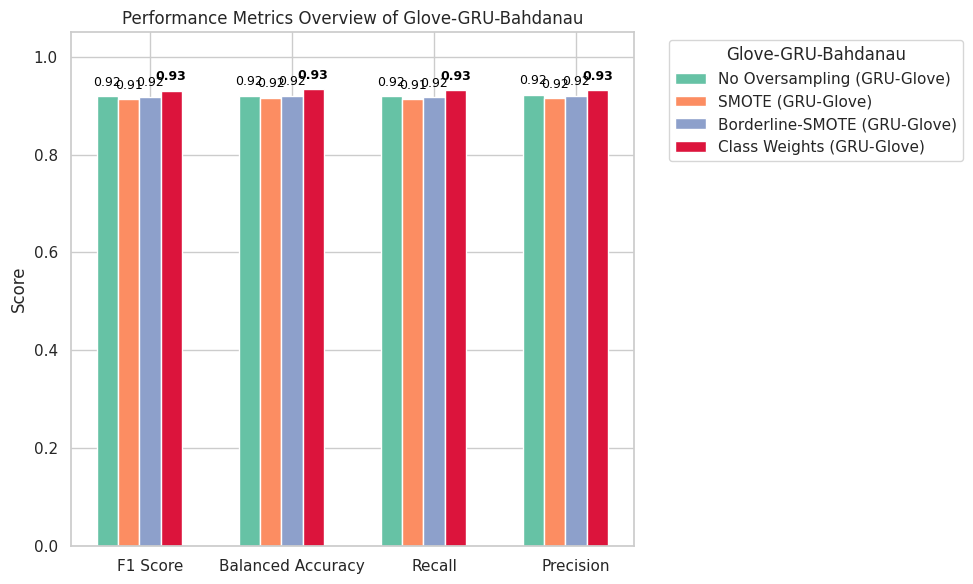

In [ ]:
plot_comparison_histograms(metrics_dict, technique_names=["No Oversampling", "SMOTE", "Borderline-SMOTE", "Class Weights"],model_family_name="Glove-GRU-Bahdanau", title=None)

---

## **Performance Comparison of Oversampling Techniques across Models**

###a.CNN-LSTM
Observation: All oversampling methods (No Oversampling, SMOTE, Borderline-SMOTE, Class Weights) produce nearly identical results.
Score Range: F1 Score, Balanced Accuracy, Recall, and Precision are all around 0.89–0.90.
**Conclusion**: For the CNN-LSTM architecture, oversampling strategies have little to no effect on the performance metrics.

###b.Glove-GRU
Observation: All oversampling methods again perform very similarly.
Score Range: All metrics hover around 0.92–0.93.
**Conclusion**: Glove-GRU performs very well across the board regardless of the balancing technique used. However, Class Weights slightly edge out others in all metrics.

###c.Glove-GRU-Bahdanau
Observation: Similar to Glove-GRU, all techniques give high and consistent scores.
Score Range: Each metric reaches about 0.92–0.93, with minimal variance.
**Conclusion**: Glove-GRU-Bahdanau achieves consistently high performance, and like with Glove-GRU, Class Weights show the best average across metrics.

**Best Overall Model**: Glove-GRU-Bahdanau with Class Weights consistently ranks at the top.

Oversampling Impact:
Minimal effect on CNN-LSTM.
Slight improvements for GRU-based models, especially using Class Weights.